# Demonstration of surrogate model capabilities

This is a simple jupyter notebook to demonstrate the autogluon surrogate model capability.

Author: Soheyl Massoudi <smassoudi@ethz.ch>

# Step 1: Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Step 2: Load and Convert Parquet Dataset

In [2]:
from datasets import load_dataset
import pandas as pd
import os

# Specify the directory and file path
csv_directory = "./data"
csv_file_name = "airfoil_data.csv"
csv_path = os.path.join(csv_directory, csv_file_name)
absolute_csv_path = os.path.abspath(csv_path)

# Create the directory if it doesn't exist
os.makedirs(csv_directory, exist_ok=True)

# Load dataset from Hugging Face
dataset = load_dataset("IDEALLab/airfoil_2d_v0", split="train")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)

# Save to CSV
df.to_csv(absolute_csv_path, index=False)

print(f"Dataset saved to {csv_path}")

/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset saved to ./data/airfoil_data.csv


In [3]:
dataset.column_names

['initial',
 'optimized',
 'mach',
 'reynolds',
 'cl_target',
 'area_target',
 'alpha',
 'area_initial',
 'cd_val',
 'cl_val',
 'cl_con',
 'area_con']

In [4]:
type(dataset['alpha'])

list

In [5]:
dataset['optimized'][1][0]

[1.0000194365938981,
 0.9897566593945221,
 0.9794544269870155,
 0.9691149136515305,
 0.9587402901643374,
 0.9483327419340516,
 0.9378945048481954,
 0.9274277968572291,
 0.9169348081262216,
 0.9064178020370062,
 0.8958790284346422,
 0.8853207187330372,
 0.8747448930482233,
 0.8641523083004454,
 0.8535437159737151,
 0.8429198967977035,
 0.8322817488654743,
 0.8216301200165563,
 0.8109658171290856,
 0.8002897285258235,
 0.7896027290487984,
 0.7789056461533759,
 0.7681993584263407,
 0.7574847603720507,
 0.7467626918304485,
 0.7360340279427758,
 0.7253037272659675,
 0.7145732743519277,
 0.7038473442473052,
 0.693126502752131,
 0.6824101435303259,
 0.6716976408464019,
 0.6609883248618159,
 0.6502815861483213,
 0.639576822934429,
 0.6288733614389102,
 0.6181705789840656,
 0.6074655520675161,
 0.5967516390819786,
 0.5860288162351749,
 0.5752975145222803,
 0.5645582221285628,
 0.5538114139478776,
 0.5430575344024076,
 0.5322970595788166,
 0.5215304770239737,
 0.5107583657552618,
 0.499988999525

# Step 3: Flatten columns and get X and Y datasets

In [6]:
def recursive_flatten(val):
    """
    Recursively flatten a nested list/tuple into a single list of values.
    E.g. [[x0, x1], [y0, y1]] -> [x0, x1, y0, y1].
    """
    if not isinstance(val, (list, tuple)):
        return [val]
    else:
        result = []
        for item in val:
            result.extend(recursive_flatten(item))
        return result

def flatten_list_columns_nested(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each column in `df` where the first row is a list,
    recursively flatten that column and expand into multiple new numeric columns.
    """
    import pandas as pd
    
    new_cols_list = []
    drop_cols = []
    
    for col in df.columns:
        first_value = df[col].iloc[0]
        # Check if the first row is a list/tuple --> likely all rows are lists
        if isinstance(first_value, (list, tuple)):
            # Flatten each row, store in a temporary list
            flattened_rows = [recursive_flatten(val) for val in df[col]]
            # Ensure consistent length across rows
            lengths = [len(row) for row in flattened_rows]
            unique_lengths = set(lengths)
            if len(unique_lengths) > 1:
                raise ValueError(
                    f"Column '{col}' has rows of varying lengths {unique_lengths}. "
                    "Cannot flatten consistently without special handling."
                )
            # Create new DataFrame with columns [col_0, col_1, ..., col_(n-1)]
            n = lengths[0]
            new_col_names = [f"{col}_{i}" for i in range(n)]
            expanded_df = pd.DataFrame(flattened_rows, columns=new_col_names)
            new_cols_list.append(expanded_df)
            drop_cols.append(col)
    
    if new_cols_list:
        # Drop original list-columns and concatenate new expanded columns
        df = pd.concat(
            [df.drop(columns=drop_cols).reset_index(drop=True)] + new_cols_list,
            axis=1
        )
    return df

# Flatten the nested list columns
df = flatten_list_columns_nested(df)


In [7]:
# The flattened columns for "optimized" will now appear as "optimized_0", "optimized_1", etc.
# Let's find all columns that start with "optimized_"
opt_cols = [col for col in df.columns if col.startswith("optimized_")]

# Or you can do them all if you know the exact count/structure

# Additional numeric columns we want
other_input_cols = ["mach", "reynolds", "alpha"]

# Combine them
feature_cols = opt_cols + other_input_cols

target_col = "cl_val"

# Create X and y
X = df[feature_cols].values
y = df[target_col].values


# Step 4: Split Inputs and Targets

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Suppose X is shape [n_samples, n_features], y is shape [n_samples]
# (Replace with your actual arrays from the flattened dataset.)

# 1) Split off test data (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) Split the remaining into train and validation (25% of X_temp = 20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}, Test size: {X_test.shape}")

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Optionally scale target as well
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


Train size: (448, 387), Val size: (150, 387), Test size: (150, 387)


# Step 5: Define a Pytorch Dataset and Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TabularDataset(X_train_scaled, y_train_scaled)
val_dataset   = TabularDataset(X_val_scaled,   y_val_scaled)
test_dataset  = TabularDataset(X_test_scaled,  y_test_scaled)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


class SimpleRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(SimpleRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train_scaled.shape[1]  # Number of features
hidden_dim = 64
model = SimpleRegressor(input_dim, hidden_dim, output_dim=1)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

model.to(device)

num_epochs = 100
patience = 10  # Early stopping patience
best_val_loss = float("inf")
epochs_no_improve = 0

train_losses = []
val_losses = []

best_model_weights = None
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    # --- Training Loop ---
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch).squeeze(-1)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Loop ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch).squeeze(-1)
            loss = criterion(predictions, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        epochs_no_improve = 0
        # Store best weights
        best_model_weights = model.state_dict()
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early stopping condition
    if epochs_no_improve >= patience:
        print(f"Validation loss has not improved for {patience} epochs. Stopping early.")
        break

# --- After training, restore the best weights ---
print(f"Best validation loss = {best_val_loss:.4f} at epoch {best_epoch+1}.")
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)



Using device: mps
Epoch 1/100 - Train Loss: 0.7779, Val Loss: 0.6491
Epoch 2/100 - Train Loss: 0.5426, Val Loss: 0.5571
Epoch 3/100 - Train Loss: 0.4203, Val Loss: 0.4517
Epoch 4/100 - Train Loss: 0.3566, Val Loss: 0.5126
Epoch 5/100 - Train Loss: 0.2885, Val Loss: 0.3740
Epoch 6/100 - Train Loss: 0.2311, Val Loss: 0.3203
Epoch 7/100 - Train Loss: 0.2069, Val Loss: 0.3497
Epoch 8/100 - Train Loss: 0.1813, Val Loss: 0.2814
Epoch 9/100 - Train Loss: 0.1509, Val Loss: 0.2585
Epoch 10/100 - Train Loss: 0.1446, Val Loss: 0.2606
Epoch 11/100 - Train Loss: 0.1486, Val Loss: 0.2190
Epoch 12/100 - Train Loss: 0.1236, Val Loss: 0.1765
Epoch 13/100 - Train Loss: 0.1032, Val Loss: 0.2197
Epoch 14/100 - Train Loss: 0.1139, Val Loss: 0.1706
Epoch 15/100 - Train Loss: 0.0833, Val Loss: 0.1646
Epoch 16/100 - Train Loss: 0.0799, Val Loss: 0.1505
Epoch 17/100 - Train Loss: 0.0682, Val Loss: 0.1327
Epoch 18/100 - Train Loss: 0.0685, Val Loss: 0.1336
Epoch 19/100 - Train Loss: 0.0633, Val Loss: 0.1169
Epo

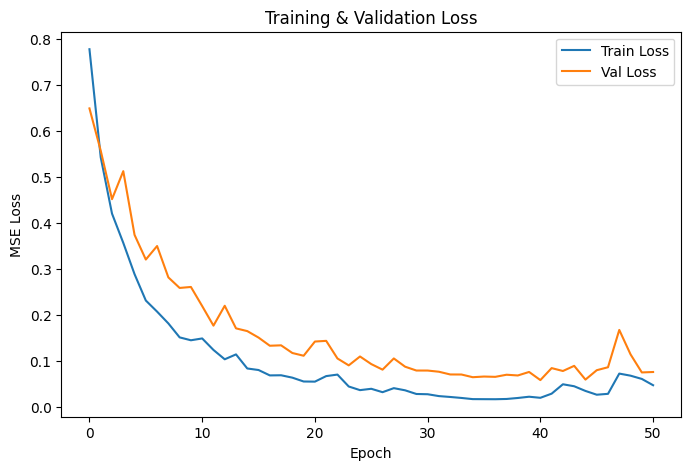

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


# Step 6: Predictions and Inverse Transform

In [11]:
model.eval()
test_preds_scaled = []
test_targets_scaled = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(X_batch).squeeze(-1)

        test_preds_scaled.append(preds.cpu().numpy())
        test_targets_scaled.append(y_batch.cpu().numpy())

test_preds_scaled = np.concatenate(test_preds_scaled)
test_targets_scaled = np.concatenate(test_targets_scaled)

# Inverse transform if you scaled the target
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
test_targets = scaler_y.inverse_transform(test_targets_scaled.reshape(-1, 1)).flatten()

# Calculate the final test MSE or RMSE
mse_test = np.mean((test_preds - test_targets)**2)
rmse_test = np.sqrt(mse_test)
print(f"Test MSE:  {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

# Display a small sample of true vs predicted
print("\nSample of predictions vs true values:")
for i in range(5):
    print(f"Predicted: {test_preds[i]:.4f},  True: {test_targets[i]:.4f},  Diff: {test_preds[i] - test_targets[i]:.4f}")


Test MSE:  0.0031
Test RMSE: 0.0561

Sample of predictions vs true values:
Predicted: 0.7420,  True: 0.7862,  Diff: -0.0443
Predicted: 0.9102,  True: 0.9167,  Diff: -0.0065
Predicted: 0.7486,  True: 0.7405,  Diff: 0.0082
Predicted: 0.8529,  True: 0.8399,  Diff: 0.0130
Predicted: 0.8227,  True: 0.8537,  Diff: -0.0310


In [12]:
# Step 1: Setup

In [17]:
from datasets import load_dataset
import pandas as pd
import os

# Specify the directory and file path
csv_directory = "./data"
csv_file_name = "airfoil_data.csv"
csv_path = os.path.join(csv_directory, csv_file_name)
absolute_csv_path = os.path.abspath(csv_path)

# Create the directory if it doesn't exist
os.makedirs(csv_directory, exist_ok=True)

# Load dataset from Hugging Face
dataset = load_dataset("IDEALLab/airfoil_2d_v0", split="train")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)

# Save to CSV
df.to_csv(absolute_csv_path, index=False)

print(f"Dataset saved to {csv_path}")



/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 47/47 [00:00<00:00, 21561.01 examples/s]


Dataset saved to ./data/airfoil_data.csv


In [2]:
import pandas as pd

# Load the dataset from Hugging Face's raw CSV URL
csv_url = "https://huggingface.co/datasets/IDEALLab/power_electronics_v0/resolve/main/dataset_v0_1.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_url)

# Display the first few rows
print(df.head())

# Save it locally if needed
df.to_csv("./data/power_electronics_v0_1.csv", index=False)


         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  


In [32]:
type(df["initial_design"][0][1])


list

Type of df['initial_design'][0]: <class 'list'>
Type of first element (x coords): <class 'list'>
Type of second element (y coords): <class 'list'>


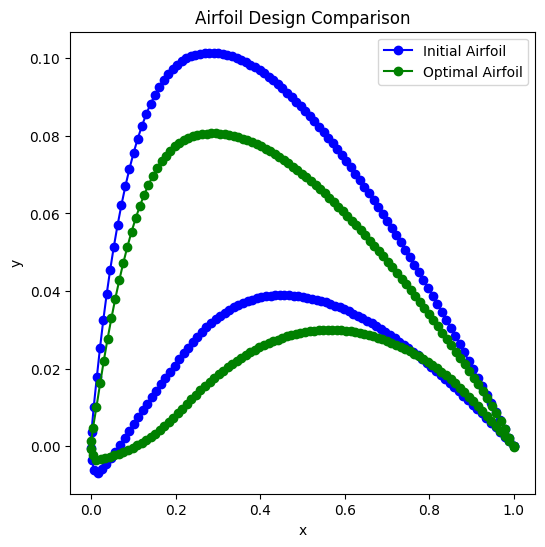

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Get the first entry for initial and optimal designs
init_design = df["initial_design"].iloc[0]
opt_design  = df["optimal_design"].iloc[0]

# Verify the structure:
print("Type of df['initial_design'][0]:", type(init_design))
print("Type of first element (x coords):", type(init_design[0]))
print("Type of second element (y coords):", type(init_design[1]))

# Pair x and y coordinates for initial and optimal designs
init_coords = np.column_stack((init_design[0], init_design[1]))
opt_coords  = np.column_stack((opt_design[0], opt_design[1]))

# Plot the designs
plt.figure(figsize=(6,6))
plt.plot(init_coords[:,0], init_coords[:,1], 'bo-', label="Initial Airfoil")
plt.plot(opt_coords[:,0], opt_coords[:,1], 'go-', label="Optimal Airfoil")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Airfoil Design Comparison")
plt.legend()
plt.show()


## Step 

## Step 2: Load surrogate model from engiopt

In [18]:
dataset.column_names

['initial_design',
 'optimal_design',
 'mach',
 'reynolds',
 'cl_target',
 'area_target',
 'alpha',
 'area_initial',
 'cd_val',
 'cl_val',
 'cl_con',
 'area_con']

In [ ]:
print(df.head())

         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  


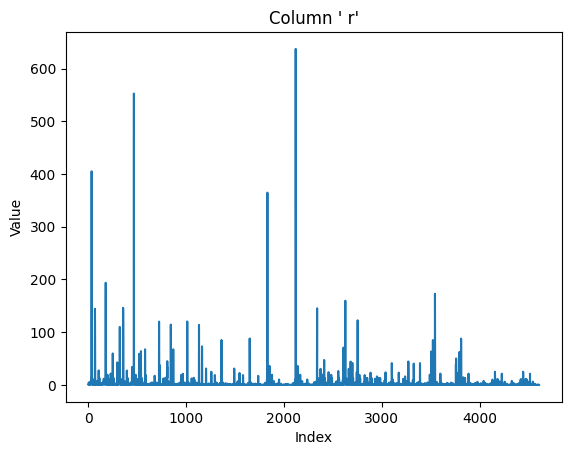

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

df[' r'].plot(kind='line', title="Column ' r'")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


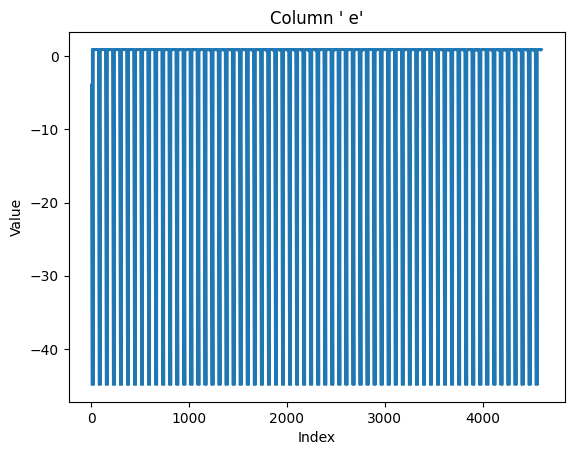

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

df[' e'].plot(kind='line', title="Column ' e'")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


In [5]:
df.describe()


C1           C2           C3           C4           C5  \
count  4608.000000  4608.000000  4608.000000  4608.000000  4608.000000   
mean      0.000011     0.000011     0.000011     0.000011     0.000011   
std       0.000010     0.000010     0.000010     0.000010     0.000010   
min       0.000001     0.000001     0.000001     0.000001     0.000001   
25%       0.000001     0.000001     0.000001     0.000001     0.000001   
50%       0.000011     0.000011     0.000011     0.000011     0.000011   
75%       0.000020     0.000020     0.000020     0.000020     0.000020   
max       0.000020     0.000020     0.000020     0.000020     0.000020   

                C6           L1           L2           L3           T1  \
count  4608.000000  4608.000000  4608.000000  4608.000000  4608.000000   
mean      0.000011     0.000500     0.000500     0.000500     0.500000   
std       0.000010     0.000500     0.000500     0.000500     0.258227   
min       0.000001     0.000001     0.000001     0.000001     0.100000   
25%       0.000001     0.000001     0.000001     0.000001     0.300000   
50%       0.000011     0.000500     0.000500     0.000500     0.500000   
75%       0.000020     0.001000     0.001000     0.001000     0.700000   
max       0.000020     0.001000     0.001000     0.001000     0.900000   

                  g            r            e  
count  4.608000e+03  4608.000000  4608.000000  
mean   1.779687e-01     2.548686    -5.418452  
std    2.262546e-01    17.426358    12.806794  
min    7.770340e-07     0.004893   -44.932700  
25%    1.167198e-02     0.160791    -0.455450  
50%    6.475145e-02     0.409126     0.882925  
75%    2.905664e-01     1.147634     0.950271  
max    9.619789e-01   637.193300     0.992604

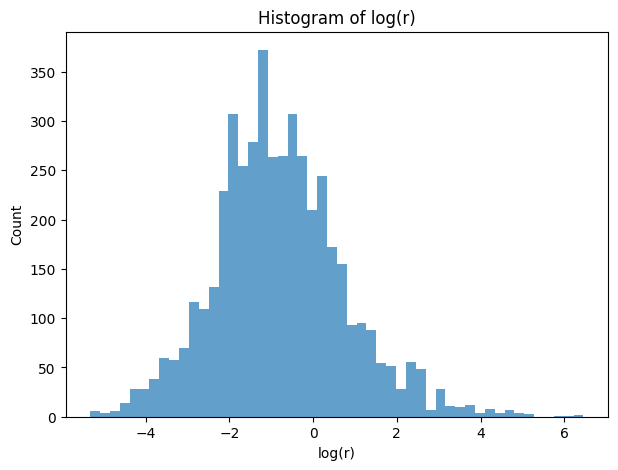

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Compute log(r + 1e-8)
log_r = np.log(df[' r'])

# Histogram
plt.figure(figsize=(7, 5))
plt.hist(log_r, bins=50, alpha=0.7)
plt.xlabel("log(r)")
plt.ylabel("Count")
plt.title("Histogram of log(r)")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute log(r + 1e-8)
r = df[' r']

# Histogram
plt.figure(figsize=(7, 5))
plt.hist(r, bins=50, alpha=0.7)
plt.xlabel("r")
plt.ylabel("Count")
plt.title("Histogram of r")
plt.show()


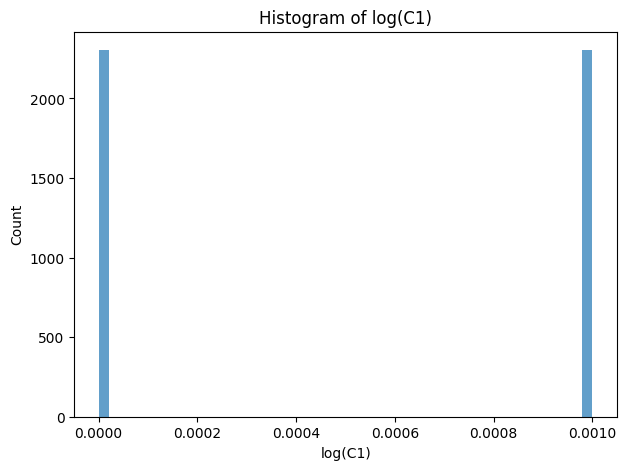

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Compute log(r + 1e-8)
log_r = df[' L3']

# Histogram
plt.figure(figsize=(7, 5))
plt.hist(log_r, bins=50, alpha=0.7)
plt.xlabel("log(C1)")
plt.ylabel("Count")
plt.title("Histogram of log(C1)")
plt.show()


In [19]:
df.columns

Index(['C1', ' C2', ' C3', ' C4', ' C5', ' C6', ' L1', ' L2', ' L3', ' T1',
       ' g', ' r', ' e'],
      dtype='object')

In [14]:
!python ./engiopt/shape2shape_leastV_vae.py \
    --data_dir "../EngiOpt/data" \
    --data_input "power_electronics_v0_1.csv" \
    --init_col "" \
    --opt_col "" \
    --target_col "r" \
    --log_target \
    --params_cols '["C1","C2","C3","C4","C5","C6","L1","L2","L3","T1", "g"]' \
    --nondim_map '{"C2": "C1", "C3": "C1", "C4": "C1", "C5": "C1", "C6": "C1", "L2": "L1", "L3": "L1"}' \
    --strip_column_spaces \
    --flatten_columns "[]" \
    --lambda_lv 1e-2 \
    --learning_rate 5e-5 \
    --no-structured \
    --hidden_layers 3 \
    --hidden_size 64 \
    --latent_dim 8 \
    --n_epochs 4000 \
    --batch_size 32 \
    --patience 500 \
    --scale_target \
    --no-track \
    --seed 18 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

Using device: mps
         C1        C2        C3        C4  ...   T1         g         r          e
0  0.000001  0.000001  0.000001  0.000001  ...  0.1  0.440126  0.914354  -3.903844
1  0.000001  0.000001  0.000001  0.000001  ...  0.2  0.410832  1.152453  -9.022484
2  0.000001  0.000001  0.000001  0.000001  ...  0.3  0.353193  1.521469 -14.144002
3  0.000001  0.000001  0.000001  0.000001  ...  0.4  0.256083  2.190335 -19.268402
4  0.000001  0.000001  0.000001  0.000001  ...  0.5  0.147918  3.205281 -24.395419

[5 rows x 13 columns]
Applied nondimensionalization using map: {'C2': 'C1', 'C3': 'C1', 'C4': 'C1', 'C5': 'C1', 'C6': 'C1', 'L2': 'L1', 'L3': 'L1'}
Applied log-transform to column 'r'
[Epoch 1/4000] Train Loss: 0.4053, Val Loss: 0.4019
[Epoch 2/4000] Train Loss: 0.3954, Val Loss: 0.3910
[Epoch 3/4000] Train Loss: 0.3826, Val Loss: 0.3762
[Epoch 4/4000] Train Loss: 0.3659, Val Loss: 0.3566
[Epoch 5/4000] Train Loss: 0.3455, Val Loss: 0.3344
[Epoch 6/4000] Train Loss: 0.3235, Val 

In [ ]:
# better cause circuit as categorical values so dimless i think not needed
!python ./engiopt/shape2shape_leastV_vae.py \
    --data_dir "../EngiOpt/data" \
    --data_input "power_electronics_v0_1.csv" \
    --init_col "" \
    --opt_col "" \
    --target_col "r" \
    --log_target \
    --params_cols '["C1","C2","C3","C4","C5","C6","L1","L2","L3","T1", "g"]' \
    --strip_column_spaces \
    --flatten_columns "[]" \
    --lambda_lv 1e-2 \
    --learning_rate 5e-5 \
    --no-structured \
    --hidden_layers 3 \
    --hidden_size 64 \
    --latent_dim 8 \
    --n_epochs 4000 \
    --batch_size 32 \
    --patience 500 \
    --scale_target \
    --no-track \
    --seed 18 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

Using device: mps
         C1        C2        C3        C4  ...   T1         g         r          e
0  0.000001  0.000001  0.000001  0.000001  ...  0.1  0.440126  0.914354  -3.903844
1  0.000001  0.000001  0.000001  0.000001  ...  0.2  0.410832  1.152453  -9.022484
2  0.000001  0.000001  0.000001  0.000001  ...  0.3  0.353193  1.521469 -14.144002
3  0.000001  0.000001  0.000001  0.000001  ...  0.4  0.256083  2.190335 -19.268402
4  0.000001  0.000001  0.000001  0.000001  ...  0.5  0.147918  3.205281 -24.395419

[5 rows x 13 columns]
Traceback (most recent call last):
  File "/Users/smassoudi/Library/CloudStorage/OneDrive-ETHZurich/Code_Collaborative/EngiOpt/./engiopt/shape2shape_leastV_vae.py", line 828, in <module>
    main(args)
  File "/Users/smassoudi/Library/CloudStorage/OneDrive-ETHZurich/Code_Collaborative/EngiOpt/./engiopt/shape2shape_leastV_vae.py", line 413, in main
    raise ValueError(f"Missing target column: {args.target_col}")
ValueError: Missing target column: cl_val


In [43]:
# better cause circuit as categorical values so dimless i think not needed
!python ./engiopt/shape2shape_leastV_vae_hybsm.py \
    --data_dir "../EngiOpt/data" \
    --data_input "power_electronics_v0_1.csv" \
    --init_col "" \
    --opt_col "" \
    --target_col "r" \
    --log_target \
    --params_cols '["C1","C2","C3","C4","C5","C6","L1","L2","L3","T1", "g"]' \
    --strip_column_spaces \
    --flatten_columns "[]" \
    --lambda_lv 1e-2 \
    --learning_rate 1e-3 \
    --no-structured \
    --hidden_layers 2 \
    --hidden_size 128 \
    --latent_dim 8 \
    --n_epochs 500 \
    --batch_size 64 \
    --patience 200 \
    --scale_target \
    --track \
    --wandb_project "shape2shape_leastV_vae_hybsm_pe"\
    --seed 18 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

wandb: Currently logged in as: smassoudi (smassoudi-eth-z-rich) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.5
wandb: Run data is saved locally in /Users/smassoudi/Library/CloudStorage/OneDrive-ETHZurich/Code_Collaborative/EngiOpt/wandb/run-20250321_140316-8izlkqbu
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run power_electronics_v0_1.csv__seed18__2025-03-21-14-03-15
wandb: ⭐️ View project at https://wandb.ai/smassoudi-eth-z-rich/shape2shape_leastV_vae_hybsm_pe
wandb: 🚀 View run at https://wandb.ai/smassoudi-eth-z-rich/shape2shape_leastV_vae_hybsm_pe/runs/8izlkqbu
Using device: mps
         C1        C2        C3        C4  ...   T1         g         r          e
0  0.000001  0.000001  0.000001  0.000001  ...  0.1  0.440126  0.914354  -3.903844
1  0.000001  0.000001  0.000001  0.000001  ...

[INFO 03-23 15:41:06] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter learning_rate. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-23 15:41:06] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter hidden_layers. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/service/utils/instantiation.py:258: AxParameterWarning: `is_ordered` is not specified for `ChoiceParameter` "hidden_layers". Defaulting to `True`  since the parameter is not of type string.. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction. Note that choice parameters with exactly 2 choices are always considered ordered and that the user-supplied `is_ordered`

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

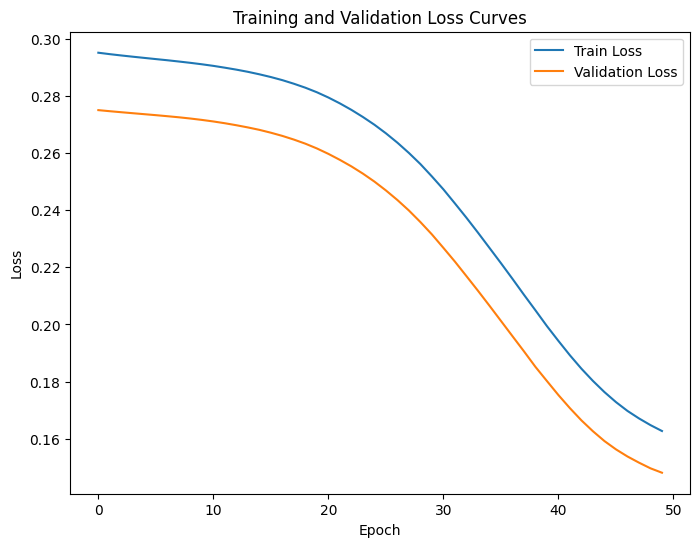

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-41-06.png
Test samples (avg ensemble):
Sample   0: Pred=0.4487, True=2.4654
Sample   1: Pred=0.1577, True=0.1334
Sample   2: Pred=0.4829, True=1.2167
Sample   3: Pred=0.6072, True=1.1593
Sample   4: Pred=0.0990, True=0.1802
Sample   5: Pred=0.3463, True=0.0600
Sample   6: Pred=0.8937, True=1.7800
Sample   7: Pred=1.6229, True=4.3986
Sample   8: Pred=0.4042, True=0.4696
Sample   9: Pred=0.0681, True=0.1055
Sample  10: Pred=1.4330, True=0.6503
Sample  11: Pred=0.3283, True=0.1610
Sample  12: Pred=0.4026, True=0.1694
Sample  13: Pred=0.5298, True=0.5143
Sample  14: Pred=1.1377, True=2.1430
Sample  15: Pred=0.2203, True=0.2603
Sample  16: Pred=1.2766, True=0.8442
Sample  17: Pred=0.1521, True=0.1382
Sample  18: Pred=0.9990, True=2.9576
Sample  19: Pred=1.4536, True=8.0533
Sample  20: Pred=0.6429, True=0.2522
Sample  21: Pred=0.0658, True=0.0144
Sample  22: Pred=0.9346, True=1.2707
Sample  23: Pred=0.8488, True=1

[INFO 03-23 15:41:19] ax.service.managed_loop: Running optimization trial 2...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

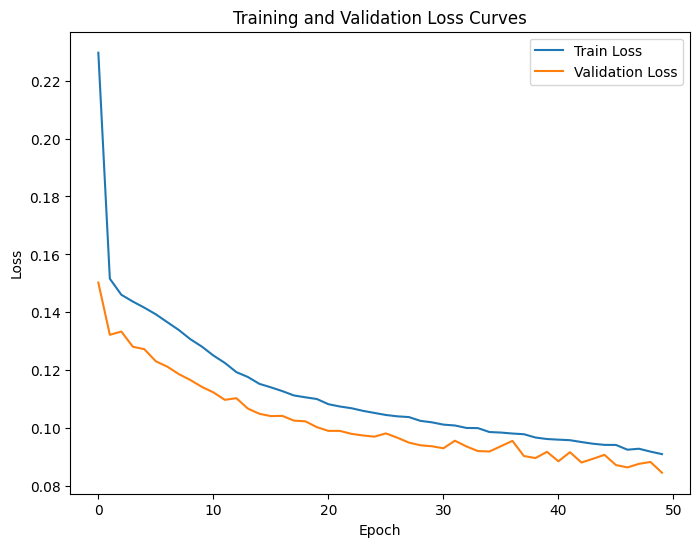

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-41-19.png
Test samples (avg ensemble):
Sample   0: Pred=0.5103, True=2.4654
Sample   1: Pred=0.0390, True=0.1334
Sample   2: Pred=0.5902, True=1.2167
Sample   3: Pred=1.1085, True=1.1593
Sample   4: Pred=0.2485, True=0.1802
Sample   5: Pred=0.0817, True=0.0600
Sample   6: Pred=4.5266, True=1.7800
Sample   7: Pred=1.2786, True=4.3986
Sample   8: Pred=0.7703, True=0.4696
Sample   9: Pred=0.0710, True=0.1055
Sample  10: Pred=0.4551, True=0.6503
Sample  11: Pred=0.6680, True=0.1610
Sample  12: Pred=0.5936, True=0.1694
Sample  13: Pred=0.2705, True=0.5143
Sample  14: Pred=2.2410, True=2.1430
Sample  15: Pred=0.2108, True=0.2603
Sample  16: Pred=1.3218, True=0.8442
Sample  17: Pred=0.0654, True=0.1382
Sample  18: Pred=0.9618, True=2.9576
Sample  19: Pred=3.9475, True=8.0533
Sample  20: Pred=0.2721, True=0.2522
Sample  21: Pred=0.0293, True=0.0144
Sample  22: Pred=2.4330, True=1.2707
Sample  23: Pred=1.0009, True=1

[INFO 03-23 15:42:50] ax.service.managed_loop: Running optimization trial 3...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

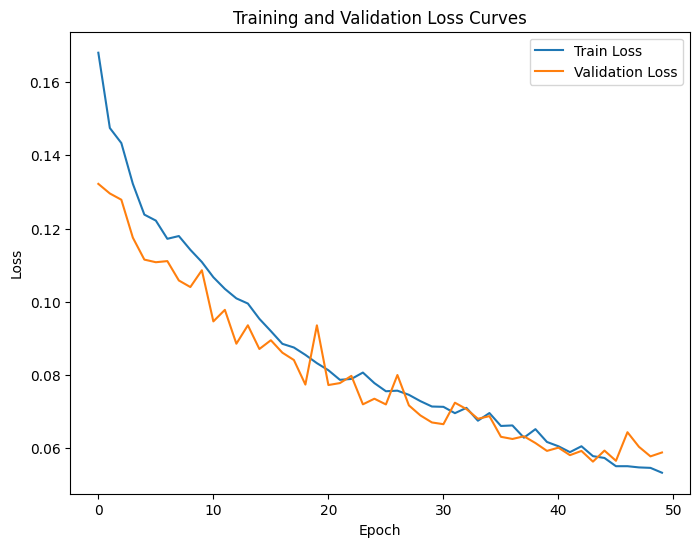

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-42-50.png
Test samples (avg ensemble):
Sample   0: Pred=1.6191, True=2.4654
Sample   1: Pred=0.0496, True=0.1334
Sample   2: Pred=0.5298, True=1.2167
Sample   3: Pred=0.8558, True=1.1593
Sample   4: Pred=0.1409, True=0.1802
Sample   5: Pred=0.0408, True=0.0600
Sample   6: Pred=17.3769, True=1.7800
Sample   7: Pred=1.5197, True=4.3986
Sample   8: Pred=0.7657, True=0.4696
Sample   9: Pred=0.0887, True=0.1055
Sample  10: Pred=0.5423, True=0.6503
Sample  11: Pred=0.8671, True=0.1610
Sample  12: Pred=0.4071, True=0.1694
Sample  13: Pred=0.1597, True=0.5143
Sample  14: Pred=2.6037, True=2.1430
Sample  15: Pred=0.2398, True=0.2603
Sample  16: Pred=1.3079, True=0.8442
Sample  17: Pred=0.1282, True=0.1382
Sample  18: Pred=1.8877, True=2.9576
Sample  19: Pred=4.0526, True=8.0533
Sample  20: Pred=0.3576, True=0.2522
Sample  21: Pred=0.0148, True=0.0144
Sample  22: Pred=2.2244, True=1.2707
Sample  23: Pred=1.8426, True=

[INFO 03-23 15:43:23] ax.service.managed_loop: Running optimization trial 4...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

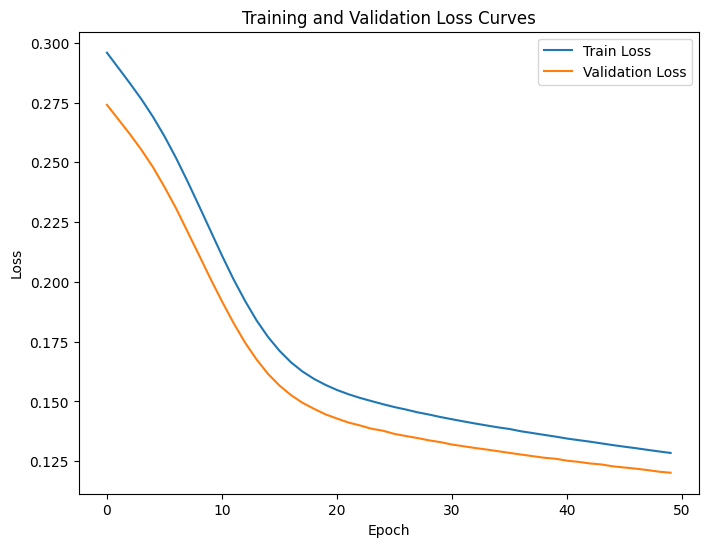

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-43-23.png
Test samples (avg ensemble):
Sample   0: Pred=0.7189, True=2.4654
Sample   1: Pred=0.0895, True=0.1334
Sample   2: Pred=0.4627, True=1.2167
Sample   3: Pred=0.7836, True=1.1593
Sample   4: Pred=0.1223, True=0.1802
Sample   5: Pred=0.3028, True=0.0600
Sample   6: Pred=1.3094, True=1.7800
Sample   7: Pred=2.0880, True=4.3986
Sample   8: Pred=0.3741, True=0.4696
Sample   9: Pred=0.0331, True=0.1055
Sample  10: Pred=1.1206, True=0.6503
Sample  11: Pred=0.3896, True=0.1610
Sample  12: Pred=0.4907, True=0.1694
Sample  13: Pred=0.4579, True=0.5143
Sample  14: Pred=1.4202, True=2.1430
Sample  15: Pred=0.1971, True=0.2603
Sample  16: Pred=1.2015, True=0.8442
Sample  17: Pred=0.1109, True=0.1382
Sample  18: Pred=1.0120, True=2.9576
Sample  19: Pred=2.2881, True=8.0533
Sample  20: Pred=0.3946, True=0.2522
Sample  21: Pred=0.0218, True=0.0144
Sample  22: Pred=1.2789, True=1.2707
Sample  23: Pred=0.7441, True=1

[INFO 03-23 15:43:43] ax.service.managed_loop: Running optimization trial 5...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

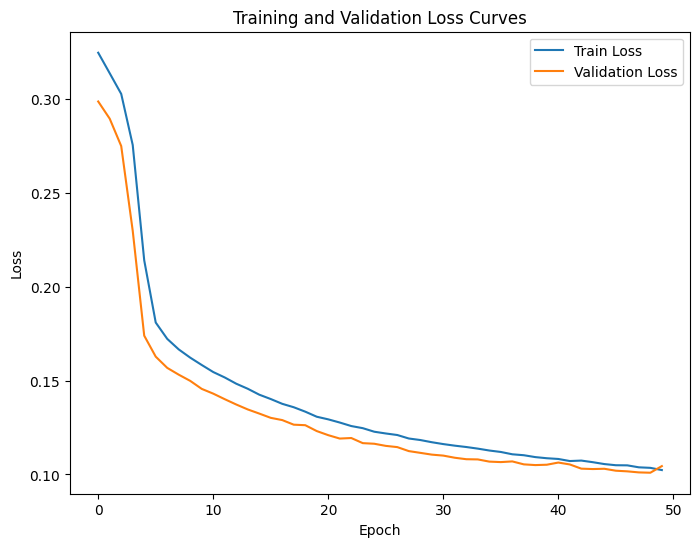

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-43-43.png
Test samples (avg ensemble):
Sample   0: Pred=0.9575, True=2.4654
Sample   1: Pred=0.0549, True=0.1334
Sample   2: Pred=0.4013, True=1.2167
Sample   3: Pred=0.9038, True=1.1593
Sample   4: Pred=0.1562, True=0.1802
Sample   5: Pred=0.1212, True=0.0600
Sample   6: Pred=2.5355, True=1.7800
Sample   7: Pred=0.8356, True=4.3986
Sample   8: Pred=0.5186, True=0.4696
Sample   9: Pred=0.0503, True=0.1055
Sample  10: Pred=0.4966, True=0.6503
Sample  11: Pred=0.5888, True=0.1610
Sample  12: Pred=0.5986, True=0.1694
Sample  13: Pred=0.3127, True=0.5143
Sample  14: Pred=1.3960, True=2.1430
Sample  15: Pred=0.2185, True=0.2603
Sample  16: Pred=1.0545, True=0.8442
Sample  17: Pred=0.0723, True=0.1382
Sample  18: Pred=1.0149, True=2.9576
Sample  19: Pred=3.8323, True=8.0533
Sample  20: Pred=0.2373, True=0.2522
Sample  21: Pred=0.0306, True=0.0144
Sample  22: Pred=2.0333, True=1.2707
Sample  23: Pred=0.7284, True=1

[INFO 03-23 15:44:45] ax.service.managed_loop: Running optimization trial 6...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

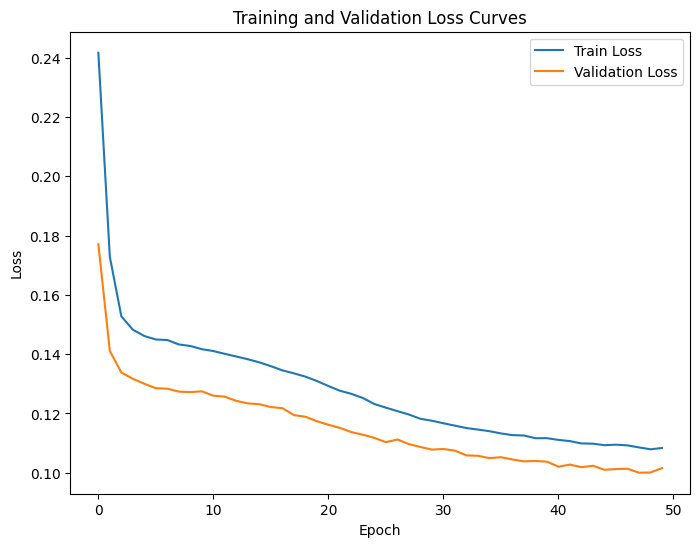

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-44-45.png
Test samples (avg ensemble):
Sample   0: Pred=0.6967, True=2.4654
Sample   1: Pred=0.0463, True=0.1334
Sample   2: Pred=0.9705, True=1.2167
Sample   3: Pred=1.1868, True=1.1593
Sample   4: Pred=0.2377, True=0.1802
Sample   5: Pred=0.2158, True=0.0600
Sample   6: Pred=2.6601, True=1.7800
Sample   7: Pred=2.3555, True=4.3986
Sample   8: Pred=0.6571, True=0.4696
Sample   9: Pred=0.0757, True=0.1055
Sample  10: Pred=0.7690, True=0.6503
Sample  11: Pred=0.5584, True=0.1610
Sample  12: Pred=0.6337, True=0.1694
Sample  13: Pred=0.3784, True=0.5143
Sample  14: Pred=1.7731, True=2.1430
Sample  15: Pred=0.2392, True=0.2603
Sample  16: Pred=1.6834, True=0.8442
Sample  17: Pred=0.0809, True=0.1382
Sample  18: Pred=1.1922, True=2.9576
Sample  19: Pred=2.6684, True=8.0533
Sample  20: Pred=0.3283, True=0.2522
Sample  21: Pred=0.0389, True=0.0144
Sample  22: Pred=1.7566, True=1.2707
Sample  23: Pred=1.0397, True=1

[INFO 03-23 15:44:57] ax.service.managed_loop: Running optimization trial 7...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

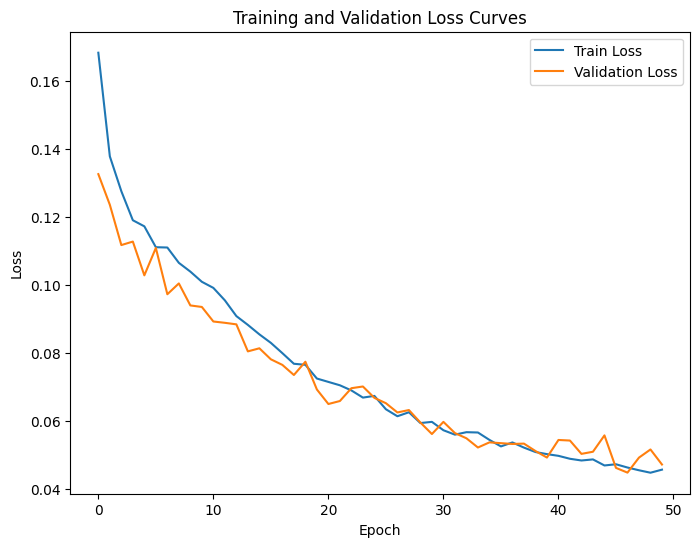

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-44-57.png
Test samples (avg ensemble):
Sample   0: Pred=1.4390, True=2.4654
Sample   1: Pred=0.1006, True=0.1334
Sample   2: Pred=0.3363, True=1.2167
Sample   3: Pred=1.1477, True=1.1593
Sample   4: Pred=0.2528, True=0.1802
Sample   5: Pred=0.0556, True=0.0600
Sample   6: Pred=14.3310, True=1.7800
Sample   7: Pred=0.6446, True=4.3986
Sample   8: Pred=0.4677, True=0.4696
Sample   9: Pred=0.0908, True=0.1055
Sample  10: Pred=0.5545, True=0.6503
Sample  11: Pred=1.0094, True=0.1610
Sample  12: Pred=0.3497, True=0.1694
Sample  13: Pred=0.2145, True=0.5143
Sample  14: Pred=2.0886, True=2.1430
Sample  15: Pred=0.2070, True=0.2603
Sample  16: Pred=0.6967, True=0.8442
Sample  17: Pred=0.1366, True=0.1382
Sample  18: Pred=0.7588, True=2.9576
Sample  19: Pred=1.4490, True=8.0533
Sample  20: Pred=0.2904, True=0.2522
Sample  21: Pred=0.0218, True=0.0144
Sample  22: Pred=0.8344, True=1.2707
Sample  23: Pred=1.3823, True=

[INFO 03-23 15:46:43] ax.service.managed_loop: Running optimization trial 8...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

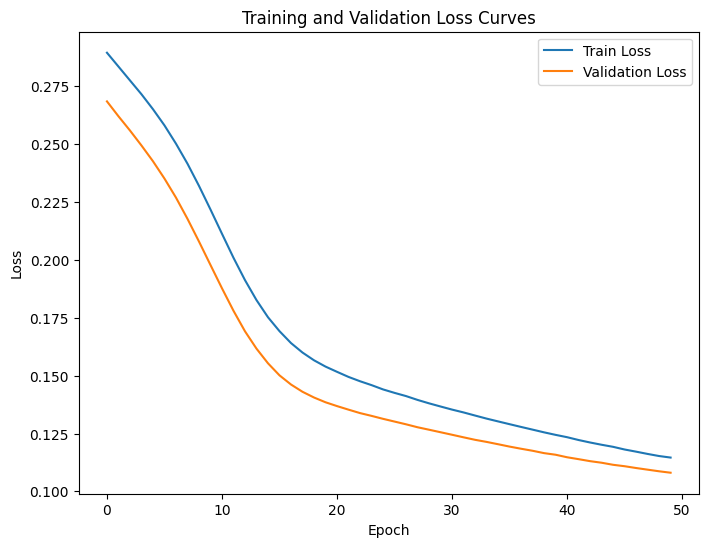

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-46-43.png
Test samples (avg ensemble):
Sample   0: Pred=0.9346, True=2.4654
Sample   1: Pred=0.0998, True=0.1334
Sample   2: Pred=0.5111, True=1.2167
Sample   3: Pred=0.9319, True=1.1593
Sample   4: Pred=0.1526, True=0.1802
Sample   5: Pred=0.3185, True=0.0600
Sample   6: Pred=1.6353, True=1.7800
Sample   7: Pred=1.4088, True=4.3986
Sample   8: Pred=0.5093, True=0.4696
Sample   9: Pred=0.0486, True=0.1055
Sample  10: Pred=0.9624, True=0.6503
Sample  11: Pred=0.5136, True=0.1610
Sample  12: Pred=0.4756, True=0.1694
Sample  13: Pred=0.3448, True=0.5143
Sample  14: Pred=1.6271, True=2.1430
Sample  15: Pred=0.2018, True=0.2603
Sample  16: Pred=1.2910, True=0.8442
Sample  17: Pred=0.1385, True=0.1382
Sample  18: Pred=1.0553, True=2.9576
Sample  19: Pred=2.5739, True=8.0533
Sample  20: Pred=0.3164, True=0.2522
Sample  21: Pred=0.0289, True=0.0144
Sample  22: Pred=1.7653, True=1.2707
Sample  23: Pred=0.8208, True=1

[INFO 03-23 15:46:53] ax.service.managed_loop: Running optimization trial 9...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

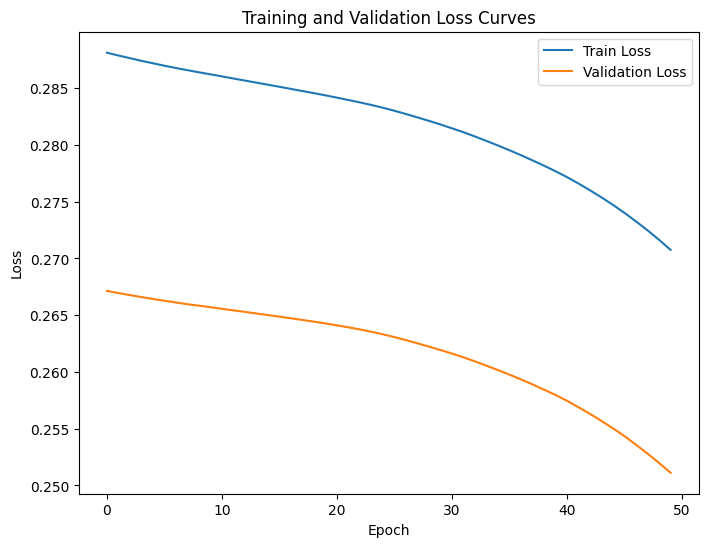

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-46-53.png
Test samples (avg ensemble):
Sample   0: Pred=0.4059, True=2.4654
Sample   1: Pred=0.3604, True=0.1334
Sample   2: Pred=0.4052, True=1.2167
Sample   3: Pred=0.3979, True=1.1593
Sample   4: Pred=0.3387, True=0.1802
Sample   5: Pred=0.3943, True=0.0600
Sample   6: Pred=0.4032, True=1.7800
Sample   7: Pred=0.4182, True=4.3986
Sample   8: Pred=0.3890, True=0.4696
Sample   9: Pred=0.3281, True=0.1055
Sample  10: Pred=0.4244, True=0.6503
Sample  11: Pred=0.3939, True=0.1610
Sample  12: Pred=0.3751, True=0.1694
Sample  13: Pred=0.4168, True=0.5143
Sample  14: Pred=0.4020, True=2.1430
Sample  15: Pred=0.3685, True=0.2603
Sample  16: Pred=0.4110, True=0.8442
Sample  17: Pred=0.3526, True=0.1382
Sample  18: Pred=0.4114, True=2.9576
Sample  19: Pred=0.4206, True=8.0533
Sample  20: Pred=0.4083, True=0.2522
Sample  21: Pred=0.3192, True=0.0144
Sample  22: Pred=0.4059, True=1.2707
Sample  23: Pred=0.4088, True=1

[INFO 03-23 15:47:12] ax.service.managed_loop: Running optimization trial 10...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

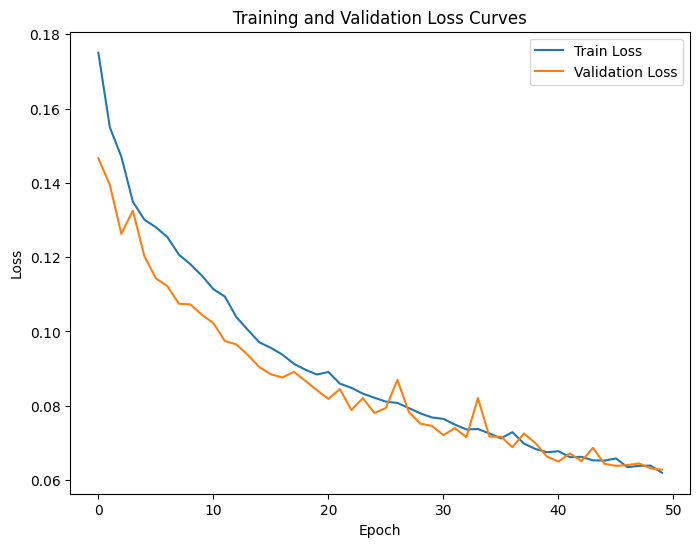

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-47-12.png
Test samples (avg ensemble):
Sample   0: Pred=1.3881, True=2.4654
Sample   1: Pred=0.1196, True=0.1334
Sample   2: Pred=0.6943, True=1.2167
Sample   3: Pred=1.0059, True=1.1593
Sample   4: Pred=0.2331, True=0.1802
Sample   5: Pred=0.0533, True=0.0600
Sample   6: Pred=13.1142, True=1.7800
Sample   7: Pred=0.8307, True=4.3986
Sample   8: Pred=0.6840, True=0.4696
Sample   9: Pred=0.1426, True=0.1055
Sample  10: Pred=0.4301, True=0.6503
Sample  11: Pred=0.7815, True=0.1610
Sample  12: Pred=0.2738, True=0.1694
Sample  13: Pred=0.3584, True=0.5143
Sample  14: Pred=3.6792, True=2.1430
Sample  15: Pred=0.2562, True=0.2603
Sample  16: Pred=0.6782, True=0.8442
Sample  17: Pred=0.1034, True=0.1382
Sample  18: Pred=0.9415, True=2.9576
Sample  19: Pred=2.5300, True=8.0533
Sample  20: Pred=0.3244, True=0.2522
Sample  21: Pred=0.0220, True=0.0144
Sample  22: Pred=2.3164, True=1.2707
Sample  23: Pred=1.3899, True=

[INFO 03-23 15:47:53] ax.service.managed_loop: Running optimization trial 11...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

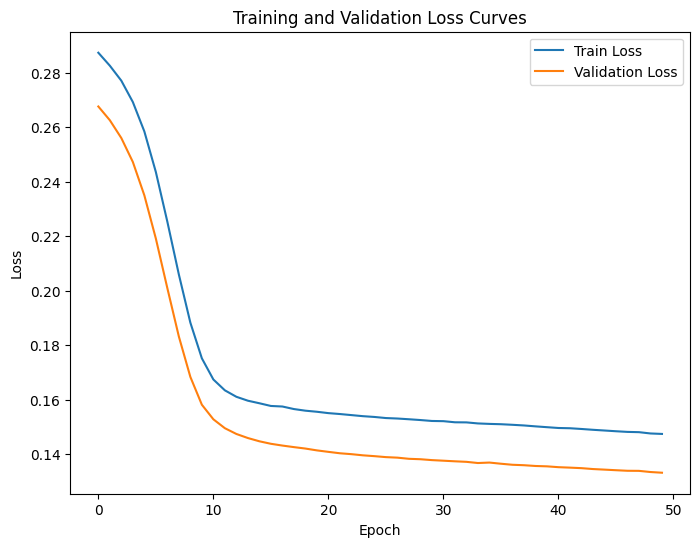

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-47-53.png
Test samples (avg ensemble):
Sample   0: Pred=0.5442, True=2.4654
Sample   1: Pred=0.0789, True=0.1334
Sample   2: Pred=0.7724, True=1.2167
Sample   3: Pred=1.0500, True=1.1593
Sample   4: Pred=0.0652, True=0.1802
Sample   5: Pred=0.2882, True=0.0600
Sample   6: Pred=2.0636, True=1.7800
Sample   7: Pred=1.7637, True=4.3986
Sample   8: Pred=0.3930, True=0.4696
Sample   9: Pred=0.0571, True=0.1055
Sample  10: Pred=1.5257, True=0.6503
Sample  11: Pred=0.3675, True=0.1610
Sample  12: Pred=0.3305, True=0.1694
Sample  13: Pred=0.4511, True=0.5143
Sample  14: Pred=1.3063, True=2.1430
Sample  15: Pred=0.1383, True=0.2603
Sample  16: Pred=1.2332, True=0.8442
Sample  17: Pred=0.0949, True=0.1382
Sample  18: Pred=1.3348, True=2.9576
Sample  19: Pred=2.0220, True=8.0533
Sample  20: Pred=0.5286, True=0.2522
Sample  21: Pred=0.0344, True=0.0144
Sample  22: Pred=1.2855, True=1.2707
Sample  23: Pred=0.7906, True=1

[INFO 03-23 15:48:09] ax.service.managed_loop: Running optimization trial 12...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

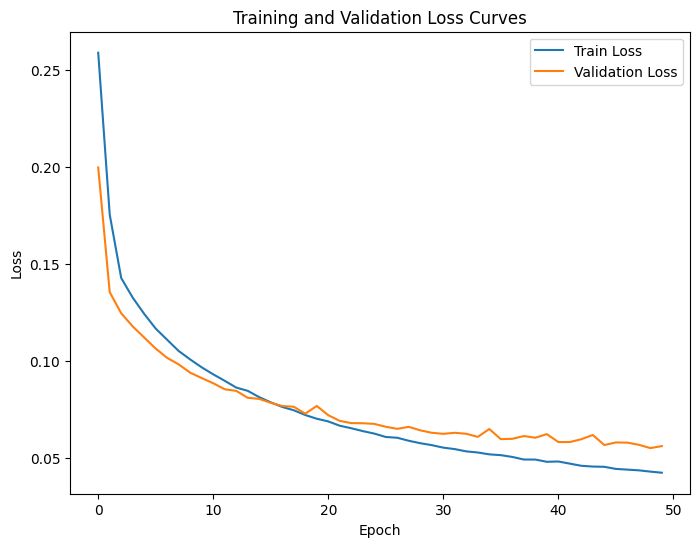

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-48-09.png
Test samples (avg ensemble):
Sample   0: Pred=1.8184, True=2.4654
Sample   1: Pred=0.0655, True=0.1334
Sample   2: Pred=0.7819, True=1.2167
Sample   3: Pred=0.7814, True=1.1593
Sample   4: Pred=0.2902, True=0.1802
Sample   5: Pred=0.0475, True=0.0600
Sample   6: Pred=8.6698, True=1.7800
Sample   7: Pred=0.8277, True=4.3986
Sample   8: Pred=0.6631, True=0.4696
Sample   9: Pred=0.0856, True=0.1055
Sample  10: Pred=0.5465, True=0.6503
Sample  11: Pred=0.8283, True=0.1610
Sample  12: Pred=0.6258, True=0.1694
Sample  13: Pred=0.3184, True=0.5143
Sample  14: Pred=1.9644, True=2.1430
Sample  15: Pred=0.1920, True=0.2603
Sample  16: Pred=0.9809, True=0.8442
Sample  17: Pred=0.1004, True=0.1382
Sample  18: Pred=0.7684, True=2.9576
Sample  19: Pred=2.9678, True=8.0533
Sample  20: Pred=0.3102, True=0.2522
Sample  21: Pred=0.0384, True=0.0144
Sample  22: Pred=2.8023, True=1.2707
Sample  23: Pred=1.5812, True=1

[INFO 03-23 15:48:59] ax.service.managed_loop: Running optimization trial 13...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 3
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

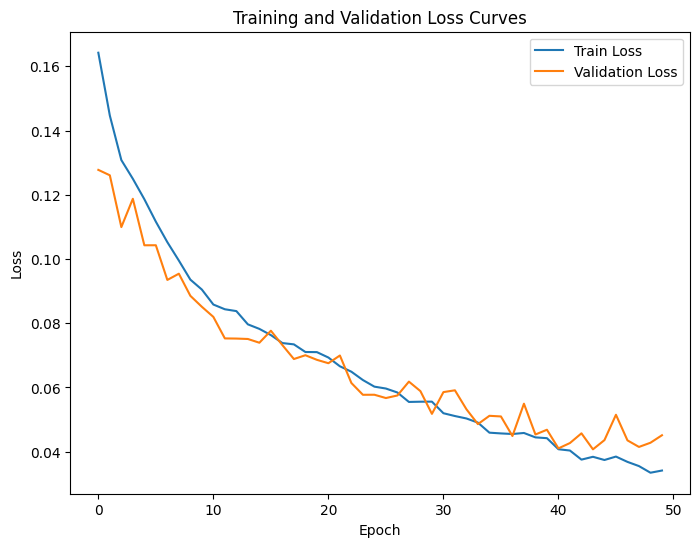

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-49-01.png
Test samples (avg ensemble):
Sample   0: Pred=1.7888, True=2.4654
Sample   1: Pred=0.0898, True=0.1334
Sample   2: Pred=0.9823, True=1.2167
Sample   3: Pred=0.6196, True=1.1593
Sample   4: Pred=0.2183, True=0.1802
Sample   5: Pred=0.0511, True=0.0600
Sample   6: Pred=24.3093, True=1.7800
Sample   7: Pred=3.9235, True=4.3986
Sample   8: Pred=0.6830, True=0.4696
Sample   9: Pred=0.0908, True=0.1055
Sample  10: Pred=0.4646, True=0.6503
Sample  11: Pred=1.3250, True=0.1610
Sample  12: Pred=0.8621, True=0.1694
Sample  13: Pred=0.1728, True=0.5143
Sample  14: Pred=2.4265, True=2.1430
Sample  15: Pred=0.2261, True=0.2603
Sample  16: Pred=1.1636, True=0.8442
Sample  17: Pred=0.1064, True=0.1382
Sample  18: Pred=0.5776, True=2.9576
Sample  19: Pred=5.6406, True=8.0533
Sample  20: Pred=0.2342, True=0.2522
Sample  21: Pred=0.0129, True=0.0144
Sample  22: Pred=1.0111, True=1.2707
Sample  23: Pred=2.8225, True=

[INFO 03-23 15:50:05] ax.service.managed_loop: Running optimization trial 14...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 0
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

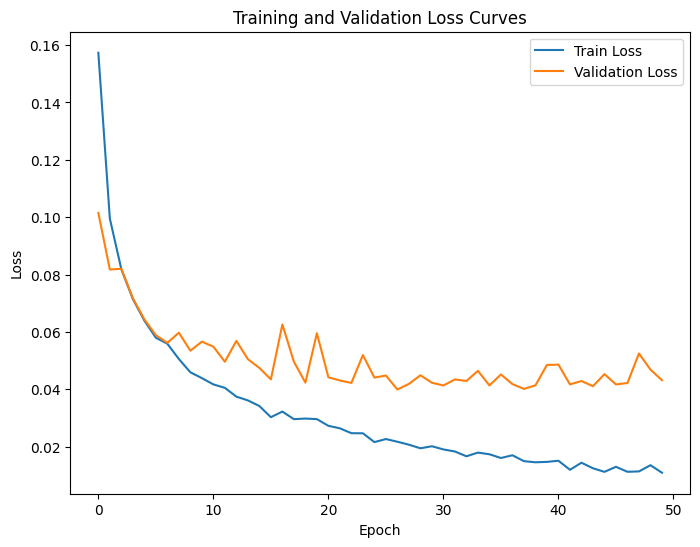

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-50-10.png
Test samples (avg ensemble):
Sample   0: Pred=2.0908, True=2.4654
Sample   1: Pred=0.1158, True=0.1334
Sample   2: Pred=3.8887, True=1.2167
Sample   3: Pred=0.6546, True=1.1593
Sample   4: Pred=0.1950, True=0.1802
Sample   5: Pred=0.0673, True=0.0600
Sample   6: Pred=7.2132, True=1.7800
Sample   7: Pred=3.3909, True=4.3986
Sample   8: Pred=0.4628, True=0.4696
Sample   9: Pred=0.1130, True=0.1055
Sample  10: Pred=0.6346, True=0.6503
Sample  11: Pred=0.3307, True=0.1610
Sample  12: Pred=0.2062, True=0.1694
Sample  13: Pred=0.2787, True=0.5143
Sample  14: Pred=1.9946, True=2.1430
Sample  15: Pred=0.2907, True=0.2603
Sample  16: Pred=0.8476, True=0.8442
Sample  17: Pred=0.1246, True=0.1382
Sample  18: Pred=0.9022, True=2.9576
Sample  19: Pred=1.4392, True=8.0533
Sample  20: Pred=0.2587, True=0.2522
Sample  21: Pred=0.0151, True=0.0144
Sample  22: Pred=0.5963, True=1.2707
Sample  23: Pred=5.2753, True=1

[INFO 03-23 15:52:22] ax.service.managed_loop: Running optimization trial 15...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

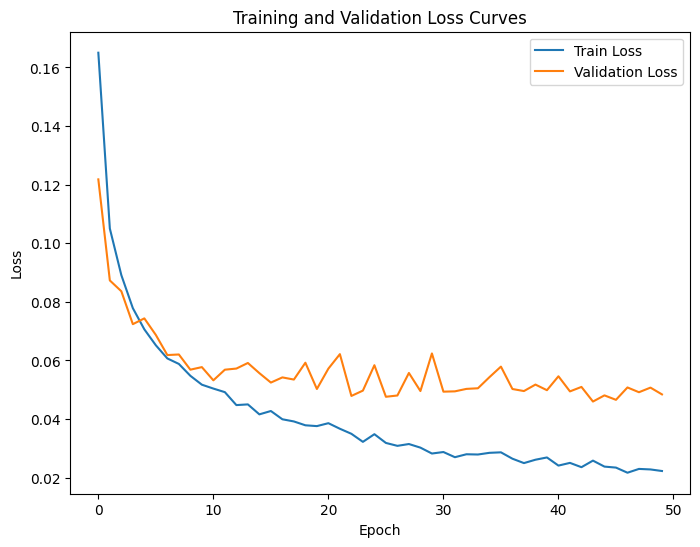

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-52-24.png
Test samples (avg ensemble):
Sample   0: Pred=2.4434, True=2.4654
Sample   1: Pred=0.1142, True=0.1334
Sample   2: Pred=3.0619, True=1.2167
Sample   3: Pred=0.9581, True=1.1593
Sample   4: Pred=0.1075, True=0.1802
Sample   5: Pred=0.0404, True=0.0600
Sample   6: Pred=13.3147, True=1.7800
Sample   7: Pred=2.0062, True=4.3986
Sample   8: Pred=0.4818, True=0.4696
Sample   9: Pred=0.0580, True=0.1055
Sample  10: Pred=0.4913, True=0.6503
Sample  11: Pred=0.6353, True=0.1610
Sample  12: Pred=0.4595, True=0.1694
Sample  13: Pred=0.3341, True=0.5143
Sample  14: Pred=2.3724, True=2.1430
Sample  15: Pred=0.2151, True=0.2603
Sample  16: Pred=1.0326, True=0.8442
Sample  17: Pred=0.1647, True=0.1382
Sample  18: Pred=0.6110, True=2.9576
Sample  19: Pred=3.7915, True=8.0533
Sample  20: Pred=0.2022, True=0.2522
Sample  21: Pred=0.0125, True=0.0144
Sample  22: Pred=1.5484, True=1.2707
Sample  23: Pred=4.8506, True=

[INFO 03-23 15:54:15] ax.service.managed_loop: Running optimization trial 16...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

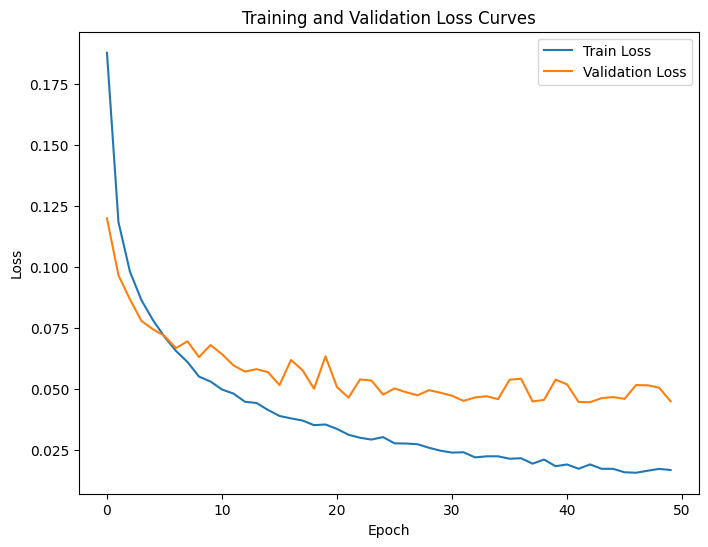

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-54-17.png
Test samples (avg ensemble):
Sample   0: Pred=2.1832, True=2.4654
Sample   1: Pred=0.1315, True=0.1334
Sample   2: Pred=5.7044, True=1.2167
Sample   3: Pred=0.7494, True=1.1593
Sample   4: Pred=0.2731, True=0.1802
Sample   5: Pred=0.0462, True=0.0600
Sample   6: Pred=11.9740, True=1.7800
Sample   7: Pred=0.9055, True=4.3986
Sample   8: Pred=0.4846, True=0.4696
Sample   9: Pred=0.1166, True=0.1055
Sample  10: Pred=0.5615, True=0.6503
Sample  11: Pred=0.5977, True=0.1610
Sample  12: Pred=0.3805, True=0.1694
Sample  13: Pred=0.3716, True=0.5143
Sample  14: Pred=2.0641, True=2.1430
Sample  15: Pred=0.2263, True=0.2603
Sample  16: Pred=1.0907, True=0.8442
Sample  17: Pred=0.1334, True=0.1382
Sample  18: Pred=0.8065, True=2.9576
Sample  19: Pred=1.1723, True=8.0533
Sample  20: Pred=0.2756, True=0.2522
Sample  21: Pred=0.0206, True=0.0144
Sample  22: Pred=0.7533, True=1.2707
Sample  23: Pred=5.0367, True=

[INFO 03-23 15:56:36] ax.service.managed_loop: Running optimization trial 17...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 3
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

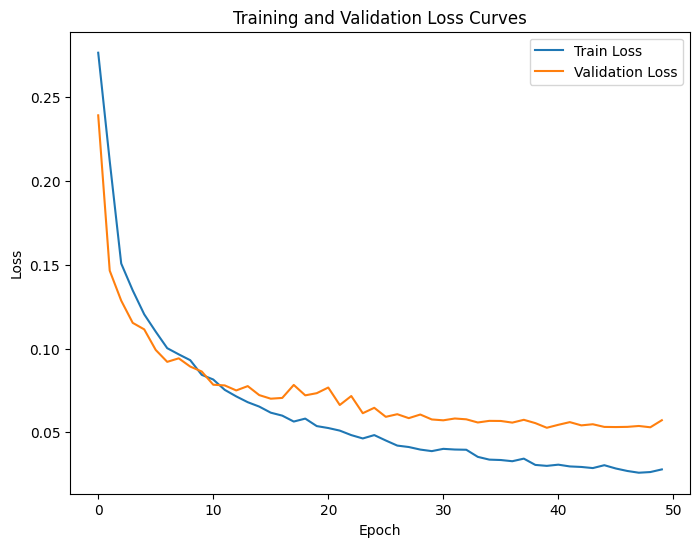

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-56-38.png
Test samples (avg ensemble):
Sample   0: Pred=1.7262, True=2.4654
Sample   1: Pred=0.0957, True=0.1334
Sample   2: Pred=1.4316, True=1.2167
Sample   3: Pred=0.7724, True=1.1593
Sample   4: Pred=0.1724, True=0.1802
Sample   5: Pred=0.0575, True=0.0600
Sample   6: Pred=11.2402, True=1.7800
Sample   7: Pred=0.6369, True=4.3986
Sample   8: Pred=0.4283, True=0.4696
Sample   9: Pred=0.0866, True=0.1055
Sample  10: Pred=0.3447, True=0.6503
Sample  11: Pred=0.6373, True=0.1610
Sample  12: Pred=0.2479, True=0.1694
Sample  13: Pred=0.3278, True=0.5143
Sample  14: Pred=1.8838, True=2.1430
Sample  15: Pred=0.1467, True=0.2603
Sample  16: Pred=0.7422, True=0.8442
Sample  17: Pred=0.0621, True=0.1382
Sample  18: Pred=0.4123, True=2.9576
Sample  19: Pred=1.8949, True=8.0533
Sample  20: Pred=0.2470, True=0.2522
Sample  21: Pred=0.0135, True=0.0144
Sample  22: Pred=1.2524, True=1.2707
Sample  23: Pred=1.5922, True=

[INFO 03-23 15:56:51] ax.service.managed_loop: Running optimization trial 18...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

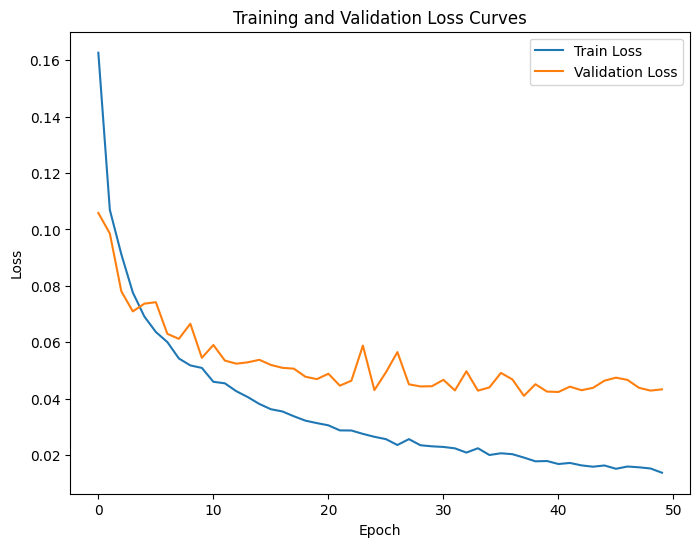

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-56-53.png
Test samples (avg ensemble):
Sample   0: Pred=2.0350, True=2.4654
Sample   1: Pred=0.1749, True=0.1334
Sample   2: Pred=5.3081, True=1.2167
Sample   3: Pred=0.8076, True=1.1593
Sample   4: Pred=0.2827, True=0.1802
Sample   5: Pred=0.0587, True=0.0600
Sample   6: Pred=13.8014, True=1.7800
Sample   7: Pred=1.4849, True=4.3986
Sample   8: Pred=0.5220, True=0.4696
Sample   9: Pred=0.1074, True=0.1055
Sample  10: Pred=0.7316, True=0.6503
Sample  11: Pred=0.6269, True=0.1610
Sample  12: Pred=0.2254, True=0.1694
Sample  13: Pred=0.3828, True=0.5143
Sample  14: Pred=2.6598, True=2.1430
Sample  15: Pred=0.2609, True=0.2603
Sample  16: Pred=1.0082, True=0.8442
Sample  17: Pred=0.1513, True=0.1382
Sample  18: Pred=0.8810, True=2.9576
Sample  19: Pred=1.1780, True=8.0533
Sample  20: Pred=0.2661, True=0.2522
Sample  21: Pred=0.0208, True=0.0144
Sample  22: Pred=0.7335, True=1.2707
Sample  23: Pred=1.9576, True=

[INFO 03-23 15:58:31] ax.service.managed_loop: Running optimization trial 19...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

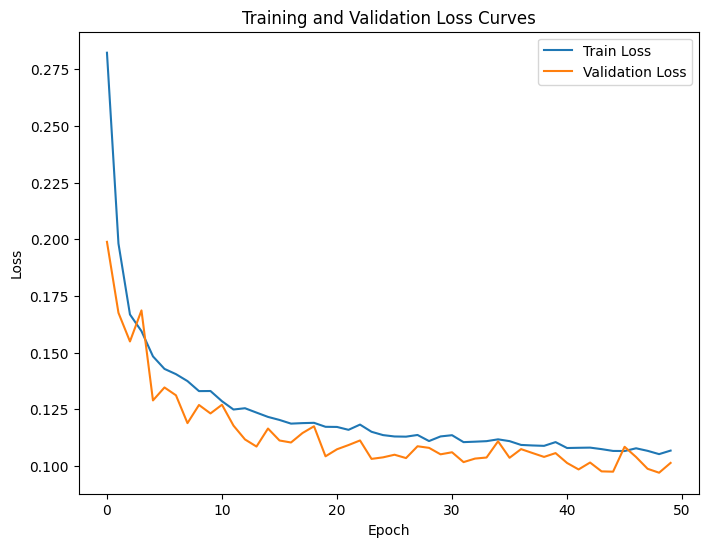

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-15-58-32.png
Test samples (avg ensemble):
Sample   0: Pred=1.0516, True=2.4654
Sample   1: Pred=0.0465, True=0.1334
Sample   2: Pred=0.6275, True=1.2167
Sample   3: Pred=0.9358, True=1.1593
Sample   4: Pred=0.1436, True=0.1802
Sample   5: Pred=0.0531, True=0.0600
Sample   6: Pred=4.9001, True=1.7800
Sample   7: Pred=1.1623, True=4.3986
Sample   8: Pred=1.1389, True=0.4696
Sample   9: Pred=0.0544, True=0.1055
Sample  10: Pred=0.3643, True=0.6503
Sample  11: Pred=0.6871, True=0.1610
Sample  12: Pred=0.6232, True=0.1694
Sample  13: Pred=0.2547, True=0.5143
Sample  14: Pred=2.9816, True=2.1430
Sample  15: Pred=0.1247, True=0.2603
Sample  16: Pred=1.3839, True=0.8442
Sample  17: Pred=0.0792, True=0.1382
Sample  18: Pred=1.3732, True=2.9576
Sample  19: Pred=4.5663, True=8.0533
Sample  20: Pred=0.2893, True=0.2522
Sample  21: Pred=0.0274, True=0.0144
Sample  22: Pred=2.7904, True=1.2707
Sample  23: Pred=1.0234, True=1

[INFO 03-23 16:00:42] ax.service.managed_loop: Running optimization trial 20...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 3
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

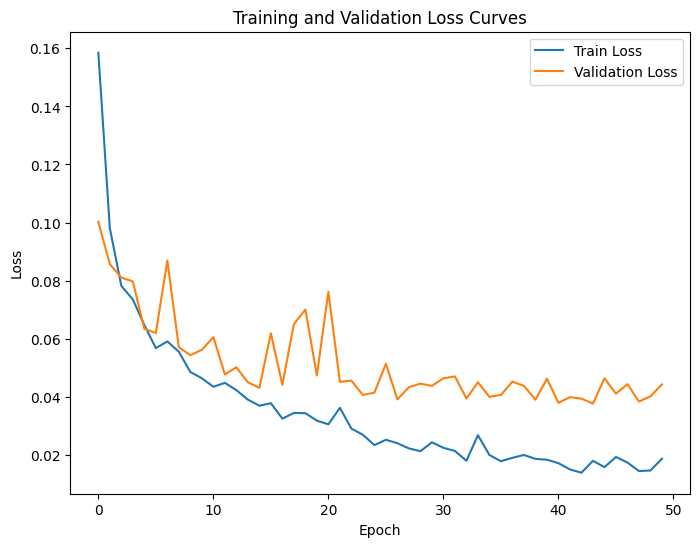

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-00-44.png
Test samples (avg ensemble):
Sample   0: Pred=2.1685, True=2.4654
Sample   1: Pred=0.1155, True=0.1334
Sample   2: Pred=2.9502, True=1.2167
Sample   3: Pred=0.5256, True=1.1593
Sample   4: Pred=0.2234, True=0.1802
Sample   5: Pred=0.0529, True=0.0600
Sample   6: Pred=7.3963, True=1.7800
Sample   7: Pred=3.2504, True=4.3986
Sample   8: Pred=0.4235, True=0.4696
Sample   9: Pred=0.1258, True=0.1055
Sample  10: Pred=0.6273, True=0.6503
Sample  11: Pred=0.5339, True=0.1610
Sample  12: Pred=0.5825, True=0.1694
Sample  13: Pred=0.2805, True=0.5143
Sample  14: Pred=2.4048, True=2.1430
Sample  15: Pred=0.1772, True=0.2603
Sample  16: Pred=0.8200, True=0.8442
Sample  17: Pred=0.1329, True=0.1382
Sample  18: Pred=0.9897, True=2.9576
Sample  19: Pred=2.3367, True=8.0533
Sample  20: Pred=0.2600, True=0.2522
Sample  21: Pred=0.0229, True=0.0144
Sample  22: Pred=1.3856, True=1.2707
Sample  23: Pred=6.7317, True=1

[INFO 03-23 16:01:54] ax.service.managed_loop: Running optimization trial 21...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

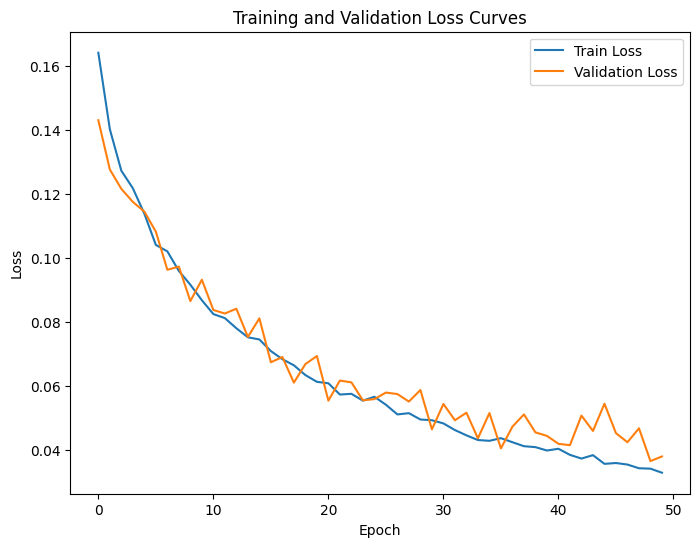

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-01-55.png
Test samples (avg ensemble):
Sample   0: Pred=1.4191, True=2.4654
Sample   1: Pred=0.1294, True=0.1334
Sample   2: Pred=1.1151, True=1.2167
Sample   3: Pred=0.6208, True=1.1593
Sample   4: Pred=0.1772, True=0.1802
Sample   5: Pred=0.0450, True=0.0600
Sample   6: Pred=9.3176, True=1.7800
Sample   7: Pred=1.0531, True=4.3986
Sample   8: Pred=0.3388, True=0.4696
Sample   9: Pred=0.0799, True=0.1055
Sample  10: Pred=0.6735, True=0.6503
Sample  11: Pred=0.6165, True=0.1610
Sample  12: Pred=0.5478, True=0.1694
Sample  13: Pred=0.3011, True=0.5143
Sample  14: Pred=2.0665, True=2.1430
Sample  15: Pred=0.2000, True=0.2603
Sample  16: Pred=0.7915, True=0.8442
Sample  17: Pred=0.1143, True=0.1382
Sample  18: Pred=0.6675, True=2.9576
Sample  19: Pred=3.4394, True=8.0533
Sample  20: Pred=0.2930, True=0.2522
Sample  21: Pred=0.0119, True=0.0144
Sample  22: Pred=0.7785, True=1.2707
Sample  23: Pred=2.7594, True=1

[INFO 03-23 16:03:58] ax.service.managed_loop: Running optimization trial 22...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

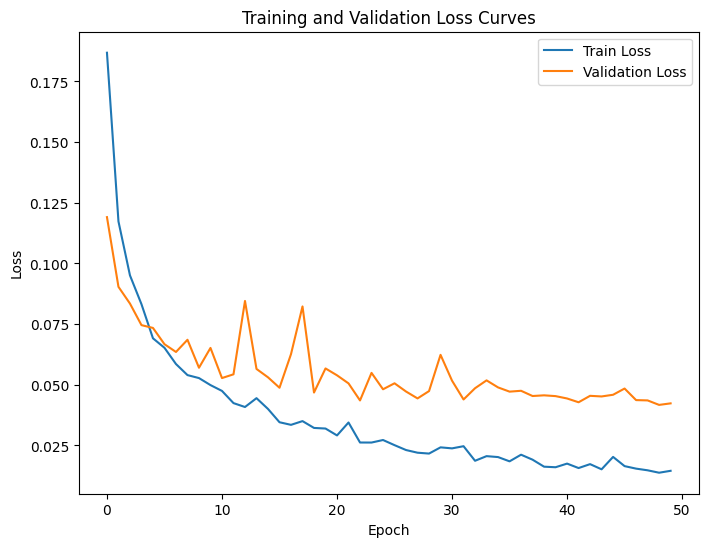

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-04-00.png
Test samples (avg ensemble):
Sample   0: Pred=1.9655, True=2.4654
Sample   1: Pred=0.1320, True=0.1334
Sample   2: Pred=4.4243, True=1.2167
Sample   3: Pred=1.0216, True=1.1593
Sample   4: Pred=0.1898, True=0.1802
Sample   5: Pred=0.0648, True=0.0600
Sample   6: Pred=7.3838, True=1.7800
Sample   7: Pred=2.1334, True=4.3986
Sample   8: Pred=0.5837, True=0.4696
Sample   9: Pred=0.1109, True=0.1055
Sample  10: Pred=0.6473, True=0.6503
Sample  11: Pred=0.5664, True=0.1610
Sample  12: Pred=0.3529, True=0.1694
Sample  13: Pred=0.3284, True=0.5143
Sample  14: Pred=2.0625, True=2.1430
Sample  15: Pred=0.2102, True=0.2603
Sample  16: Pred=0.9767, True=0.8442
Sample  17: Pred=0.1278, True=0.1382
Sample  18: Pred=0.7306, True=2.9576
Sample  19: Pred=1.3688, True=8.0533
Sample  20: Pred=0.2604, True=0.2522
Sample  21: Pred=0.0159, True=0.0144
Sample  22: Pred=0.8919, True=1.2707
Sample  23: Pred=3.7846, True=1

[INFO 03-23 16:04:36] ax.service.managed_loop: Running optimization trial 23...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

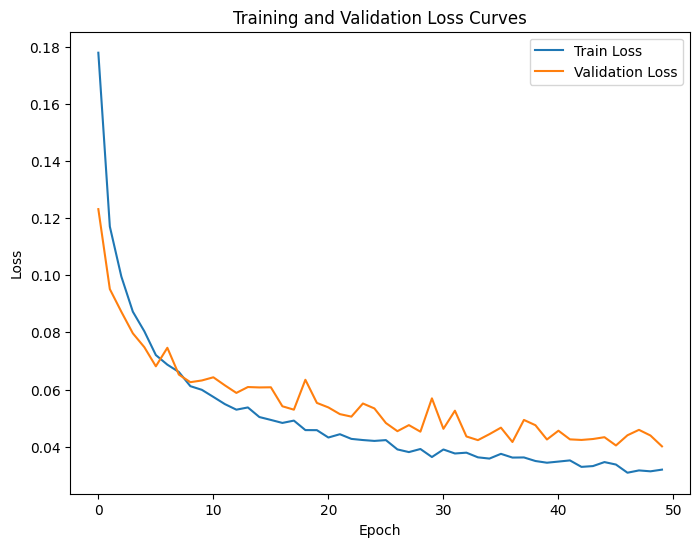

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-04-38.png
Test samples (avg ensemble):
Sample   0: Pred=1.6861, True=2.4654
Sample   1: Pred=0.0850, True=0.1334
Sample   2: Pred=1.4312, True=1.2167
Sample   3: Pred=0.8420, True=1.1593
Sample   4: Pred=0.1778, True=0.1802
Sample   5: Pred=0.0427, True=0.0600
Sample   6: Pred=6.4652, True=1.7800
Sample   7: Pred=1.6542, True=4.3986
Sample   8: Pred=0.5018, True=0.4696
Sample   9: Pred=0.0622, True=0.1055
Sample  10: Pred=0.6160, True=0.6503
Sample  11: Pred=1.3082, True=0.1610
Sample  12: Pred=0.8910, True=0.1694
Sample  13: Pred=0.3200, True=0.5143
Sample  14: Pred=1.7649, True=2.1430
Sample  15: Pred=0.1796, True=0.2603
Sample  16: Pred=0.8536, True=0.8442
Sample  17: Pred=0.1063, True=0.1382
Sample  18: Pred=0.9071, True=2.9576
Sample  19: Pred=2.2747, True=8.0533
Sample  20: Pred=0.2570, True=0.2522
Sample  21: Pred=0.0119, True=0.0144
Sample  22: Pred=0.9811, True=1.2707
Sample  23: Pred=2.2156, True=1

[INFO 03-23 16:06:13] ax.service.managed_loop: Running optimization trial 24...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

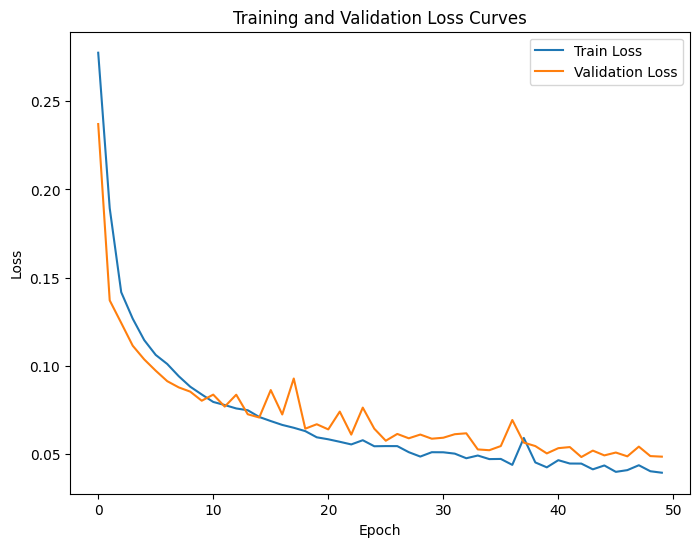

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-06-15.png
Test samples (avg ensemble):
Sample   0: Pred=0.8906, True=2.4654
Sample   1: Pred=0.1067, True=0.1334
Sample   2: Pred=0.7335, True=1.2167
Sample   3: Pred=0.5173, True=1.1593
Sample   4: Pred=0.1788, True=0.1802
Sample   5: Pred=0.0390, True=0.0600
Sample   6: Pred=9.7760, True=1.7800
Sample   7: Pred=0.6073, True=4.3986
Sample   8: Pred=0.5636, True=0.4696
Sample   9: Pred=0.0859, True=0.1055
Sample  10: Pred=0.4409, True=0.6503
Sample  11: Pred=0.4936, True=0.1610
Sample  12: Pred=0.7499, True=0.1694
Sample  13: Pred=0.2700, True=0.5143
Sample  14: Pred=1.4139, True=2.1430
Sample  15: Pred=0.2278, True=0.2603
Sample  16: Pred=0.7052, True=0.8442
Sample  17: Pred=0.1208, True=0.1382
Sample  18: Pred=1.0057, True=2.9576
Sample  19: Pred=2.5850, True=8.0533
Sample  20: Pred=0.2965, True=0.2522
Sample  21: Pred=0.0130, True=0.0144
Sample  22: Pred=1.3241, True=1.2707
Sample  23: Pred=1.9019, True=1

[INFO 03-23 16:06:36] ax.service.managed_loop: Running optimization trial 25...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

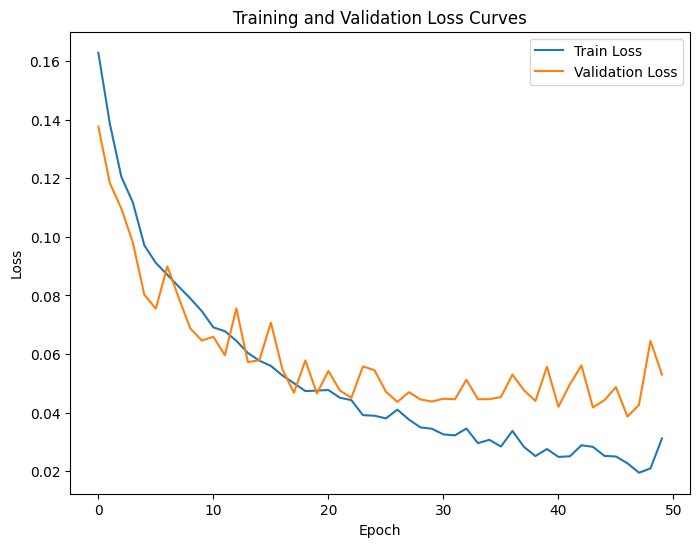

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-06-38.png
Test samples (avg ensemble):
Sample   0: Pred=2.3451, True=2.4654
Sample   1: Pred=0.1120, True=0.1334
Sample   2: Pred=8.0891, True=1.2167
Sample   3: Pred=1.1069, True=1.1593
Sample   4: Pred=0.1727, True=0.1802
Sample   5: Pred=0.0963, True=0.0600
Sample   6: Pred=7.9022, True=1.7800
Sample   7: Pred=2.7169, True=4.3986
Sample   8: Pred=0.4867, True=0.4696
Sample   9: Pred=0.0910, True=0.1055
Sample  10: Pred=0.5715, True=0.6503
Sample  11: Pred=2.4836, True=0.1610
Sample  12: Pred=0.3297, True=0.1694
Sample  13: Pred=0.3356, True=0.5143
Sample  14: Pred=2.0103, True=2.1430
Sample  15: Pred=0.1841, True=0.2603
Sample  16: Pred=0.4638, True=0.8442
Sample  17: Pred=0.1279, True=0.1382
Sample  18: Pred=0.8302, True=2.9576
Sample  19: Pred=2.9494, True=8.0533
Sample  20: Pred=0.2420, True=0.2522
Sample  21: Pred=0.0150, True=0.0144
Sample  22: Pred=1.1835, True=1.2707
Sample  23: Pred=4.9507, True=1

[INFO 03-23 16:08:34] ax.service.managed_loop: Running optimization trial 26...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

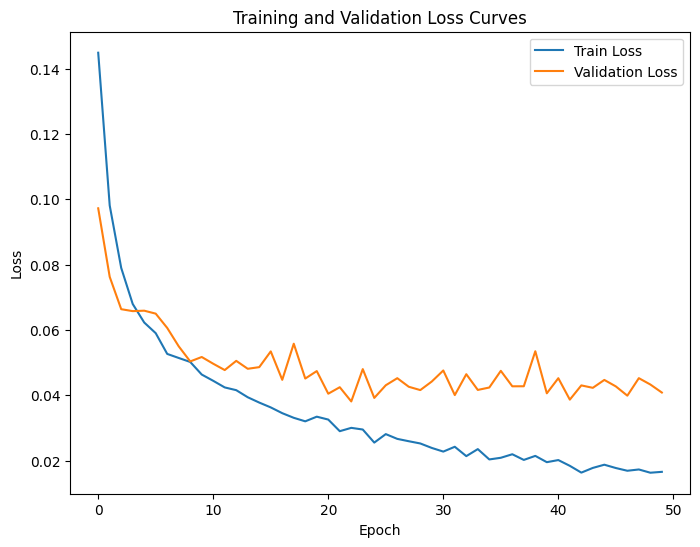

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-08-36.png
Test samples (avg ensemble):
Sample   0: Pred=2.5218, True=2.4654
Sample   1: Pred=0.0924, True=0.1334
Sample   2: Pred=18.6600, True=1.2167
Sample   3: Pred=0.9696, True=1.1593
Sample   4: Pred=0.2101, True=0.1802
Sample   5: Pred=0.0505, True=0.0600
Sample   6: Pred=10.7537, True=1.7800
Sample   7: Pred=2.4384, True=4.3986
Sample   8: Pred=0.4803, True=0.4696
Sample   9: Pred=0.0871, True=0.1055
Sample  10: Pred=0.6286, True=0.6503
Sample  11: Pred=0.5880, True=0.1610
Sample  12: Pred=0.4346, True=0.1694
Sample  13: Pred=0.3476, True=0.5143
Sample  14: Pred=2.5191, True=2.1430
Sample  15: Pred=0.2755, True=0.2603
Sample  16: Pred=1.1700, True=0.8442
Sample  17: Pred=0.0996, True=0.1382
Sample  18: Pred=0.6270, True=2.9576
Sample  19: Pred=2.4366, True=8.0533
Sample  20: Pred=0.2508, True=0.2522
Sample  21: Pred=0.0117, True=0.0144
Sample  22: Pred=0.4719, True=1.2707
Sample  23: Pred=4.4576, True

[INFO 03-23 16:10:09] ax.service.managed_loop: Running optimization trial 27...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 0
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

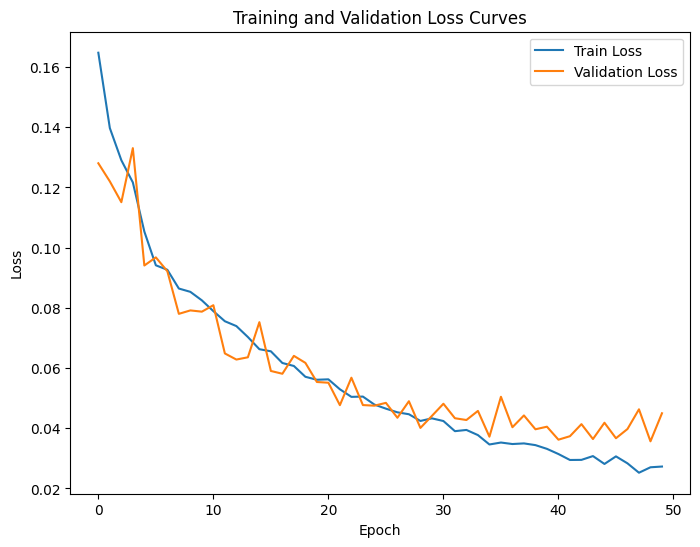

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-10-12.png
Test samples (avg ensemble):
Sample   0: Pred=1.7793, True=2.4654
Sample   1: Pred=0.1046, True=0.1334
Sample   2: Pred=2.2932, True=1.2167
Sample   3: Pred=1.4667, True=1.1593
Sample   4: Pred=0.1101, True=0.1802
Sample   5: Pred=0.0857, True=0.0600
Sample   6: Pred=21.5515, True=1.7800
Sample   7: Pred=3.1189, True=4.3986
Sample   8: Pred=0.4775, True=0.4696
Sample   9: Pred=0.0965, True=0.1055
Sample  10: Pred=0.6229, True=0.6503
Sample  11: Pred=0.3690, True=0.1610
Sample  12: Pred=0.5563, True=0.1694
Sample  13: Pred=0.2341, True=0.5143
Sample  14: Pred=1.7587, True=2.1430
Sample  15: Pred=0.1718, True=0.2603
Sample  16: Pred=0.7866, True=0.8442
Sample  17: Pred=0.1197, True=0.1382
Sample  18: Pred=0.7582, True=2.9576
Sample  19: Pred=5.1299, True=8.0533
Sample  20: Pred=0.2542, True=0.2522
Sample  21: Pred=0.0105, True=0.0144
Sample  22: Pred=1.3165, True=1.2707
Sample  23: Pred=3.1422, True=

[INFO 03-23 16:12:16] ax.service.managed_loop: Running optimization trial 28...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

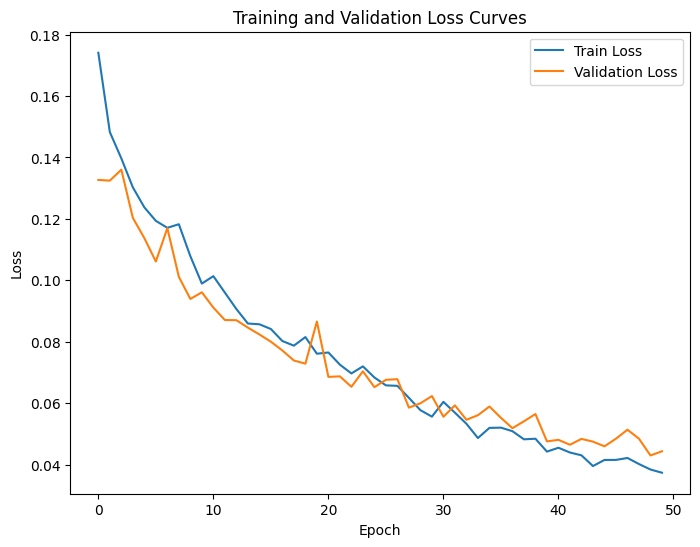

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-12-18.png
Test samples (avg ensemble):
Sample   0: Pred=1.2992, True=2.4654
Sample   1: Pred=0.0620, True=0.1334
Sample   2: Pred=0.6207, True=1.2167
Sample   3: Pred=0.9144, True=1.1593
Sample   4: Pred=0.2088, True=0.1802
Sample   5: Pred=0.0479, True=0.0600
Sample   6: Pred=18.8784, True=1.7800
Sample   7: Pred=1.2900, True=4.3986
Sample   8: Pred=0.5222, True=0.4696
Sample   9: Pred=0.1422, True=0.1055
Sample  10: Pred=0.7446, True=0.6503
Sample  11: Pred=0.6880, True=0.1610
Sample  12: Pred=0.4721, True=0.1694
Sample  13: Pred=0.1994, True=0.5143
Sample  14: Pred=2.2160, True=2.1430
Sample  15: Pred=0.2758, True=0.2603
Sample  16: Pred=0.6333, True=0.8442
Sample  17: Pred=0.0865, True=0.1382
Sample  18: Pred=1.2220, True=2.9576
Sample  19: Pred=4.6382, True=8.0533
Sample  20: Pred=0.4085, True=0.2522
Sample  21: Pred=0.0190, True=0.0144
Sample  22: Pred=1.4495, True=1.2707
Sample  23: Pred=3.1691, True=

[INFO 03-23 16:12:31] ax.service.managed_loop: Running optimization trial 29...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 0
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

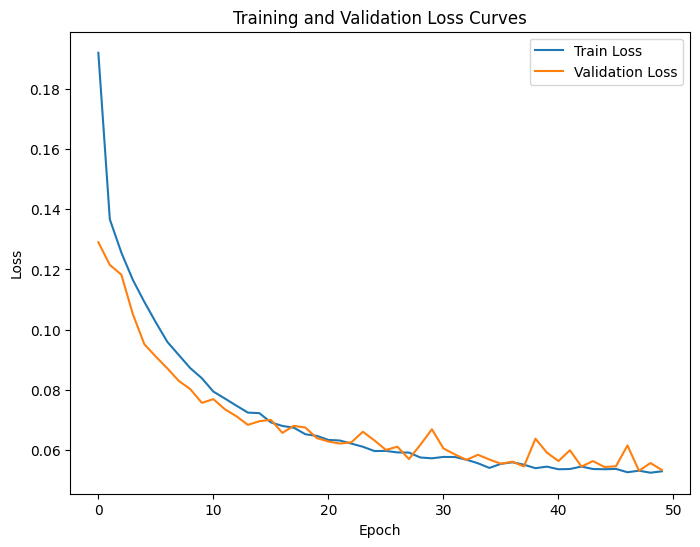

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-12-32.png
Test samples (avg ensemble):
Sample   0: Pred=1.7093, True=2.4654
Sample   1: Pred=0.0977, True=0.1334
Sample   2: Pred=0.5664, True=1.2167
Sample   3: Pred=0.7221, True=1.1593
Sample   4: Pred=0.1697, True=0.1802
Sample   5: Pred=0.0605, True=0.0600
Sample   6: Pred=11.0494, True=1.7800
Sample   7: Pred=0.8236, True=4.3986
Sample   8: Pred=0.6475, True=0.4696
Sample   9: Pred=0.1545, True=0.1055
Sample  10: Pred=0.5979, True=0.6503
Sample  11: Pred=1.1882, True=0.1610
Sample  12: Pred=0.6703, True=0.1694
Sample  13: Pred=0.1919, True=0.5143
Sample  14: Pred=3.3855, True=2.1430
Sample  15: Pred=0.2102, True=0.2603
Sample  16: Pred=0.8146, True=0.8442
Sample  17: Pred=0.1519, True=0.1382
Sample  18: Pred=1.0407, True=2.9576
Sample  19: Pred=3.7716, True=8.0533
Sample  20: Pred=0.2917, True=0.2522
Sample  21: Pred=0.0223, True=0.0144
Sample  22: Pred=3.0637, True=1.2707
Sample  23: Pred=1.3825, True=

[INFO 03-23 16:13:51] ax.service.managed_loop: Running optimization trial 30...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

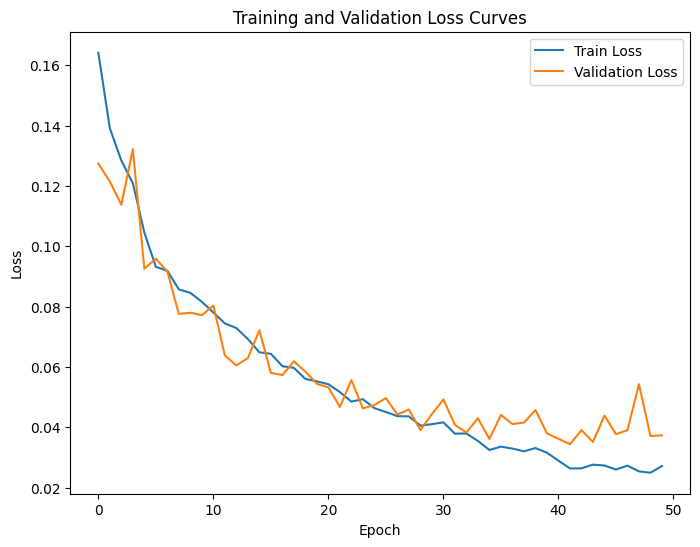

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-13-52.png
Test samples (avg ensemble):
Sample   0: Pred=1.9778, True=2.4654
Sample   1: Pred=0.1365, True=0.1334
Sample   2: Pred=1.6325, True=1.2167
Sample   3: Pred=1.2902, True=1.1593
Sample   4: Pred=0.1368, True=0.1802
Sample   5: Pred=0.0840, True=0.0600
Sample   6: Pred=12.6322, True=1.7800
Sample   7: Pred=0.8427, True=4.3986
Sample   8: Pred=0.4219, True=0.4696
Sample   9: Pred=0.0939, True=0.1055
Sample  10: Pred=0.6159, True=0.6503
Sample  11: Pred=0.3663, True=0.1610
Sample  12: Pred=0.5241, True=0.1694
Sample  13: Pred=0.2908, True=0.5143
Sample  14: Pred=1.8011, True=2.1430
Sample  15: Pred=0.2057, True=0.2603
Sample  16: Pred=0.8723, True=0.8442
Sample  17: Pred=0.1464, True=0.1382
Sample  18: Pred=0.7810, True=2.9576
Sample  19: Pred=2.2790, True=8.0533
Sample  20: Pred=0.2544, True=0.2522
Sample  21: Pred=0.0142, True=0.0144
Sample  22: Pred=1.0192, True=1.2707
Sample  23: Pred=4.0293, True=

[INFO 03-23 16:16:03] ax.service.managed_loop: Running optimization trial 31...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

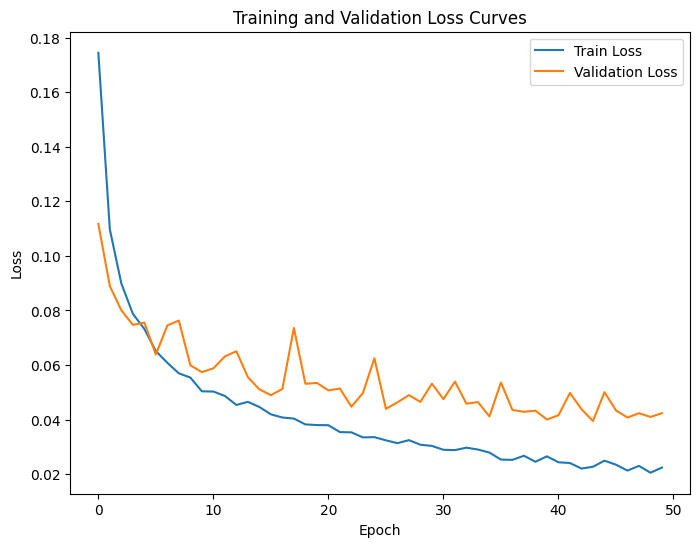

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-16-05.png
Test samples (avg ensemble):
Sample   0: Pred=2.8123, True=2.4654
Sample   1: Pred=0.0814, True=0.1334
Sample   2: Pred=3.7393, True=1.2167
Sample   3: Pred=1.3818, True=1.1593
Sample   4: Pred=0.2596, True=0.1802
Sample   5: Pred=0.1039, True=0.0600
Sample   6: Pred=3.9039, True=1.7800
Sample   7: Pred=1.7627, True=4.3986
Sample   8: Pred=0.6270, True=0.4696
Sample   9: Pred=0.1076, True=0.1055
Sample  10: Pred=0.6385, True=0.6503
Sample  11: Pred=0.6069, True=0.1610
Sample  12: Pred=0.3358, True=0.1694
Sample  13: Pred=0.2269, True=0.5143
Sample  14: Pred=2.8438, True=2.1430
Sample  15: Pred=0.1798, True=0.2603
Sample  16: Pred=0.7010, True=0.8442
Sample  17: Pred=0.1075, True=0.1382
Sample  18: Pred=0.4829, True=2.9576
Sample  19: Pred=3.2660, True=8.0533
Sample  20: Pred=0.2431, True=0.2522
Sample  21: Pred=0.0189, True=0.0144
Sample  22: Pred=0.8888, True=1.2707
Sample  23: Pred=2.8540, True=1

[INFO 03-23 16:17:55] ax.service.managed_loop: Running optimization trial 32...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

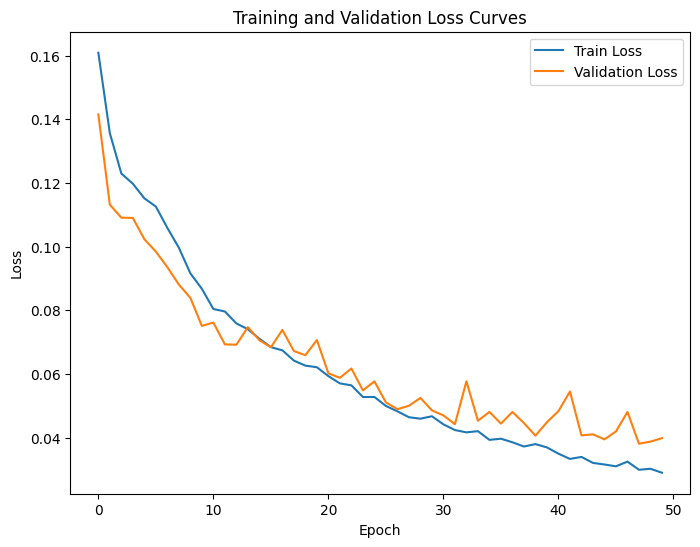

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-17-57.png
Test samples (avg ensemble):
Sample   0: Pred=1.3070, True=2.4654
Sample   1: Pred=0.0636, True=0.1334
Sample   2: Pred=1.2569, True=1.2167
Sample   3: Pred=0.8246, True=1.1593
Sample   4: Pred=0.2901, True=0.1802
Sample   5: Pred=0.0483, True=0.0600
Sample   6: Pred=4.5297, True=1.7800
Sample   7: Pred=0.9440, True=4.3986
Sample   8: Pred=0.3241, True=0.4696
Sample   9: Pred=0.1144, True=0.1055
Sample  10: Pred=0.4921, True=0.6503
Sample  11: Pred=0.6712, True=0.1610
Sample  12: Pred=0.3321, True=0.1694
Sample  13: Pred=0.2728, True=0.5143
Sample  14: Pred=2.1509, True=2.1430
Sample  15: Pred=0.1576, True=0.2603
Sample  16: Pred=0.6816, True=0.8442
Sample  17: Pred=0.1254, True=0.1382
Sample  18: Pred=1.3925, True=2.9576
Sample  19: Pred=2.1041, True=8.0533
Sample  20: Pred=0.2392, True=0.2522
Sample  21: Pred=0.0143, True=0.0144
Sample  22: Pred=0.5625, True=1.2707
Sample  23: Pred=2.7829, True=1

[INFO 03-23 16:19:26] ax.service.managed_loop: Running optimization trial 33...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

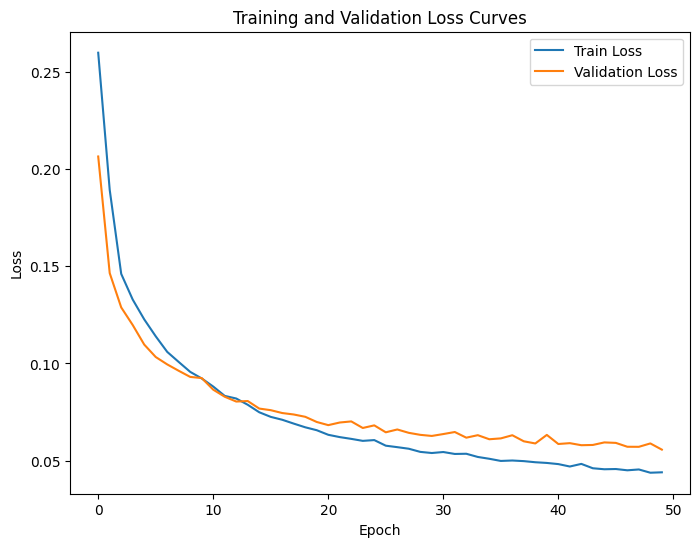

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-19-28.png
Test samples (avg ensemble):
Sample   0: Pred=1.7903, True=2.4654
Sample   1: Pred=0.1196, True=0.1334
Sample   2: Pred=0.7027, True=1.2167
Sample   3: Pred=0.6228, True=1.1593
Sample   4: Pred=0.1817, True=0.1802
Sample   5: Pred=0.0512, True=0.0600
Sample   6: Pred=11.8170, True=1.7800
Sample   7: Pred=0.6250, True=4.3986
Sample   8: Pred=0.8497, True=0.4696
Sample   9: Pred=0.0984, True=0.1055
Sample  10: Pred=0.4909, True=0.6503
Sample  11: Pred=0.6651, True=0.1610
Sample  12: Pred=0.4380, True=0.1694
Sample  13: Pred=0.3885, True=0.5143
Sample  14: Pred=2.6470, True=2.1430
Sample  15: Pred=0.1880, True=0.2603
Sample  16: Pred=0.6261, True=0.8442
Sample  17: Pred=0.0848, True=0.1382
Sample  18: Pred=0.7036, True=2.9576
Sample  19: Pred=2.0891, True=8.0533
Sample  20: Pred=0.2318, True=0.2522
Sample  21: Pred=0.0187, True=0.0144
Sample  22: Pred=3.4053, True=1.2707
Sample  23: Pred=1.0766, True=

[INFO 03-23 16:19:36] ax.service.managed_loop: Running optimization trial 34...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

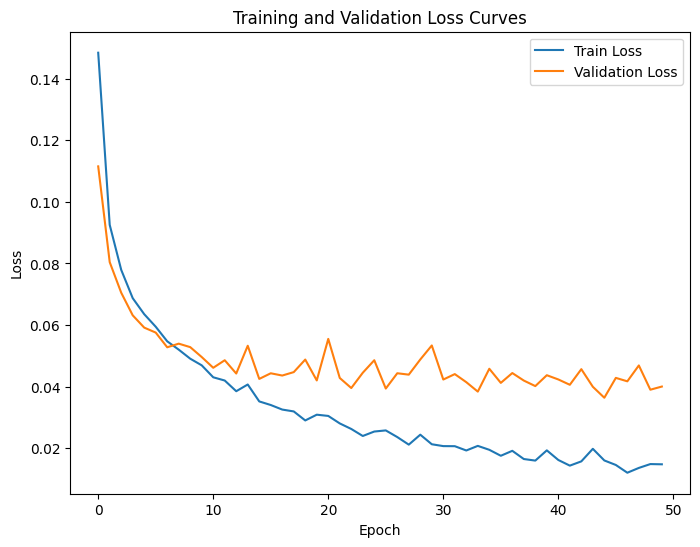

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-19-37.png
Test samples (avg ensemble):
Sample   0: Pred=2.2573, True=2.4654
Sample   1: Pred=0.0990, True=0.1334
Sample   2: Pred=4.5442, True=1.2167
Sample   3: Pred=1.2940, True=1.1593
Sample   4: Pred=0.2027, True=0.1802
Sample   5: Pred=0.0483, True=0.0600
Sample   6: Pred=10.6031, True=1.7800
Sample   7: Pred=2.7771, True=4.3986
Sample   8: Pred=0.6674, True=0.4696
Sample   9: Pred=0.0812, True=0.1055
Sample  10: Pred=0.6005, True=0.6503
Sample  11: Pred=0.4493, True=0.1610
Sample  12: Pred=0.5330, True=0.1694
Sample  13: Pred=0.4561, True=0.5143
Sample  14: Pred=2.6731, True=2.1430
Sample  15: Pred=0.3080, True=0.2603
Sample  16: Pred=1.0318, True=0.8442
Sample  17: Pred=0.1351, True=0.1382
Sample  18: Pred=0.5736, True=2.9576
Sample  19: Pred=2.2846, True=8.0533
Sample  20: Pred=0.2778, True=0.2522
Sample  21: Pred=0.0113, True=0.0144
Sample  22: Pred=1.5850, True=1.2707
Sample  23: Pred=4.0736, True=

[INFO 03-23 16:21:24] ax.service.managed_loop: Running optimization trial 35...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

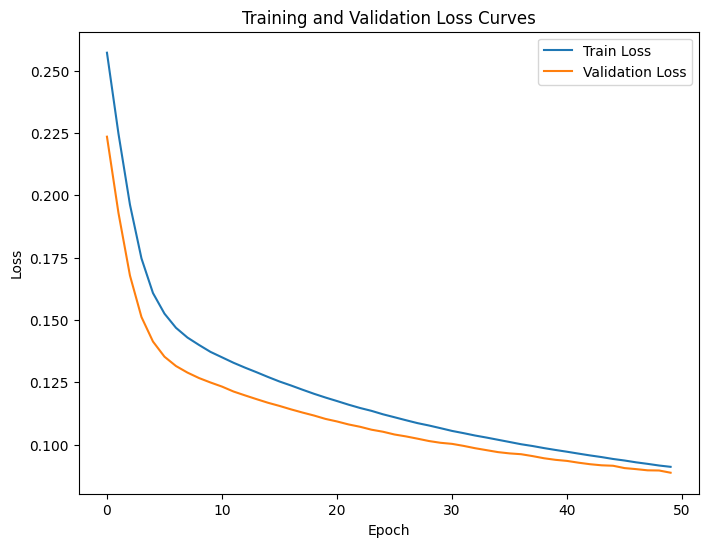

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-21-25.png
Test samples (avg ensemble):
Sample   0: Pred=0.8218, True=2.4654
Sample   1: Pred=0.0865, True=0.1334
Sample   2: Pred=0.5068, True=1.2167
Sample   3: Pred=0.7878, True=1.1593
Sample   4: Pred=0.1730, True=0.1802
Sample   5: Pred=0.2117, True=0.0600
Sample   6: Pred=2.3660, True=1.7800
Sample   7: Pred=1.1646, True=4.3986
Sample   8: Pred=0.5665, True=0.4696
Sample   9: Pred=0.0560, True=0.1055
Sample  10: Pred=0.6026, True=0.6503
Sample  11: Pred=0.5586, True=0.1610
Sample  12: Pred=0.4874, True=0.1694
Sample  13: Pred=0.2974, True=0.5143
Sample  14: Pred=1.8082, True=2.1430
Sample  15: Pred=0.2304, True=0.2603
Sample  16: Pred=1.0328, True=0.8442
Sample  17: Pred=0.1236, True=0.1382
Sample  18: Pred=1.0401, True=2.9576
Sample  19: Pred=2.6364, True=8.0533
Sample  20: Pred=0.2710, True=0.2522
Sample  21: Pred=0.0262, True=0.0144
Sample  22: Pred=1.9881, True=1.2707
Sample  23: Pred=0.7156, True=1

[INFO 03-23 16:22:39] ax.service.managed_loop: Running optimization trial 36...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

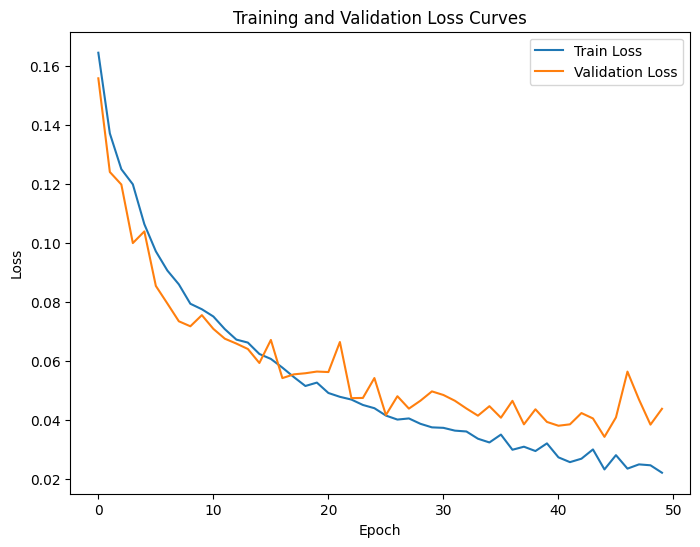

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-22-41.png
Test samples (avg ensemble):
Sample   0: Pred=2.7203, True=2.4654
Sample   1: Pred=0.1119, True=0.1334
Sample   2: Pred=2.5451, True=1.2167
Sample   3: Pred=1.5687, True=1.1593
Sample   4: Pred=0.1385, True=0.1802
Sample   5: Pred=0.0441, True=0.0600
Sample   6: Pred=19.3484, True=1.7800
Sample   7: Pred=7.0303, True=4.3986
Sample   8: Pred=0.5016, True=0.4696
Sample   9: Pred=0.1289, True=0.1055
Sample  10: Pred=0.7729, True=0.6503
Sample  11: Pred=0.8936, True=0.1610
Sample  12: Pred=0.5025, True=0.1694
Sample  13: Pred=0.4153, True=0.5143
Sample  14: Pred=2.2277, True=2.1430
Sample  15: Pred=0.2778, True=0.2603
Sample  16: Pred=1.7750, True=0.8442
Sample  17: Pred=0.1553, True=0.1382
Sample  18: Pred=0.7124, True=2.9576
Sample  19: Pred=2.0094, True=8.0533
Sample  20: Pred=0.2069, True=0.2522
Sample  21: Pred=0.0117, True=0.0144
Sample  22: Pred=0.8615, True=1.2707
Sample  23: Pred=2.6755, True=

[INFO 03-23 16:24:35] ax.service.managed_loop: Running optimization trial 37...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

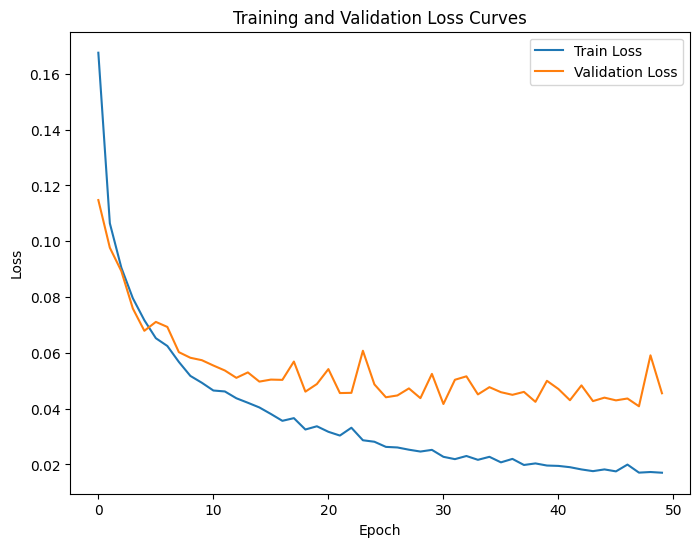

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-24-36.png
Test samples (avg ensemble):
Sample   0: Pred=3.0695, True=2.4654
Sample   1: Pred=0.1259, True=0.1334
Sample   2: Pred=8.2417, True=1.2167
Sample   3: Pred=0.9606, True=1.1593
Sample   4: Pred=0.1701, True=0.1802
Sample   5: Pred=0.0626, True=0.0600
Sample   6: Pred=6.9766, True=1.7800
Sample   7: Pred=1.0417, True=4.3986
Sample   8: Pred=0.6557, True=0.4696
Sample   9: Pred=0.0958, True=0.1055
Sample  10: Pred=0.5700, True=0.6503
Sample  11: Pred=0.9477, True=0.1610
Sample  12: Pred=0.2882, True=0.1694
Sample  13: Pred=0.3565, True=0.5143
Sample  14: Pred=2.6251, True=2.1430
Sample  15: Pred=0.3271, True=0.2603
Sample  16: Pred=1.3186, True=0.8442
Sample  17: Pred=0.1358, True=0.1382
Sample  18: Pred=0.6587, True=2.9576
Sample  19: Pred=1.8748, True=8.0533
Sample  20: Pred=0.2572, True=0.2522
Sample  21: Pred=0.0160, True=0.0144
Sample  22: Pred=0.5330, True=1.2707
Sample  23: Pred=5.3587, True=1

[INFO 03-23 16:26:32] ax.service.managed_loop: Running optimization trial 38...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

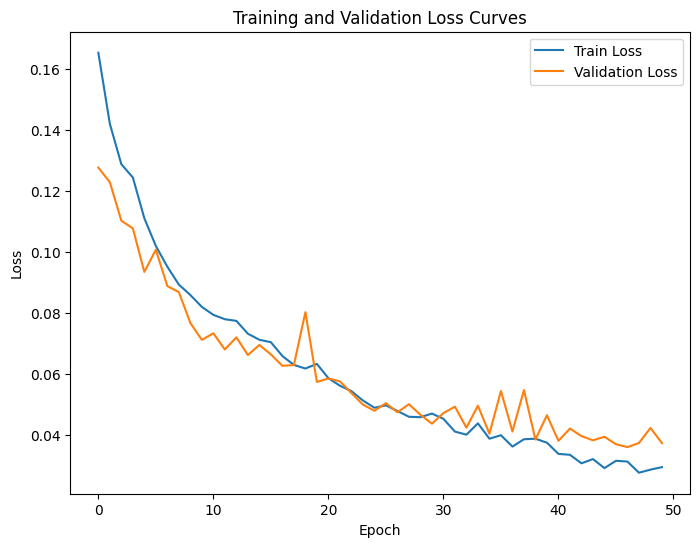

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-26-34.png
Test samples (avg ensemble):
Sample   0: Pred=1.6636, True=2.4654
Sample   1: Pred=0.0924, True=0.1334
Sample   2: Pred=1.6286, True=1.2167
Sample   3: Pred=1.4887, True=1.1593
Sample   4: Pred=0.1367, True=0.1802
Sample   5: Pred=0.0553, True=0.0600
Sample   6: Pred=16.1510, True=1.7800
Sample   7: Pred=2.6383, True=4.3986
Sample   8: Pred=0.6697, True=0.4696
Sample   9: Pred=0.0946, True=0.1055
Sample  10: Pred=0.7417, True=0.6503
Sample  11: Pred=0.3466, True=0.1610
Sample  12: Pred=0.9295, True=0.1694
Sample  13: Pred=0.1498, True=0.5143
Sample  14: Pred=2.6441, True=2.1430
Sample  15: Pred=0.1629, True=0.2603
Sample  16: Pred=1.2857, True=0.8442
Sample  17: Pred=0.1185, True=0.1382
Sample  18: Pred=0.8890, True=2.9576
Sample  19: Pred=3.9140, True=8.0533
Sample  20: Pred=0.2365, True=0.2522
Sample  21: Pred=0.0116, True=0.0144
Sample  22: Pred=0.7475, True=1.2707
Sample  23: Pred=5.1721, True=

[INFO 03-23 16:27:41] ax.service.managed_loop: Running optimization trial 39...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

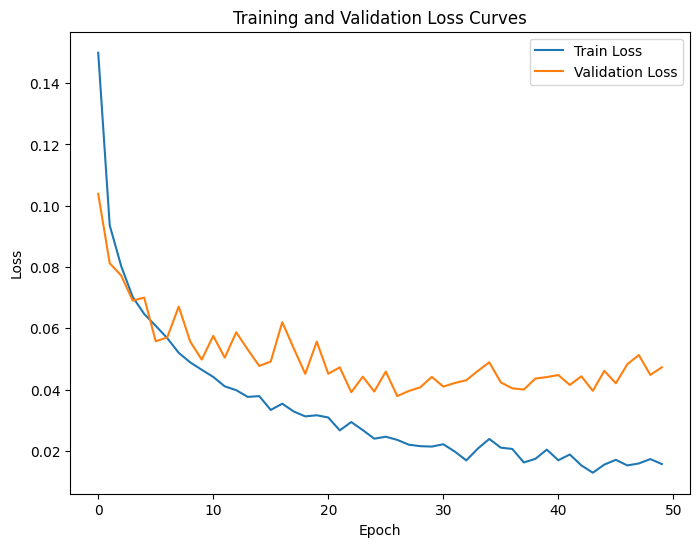

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-27-42.png
Test samples (avg ensemble):
Sample   0: Pred=2.0235, True=2.4654
Sample   1: Pred=0.1215, True=0.1334
Sample   2: Pred=10.5959, True=1.2167
Sample   3: Pred=0.8174, True=1.1593
Sample   4: Pred=0.3403, True=0.1802
Sample   5: Pred=0.0611, True=0.0600
Sample   6: Pred=3.2626, True=1.7800
Sample   7: Pred=3.9585, True=4.3986
Sample   8: Pred=0.5082, True=0.4696
Sample   9: Pred=0.0895, True=0.1055
Sample  10: Pred=0.6707, True=0.6503
Sample  11: Pred=0.4278, True=0.1610
Sample  12: Pred=0.2686, True=0.1694
Sample  13: Pred=0.2686, True=0.5143
Sample  14: Pred=1.7674, True=2.1430
Sample  15: Pred=0.2645, True=0.2603
Sample  16: Pred=0.9863, True=0.8442
Sample  17: Pred=0.1286, True=0.1382
Sample  18: Pred=0.8227, True=2.9576
Sample  19: Pred=2.1019, True=8.0533
Sample  20: Pred=0.2590, True=0.2522
Sample  21: Pred=0.0172, True=0.0144
Sample  22: Pred=0.7033, True=1.2707
Sample  23: Pred=3.7577, True=

[INFO 03-23 16:30:03] ax.service.managed_loop: Running optimization trial 40...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

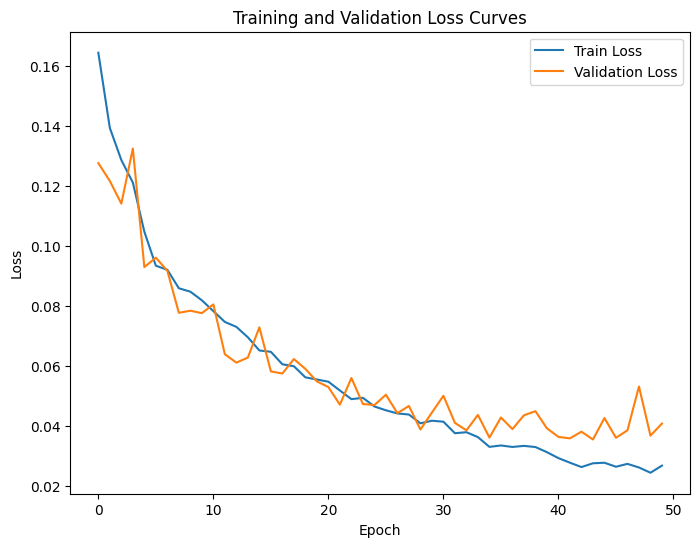

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-30-05.png
Test samples (avg ensemble):
Sample   0: Pred=2.0285, True=2.4654
Sample   1: Pred=0.1129, True=0.1334
Sample   2: Pred=1.5434, True=1.2167
Sample   3: Pred=2.3573, True=1.1593
Sample   4: Pred=0.1629, True=0.1802
Sample   5: Pred=0.0885, True=0.0600
Sample   6: Pred=17.1869, True=1.7800
Sample   7: Pred=1.4066, True=4.3986
Sample   8: Pred=0.5273, True=0.4696
Sample   9: Pred=0.1111, True=0.1055
Sample  10: Pred=0.5331, True=0.6503
Sample  11: Pred=0.4632, True=0.1610
Sample  12: Pred=0.6039, True=0.1694
Sample  13: Pred=0.3108, True=0.5143
Sample  14: Pred=1.7265, True=2.1430
Sample  15: Pred=0.1880, True=0.2603
Sample  16: Pred=0.7538, True=0.8442
Sample  17: Pred=0.1348, True=0.1382
Sample  18: Pred=0.7479, True=2.9576
Sample  19: Pred=3.1057, True=8.0533
Sample  20: Pred=0.2021, True=0.2522
Sample  21: Pred=0.0140, True=0.0144
Sample  22: Pred=1.0263, True=1.2707
Sample  23: Pred=3.3150, True=

[INFO 03-23 16:32:15] ax.service.managed_loop: Running optimization trial 41...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

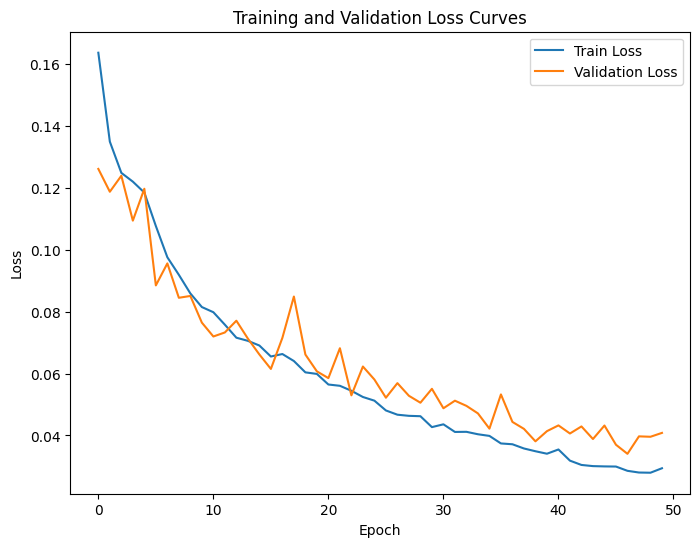

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-32-17.png
Test samples (avg ensemble):
Sample   0: Pred=1.9125, True=2.4654
Sample   1: Pred=0.1131, True=0.1334
Sample   2: Pred=0.8887, True=1.2167
Sample   3: Pred=1.5160, True=1.1593
Sample   4: Pred=0.2877, True=0.1802
Sample   5: Pred=0.0787, True=0.0600
Sample   6: Pred=5.3223, True=1.7800
Sample   7: Pred=0.5547, True=4.3986
Sample   8: Pred=0.4778, True=0.4696
Sample   9: Pred=0.1464, True=0.1055
Sample  10: Pred=0.5098, True=0.6503
Sample  11: Pred=1.7073, True=0.1610
Sample  12: Pred=0.4424, True=0.1694
Sample  13: Pred=0.5107, True=0.5143
Sample  14: Pred=2.3693, True=2.1430
Sample  15: Pred=0.1964, True=0.2603
Sample  16: Pred=0.4382, True=0.8442
Sample  17: Pred=0.1150, True=0.1382
Sample  18: Pred=0.5338, True=2.9576
Sample  19: Pred=2.4963, True=8.0533
Sample  20: Pred=0.2470, True=0.2522
Sample  21: Pred=0.0140, True=0.0144
Sample  22: Pred=0.7041, True=1.2707
Sample  23: Pred=1.3104, True=1

[INFO 03-23 16:34:01] ax.service.managed_loop: Running optimization trial 42...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

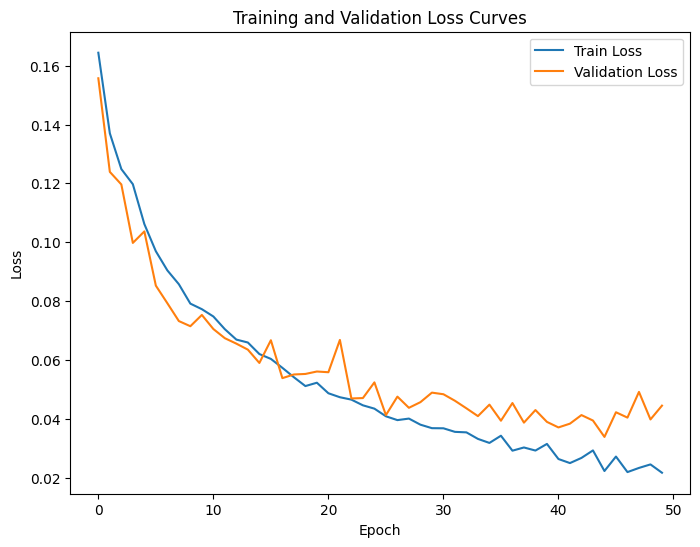

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-34-03.png
Test samples (avg ensemble):
Sample   0: Pred=3.0340, True=2.4654
Sample   1: Pred=0.1135, True=0.1334
Sample   2: Pred=2.5140, True=1.2167
Sample   3: Pred=1.6029, True=1.1593
Sample   4: Pred=0.1257, True=0.1802
Sample   5: Pred=0.0428, True=0.0600
Sample   6: Pred=16.3966, True=1.7800
Sample   7: Pred=6.7684, True=4.3986
Sample   8: Pred=0.5414, True=0.4696
Sample   9: Pred=0.1320, True=0.1055
Sample  10: Pred=0.7566, True=0.6503
Sample  11: Pred=0.4793, True=0.1610
Sample  12: Pred=0.5646, True=0.1694
Sample  13: Pred=0.3933, True=0.5143
Sample  14: Pred=2.1037, True=2.1430
Sample  15: Pred=0.2994, True=0.2603
Sample  16: Pred=1.6934, True=0.8442
Sample  17: Pred=0.1619, True=0.1382
Sample  18: Pred=1.0326, True=2.9576
Sample  19: Pred=2.2850, True=8.0533
Sample  20: Pred=0.2146, True=0.2522
Sample  21: Pred=0.0113, True=0.0144
Sample  22: Pred=1.0421, True=1.2707
Sample  23: Pred=2.2236, True=

[INFO 03-23 16:35:57] ax.service.managed_loop: Running optimization trial 43...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

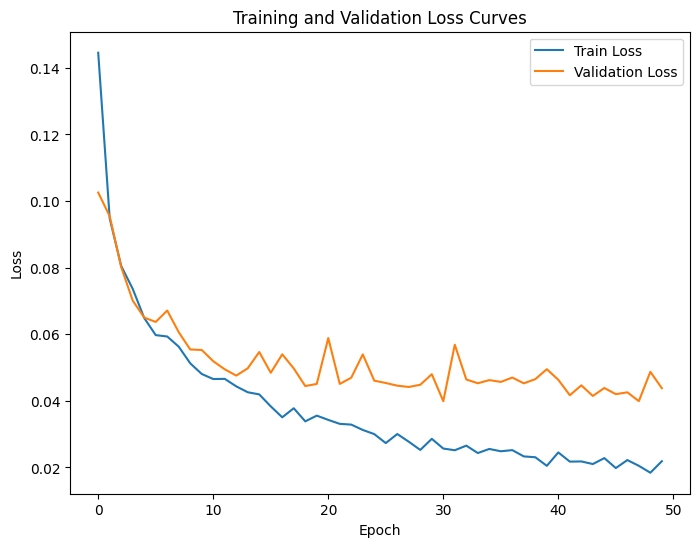

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-35-59.png
Test samples (avg ensemble):
Sample   0: Pred=2.4188, True=2.4654
Sample   1: Pred=0.1340, True=0.1334
Sample   2: Pred=8.2025, True=1.2167
Sample   3: Pred=1.2641, True=1.1593
Sample   4: Pred=0.1558, True=0.1802
Sample   5: Pred=0.0760, True=0.0600
Sample   6: Pred=3.5700, True=1.7800
Sample   7: Pred=2.6883, True=4.3986
Sample   8: Pred=0.6352, True=0.4696
Sample   9: Pred=0.0813, True=0.1055
Sample  10: Pred=0.6112, True=0.6503
Sample  11: Pred=2.9446, True=0.1610
Sample  12: Pred=0.3306, True=0.1694
Sample  13: Pred=0.3767, True=0.5143
Sample  14: Pred=2.4190, True=2.1430
Sample  15: Pred=0.3289, True=0.2603
Sample  16: Pred=1.0808, True=0.8442
Sample  17: Pred=0.1522, True=0.1382
Sample  18: Pred=0.6435, True=2.9576
Sample  19: Pred=1.2986, True=8.0533
Sample  20: Pred=0.2500, True=0.2522
Sample  21: Pred=0.0118, True=0.0144
Sample  22: Pred=0.8971, True=1.2707
Sample  23: Pred=5.8638, True=1

[INFO 03-23 16:37:54] ax.service.managed_loop: Running optimization trial 44...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

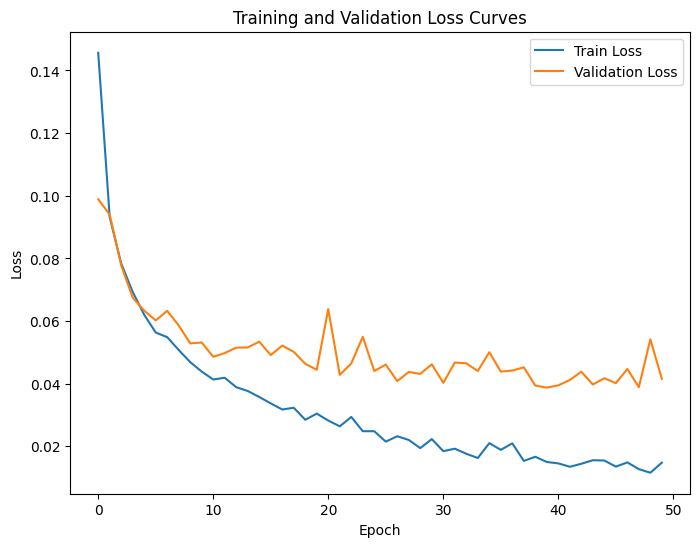

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-37-55.png
Test samples (avg ensemble):
Sample   0: Pred=2.3676, True=2.4654
Sample   1: Pred=0.1353, True=0.1334
Sample   2: Pred=6.8666, True=1.2167
Sample   3: Pred=0.5914, True=1.1593
Sample   4: Pred=0.1972, True=0.1802
Sample   5: Pred=0.0546, True=0.0600
Sample   6: Pred=2.2053, True=1.7800
Sample   7: Pred=0.7084, True=4.3986
Sample   8: Pred=0.5836, True=0.4696
Sample   9: Pred=0.0922, True=0.1055
Sample  10: Pred=0.6368, True=0.6503
Sample  11: Pred=0.5198, True=0.1610
Sample  12: Pred=0.3020, True=0.1694
Sample  13: Pred=0.3818, True=0.5143
Sample  14: Pred=2.1620, True=2.1430
Sample  15: Pred=0.2002, True=0.2603
Sample  16: Pred=0.8484, True=0.8442
Sample  17: Pred=0.1342, True=0.1382
Sample  18: Pred=0.7487, True=2.9576
Sample  19: Pred=2.2919, True=8.0533
Sample  20: Pred=0.2368, True=0.2522
Sample  21: Pred=0.0158, True=0.0144
Sample  22: Pred=1.0589, True=1.2707
Sample  23: Pred=3.4103, True=1

[INFO 03-23 16:39:48] ax.service.managed_loop: Running optimization trial 45...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

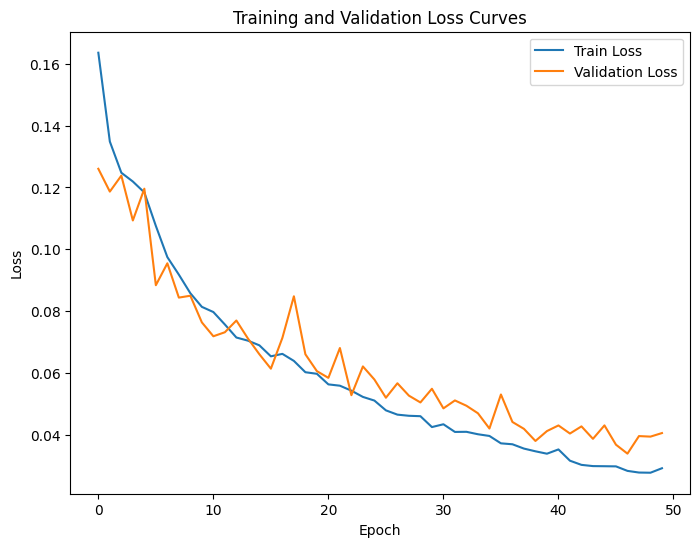

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-39-49.png
Test samples (avg ensemble):
Sample   0: Pred=1.9105, True=2.4654
Sample   1: Pred=0.1123, True=0.1334
Sample   2: Pred=0.8913, True=1.2167
Sample   3: Pred=1.5122, True=1.1593
Sample   4: Pred=0.2870, True=0.1802
Sample   5: Pred=0.0799, True=0.0600
Sample   6: Pred=5.4415, True=1.7800
Sample   7: Pred=0.5727, True=4.3986
Sample   8: Pred=0.4766, True=0.4696
Sample   9: Pred=0.1435, True=0.1055
Sample  10: Pred=0.5054, True=0.6503
Sample  11: Pred=1.7035, True=0.1610
Sample  12: Pred=0.4463, True=0.1694
Sample  13: Pred=0.5134, True=0.5143
Sample  14: Pred=2.3684, True=2.1430
Sample  15: Pred=0.1961, True=0.2603
Sample  16: Pred=0.4395, True=0.8442
Sample  17: Pred=0.1143, True=0.1382
Sample  18: Pred=0.5338, True=2.9576
Sample  19: Pred=2.4924, True=8.0533
Sample  20: Pred=0.2448, True=0.2522
Sample  21: Pred=0.0140, True=0.0144
Sample  22: Pred=0.7010, True=1.2707
Sample  23: Pred=1.2933, True=1

[INFO 03-23 16:41:33] ax.service.managed_loop: Running optimization trial 46...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

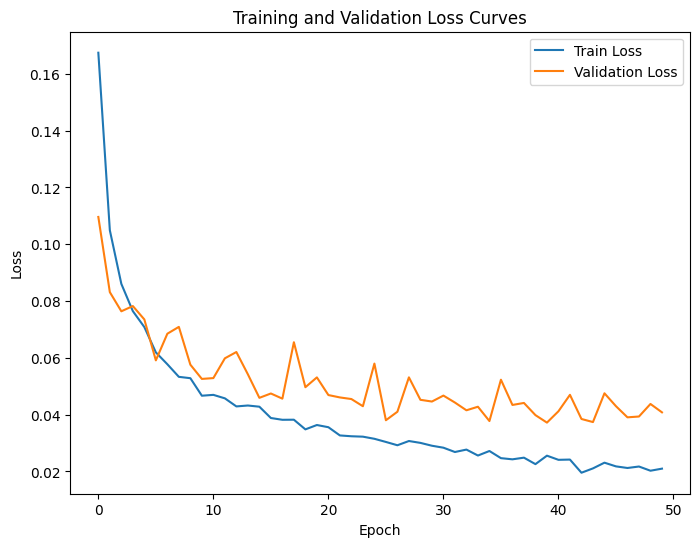

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-41-35.png
Test samples (avg ensemble):
Sample   0: Pred=2.3069, True=2.4654
Sample   1: Pred=0.0957, True=0.1334
Sample   2: Pred=2.4311, True=1.2167
Sample   3: Pred=1.3855, True=1.1593
Sample   4: Pred=0.2762, True=0.1802
Sample   5: Pred=0.0497, True=0.0600
Sample   6: Pred=7.3771, True=1.7800
Sample   7: Pred=3.2927, True=4.3986
Sample   8: Pred=0.7982, True=0.4696
Sample   9: Pred=0.1054, True=0.1055
Sample  10: Pred=0.5747, True=0.6503
Sample  11: Pred=0.7187, True=0.1610
Sample  12: Pred=0.6044, True=0.1694
Sample  13: Pred=0.2191, True=0.5143
Sample  14: Pred=2.3408, True=2.1430
Sample  15: Pred=0.2533, True=0.2603
Sample  16: Pred=0.9840, True=0.8442
Sample  17: Pred=0.1421, True=0.1382
Sample  18: Pred=0.6920, True=2.9576
Sample  19: Pred=5.6033, True=8.0533
Sample  20: Pred=0.3058, True=0.2522
Sample  21: Pred=0.0146, True=0.0144
Sample  22: Pred=0.9711, True=1.2707
Sample  23: Pred=8.0131, True=1

[INFO 03-23 16:43:22] ax.service.managed_loop: Running optimization trial 47...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

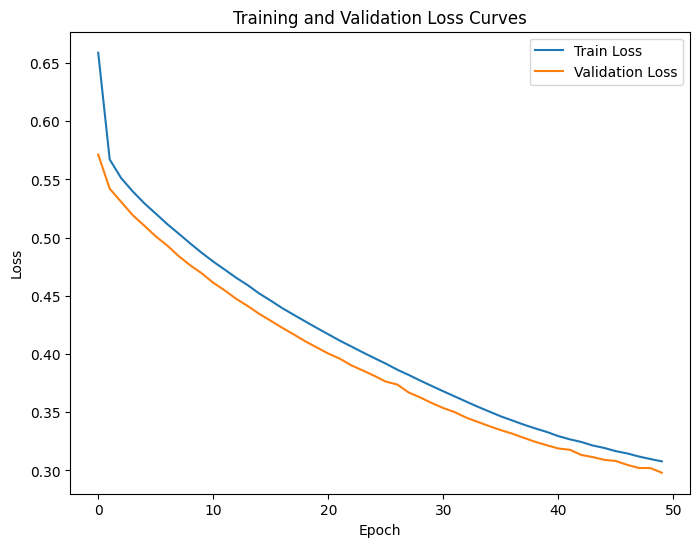

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-43-23.png
Test samples (avg ensemble):
Sample   0: Pred=0.7177, True=2.4654
Sample   1: Pred=0.0555, True=0.1334
Sample   2: Pred=0.8595, True=1.2167
Sample   3: Pred=1.2674, True=1.1593
Sample   4: Pred=0.1649, True=0.1802
Sample   5: Pred=0.2054, True=0.0600
Sample   6: Pred=2.4473, True=1.7800
Sample   7: Pred=2.3211, True=4.3986
Sample   8: Pred=0.5162, True=0.4696
Sample   9: Pred=0.0588, True=0.1055
Sample  10: Pred=0.7655, True=0.6503
Sample  11: Pred=0.4334, True=0.1610
Sample  12: Pred=0.5412, True=0.1694
Sample  13: Pred=0.3502, True=0.5143
Sample  14: Pred=1.0905, True=2.1430
Sample  15: Pred=0.1993, True=0.2603
Sample  16: Pred=1.5327, True=0.8442
Sample  17: Pred=0.0894, True=0.1382
Sample  18: Pred=1.2124, True=2.9576
Sample  19: Pred=2.3415, True=8.0533
Sample  20: Pred=0.2778, True=0.2522
Sample  21: Pred=0.0350, True=0.0144
Sample  22: Pred=1.7927, True=1.2707
Sample  23: Pred=0.9626, True=1

[INFO 03-23 16:45:25] ax.service.managed_loop: Running optimization trial 48...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

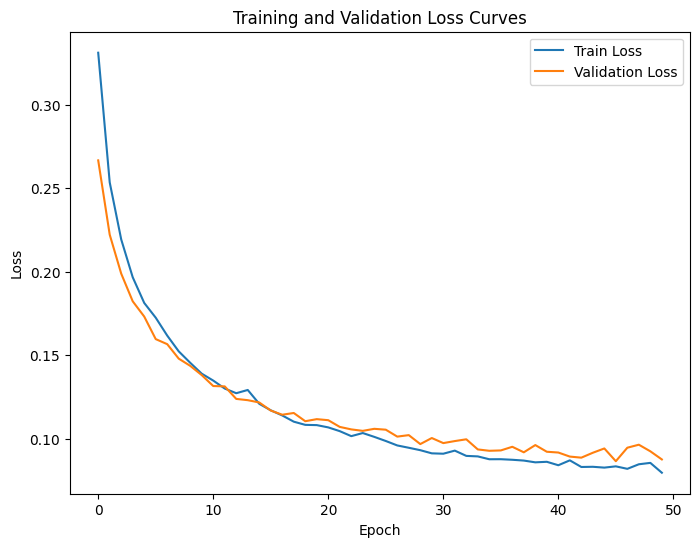

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-45-26.png
Test samples (avg ensemble):
Sample   0: Pred=1.2367, True=2.4654
Sample   1: Pred=0.0829, True=0.1334
Sample   2: Pred=0.6003, True=1.2167
Sample   3: Pred=1.0777, True=1.1593
Sample   4: Pred=0.2429, True=0.1802
Sample   5: Pred=0.0658, True=0.0600
Sample   6: Pred=13.6898, True=1.7800
Sample   7: Pred=0.5547, True=4.3986
Sample   8: Pred=0.6672, True=0.4696
Sample   9: Pred=0.1039, True=0.1055
Sample  10: Pred=0.4845, True=0.6503
Sample  11: Pred=1.2190, True=0.1610
Sample  12: Pred=0.3612, True=0.1694
Sample  13: Pred=0.2903, True=0.5143
Sample  14: Pred=1.8794, True=2.1430
Sample  15: Pred=0.2667, True=0.2603
Sample  16: Pred=0.8640, True=0.8442
Sample  17: Pred=0.1042, True=0.1382
Sample  18: Pred=1.0010, True=2.9576
Sample  19: Pred=2.4346, True=8.0533
Sample  20: Pred=0.2630, True=0.2522
Sample  21: Pred=0.0257, True=0.0144
Sample  22: Pred=1.9222, True=1.2707
Sample  23: Pred=1.2112, True=

[INFO 03-23 16:45:34] ax.service.managed_loop: Running optimization trial 49...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

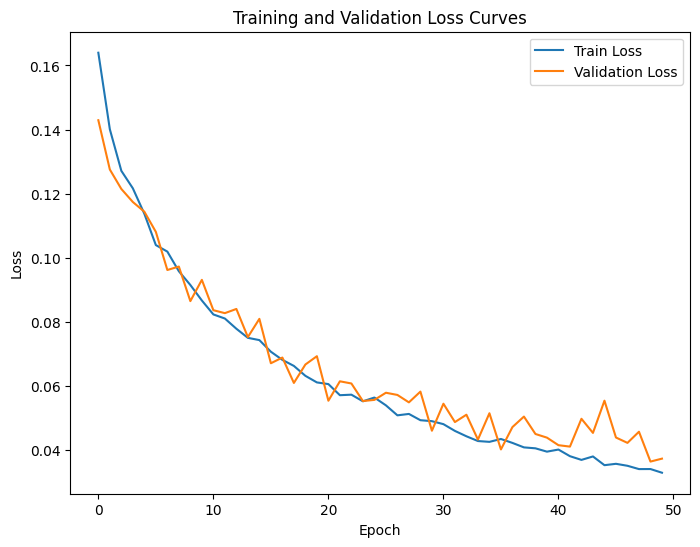

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-45-36.png
Test samples (avg ensemble):
Sample   0: Pred=1.4106, True=2.4654
Sample   1: Pred=0.1332, True=0.1334
Sample   2: Pred=1.1328, True=1.2167
Sample   3: Pred=0.6003, True=1.1593
Sample   4: Pred=0.1748, True=0.1802
Sample   5: Pred=0.0454, True=0.0600
Sample   6: Pred=8.8865, True=1.7800
Sample   7: Pred=1.1217, True=4.3986
Sample   8: Pred=0.3462, True=0.4696
Sample   9: Pred=0.0813, True=0.1055
Sample  10: Pred=0.6812, True=0.6503
Sample  11: Pred=0.6901, True=0.1610
Sample  12: Pred=0.5461, True=0.1694
Sample  13: Pred=0.3138, True=0.5143
Sample  14: Pred=2.0868, True=2.1430
Sample  15: Pred=0.2082, True=0.2603
Sample  16: Pred=0.8108, True=0.8442
Sample  17: Pred=0.1182, True=0.1382
Sample  18: Pred=0.6723, True=2.9576
Sample  19: Pred=3.4761, True=8.0533
Sample  20: Pred=0.2906, True=0.2522
Sample  21: Pred=0.0120, True=0.0144
Sample  22: Pred=0.8314, True=1.2707
Sample  23: Pred=2.7422, True=1

[INFO 03-23 16:47:34] ax.service.managed_loop: Running optimization trial 50...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

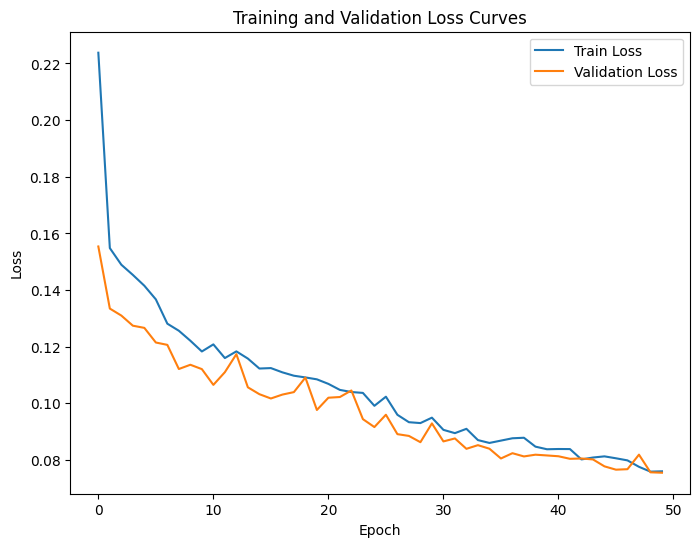

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-47-36.png
Test samples (avg ensemble):
Sample   0: Pred=0.9896, True=2.4654
Sample   1: Pred=0.0667, True=0.1334
Sample   2: Pred=0.6371, True=1.2167
Sample   3: Pred=0.6354, True=1.1593
Sample   4: Pred=0.1528, True=0.1802
Sample   5: Pred=0.0491, True=0.0600
Sample   6: Pred=6.5354, True=1.7800
Sample   7: Pred=0.9462, True=4.3986
Sample   8: Pred=1.0159, True=0.4696
Sample   9: Pred=0.0866, True=0.1055
Sample  10: Pred=0.3401, True=0.6503
Sample  11: Pred=0.6388, True=0.1610
Sample  12: Pred=0.5179, True=0.1694
Sample  13: Pred=0.2403, True=0.5143
Sample  14: Pred=2.9970, True=2.1430
Sample  15: Pred=0.1483, True=0.2603
Sample  16: Pred=1.1173, True=0.8442
Sample  17: Pred=0.0774, True=0.1382
Sample  18: Pred=1.0583, True=2.9576
Sample  19: Pred=4.2332, True=8.0533
Sample  20: Pred=0.2582, True=0.2522
Sample  21: Pred=0.0260, True=0.0144
Sample  22: Pred=3.7913, True=1.2707
Sample  23: Pred=1.2315, True=1

[INFO 03-23 16:47:47] ax.service.managed_loop: Running optimization trial 51...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

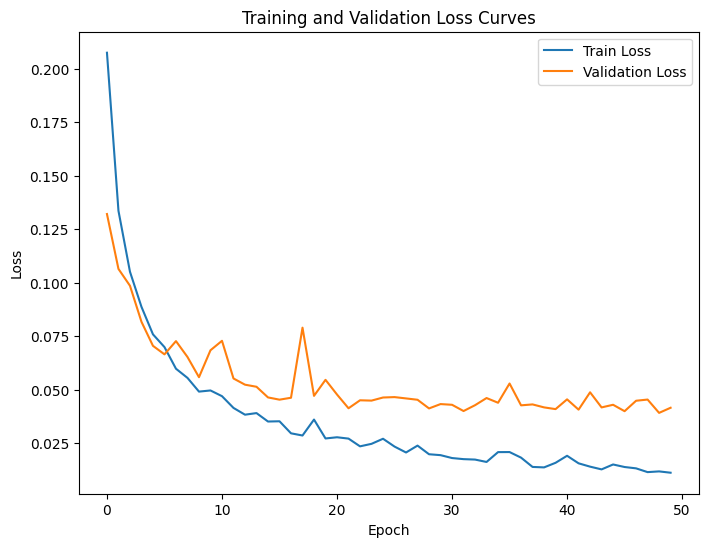

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-47-48.png
Test samples (avg ensemble):
Sample   0: Pred=1.9830, True=2.4654
Sample   1: Pred=0.1130, True=0.1334
Sample   2: Pred=8.8671, True=1.2167
Sample   3: Pred=0.5458, True=1.1593
Sample   4: Pred=0.1769, True=0.1802
Sample   5: Pred=0.0681, True=0.0600
Sample   6: Pred=4.2149, True=1.7800
Sample   7: Pred=2.2073, True=4.3986
Sample   8: Pred=0.4607, True=0.4696
Sample   9: Pred=0.1069, True=0.1055
Sample  10: Pred=0.5942, True=0.6503
Sample  11: Pred=0.5338, True=0.1610
Sample  12: Pred=0.3481, True=0.1694
Sample  13: Pred=0.2366, True=0.5143
Sample  14: Pred=2.2026, True=2.1430
Sample  15: Pred=0.1775, True=0.2603
Sample  16: Pred=0.7951, True=0.8442
Sample  17: Pred=0.1099, True=0.1382
Sample  18: Pred=0.5841, True=2.9576
Sample  19: Pred=1.7544, True=8.0533
Sample  20: Pred=0.2512, True=0.2522
Sample  21: Pred=0.0139, True=0.0144
Sample  22: Pred=0.9674, True=1.2707
Sample  23: Pred=2.9407, True=1

[INFO 03-23 16:48:00] ax.service.managed_loop: Running optimization trial 52...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

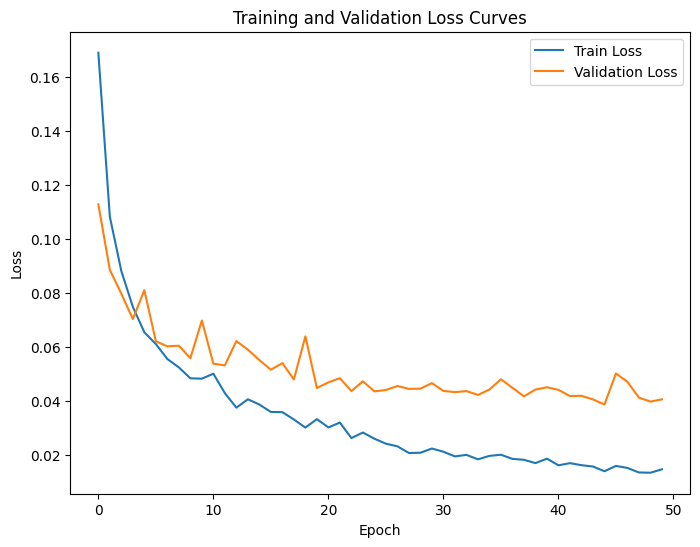

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-48-01.png
Test samples (avg ensemble):
Sample   0: Pred=2.3044, True=2.4654
Sample   1: Pred=0.1059, True=0.1334
Sample   2: Pred=2.7537, True=1.2167
Sample   3: Pred=0.5942, True=1.1593
Sample   4: Pred=0.1880, True=0.1802
Sample   5: Pred=0.0771, True=0.0600
Sample   6: Pred=6.8233, True=1.7800
Sample   7: Pred=2.2888, True=4.3986
Sample   8: Pred=0.5839, True=0.4696
Sample   9: Pred=0.0781, True=0.1055
Sample  10: Pred=0.6650, True=0.6503
Sample  11: Pred=0.4776, True=0.1610
Sample  12: Pred=0.6747, True=0.1694
Sample  13: Pred=0.3085, True=0.5143
Sample  14: Pred=2.1466, True=2.1430
Sample  15: Pred=0.2239, True=0.2603
Sample  16: Pred=0.9202, True=0.8442
Sample  17: Pred=0.1223, True=0.1382
Sample  18: Pred=0.6917, True=2.9576
Sample  19: Pred=2.9120, True=8.0533
Sample  20: Pred=0.2836, True=0.2522
Sample  21: Pred=0.0149, True=0.0144
Sample  22: Pred=1.1934, True=1.2707
Sample  23: Pred=4.4230, True=1

[INFO 03-23 16:48:30] ax.service.managed_loop: Running optimization trial 53...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

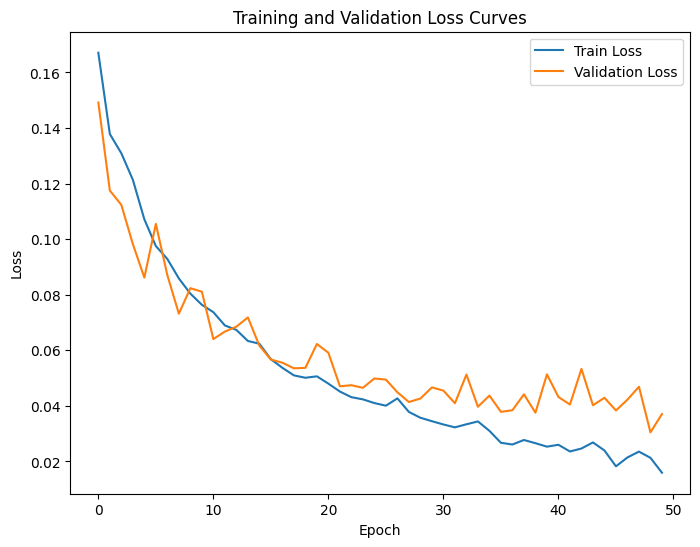

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-48-32.png
Test samples (avg ensemble):
Sample   0: Pred=1.6070, True=2.4654
Sample   1: Pred=0.1114, True=0.1334
Sample   2: Pred=4.5013, True=1.2167
Sample   3: Pred=1.5591, True=1.1593
Sample   4: Pred=0.2857, True=0.1802
Sample   5: Pred=0.0635, True=0.0600
Sample   6: Pred=14.8842, True=1.7800
Sample   7: Pred=2.1187, True=4.3986
Sample   8: Pred=0.5129, True=0.4696
Sample   9: Pred=0.1037, True=0.1055
Sample  10: Pred=0.8060, True=0.6503
Sample  11: Pred=0.3356, True=0.1610
Sample  12: Pred=0.3033, True=0.1694
Sample  13: Pred=0.3682, True=0.5143
Sample  14: Pred=2.2325, True=2.1430
Sample  15: Pred=0.2825, True=0.2603
Sample  16: Pred=0.6731, True=0.8442
Sample  17: Pred=0.1343, True=0.1382
Sample  18: Pred=1.3477, True=2.9576
Sample  19: Pred=3.5599, True=8.0533
Sample  20: Pred=0.3452, True=0.2522
Sample  21: Pred=0.0172, True=0.0144
Sample  22: Pred=1.2606, True=1.2707
Sample  23: Pred=5.4289, True=

[INFO 03-23 16:49:35] ax.service.managed_loop: Running optimization trial 54...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

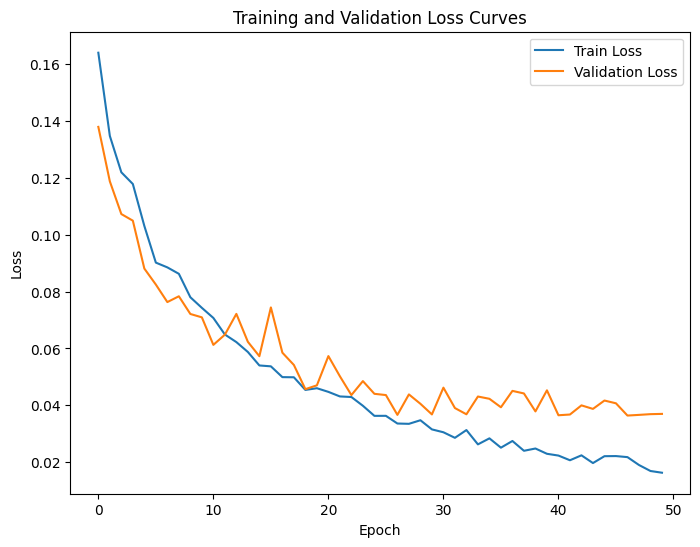

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-49-37.png
Test samples (avg ensemble):
Sample   0: Pred=2.2562, True=2.4654
Sample   1: Pred=0.1143, True=0.1334
Sample   2: Pred=6.6966, True=1.2167
Sample   3: Pred=0.8573, True=1.1593
Sample   4: Pred=0.1758, True=0.1802
Sample   5: Pred=0.0693, True=0.0600
Sample   6: Pred=6.0754, True=1.7800
Sample   7: Pred=1.0952, True=4.3986
Sample   8: Pred=0.4598, True=0.4696
Sample   9: Pred=0.0954, True=0.1055
Sample  10: Pred=0.5894, True=0.6503
Sample  11: Pred=1.3395, True=0.1610
Sample  12: Pred=0.2016, True=0.1694
Sample  13: Pred=0.1931, True=0.5143
Sample  14: Pred=2.2151, True=2.1430
Sample  15: Pred=0.2039, True=0.2603
Sample  16: Pred=0.6014, True=0.8442
Sample  17: Pred=0.1371, True=0.1382
Sample  18: Pred=0.6650, True=2.9576
Sample  19: Pred=2.0610, True=8.0533
Sample  20: Pred=0.2385, True=0.2522
Sample  21: Pred=0.0143, True=0.0144
Sample  22: Pred=0.8928, True=1.2707
Sample  23: Pred=2.3049, True=1

[INFO 03-23 16:50:31] ax.service.managed_loop: Running optimization trial 55...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

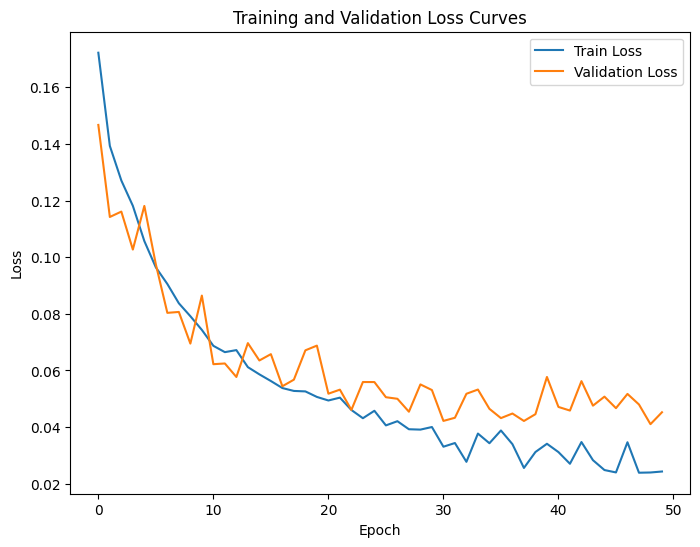

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-50-32.png
Test samples (avg ensemble):
Sample   0: Pred=2.1014, True=2.4654
Sample   1: Pred=0.1231, True=0.1334
Sample   2: Pred=3.8966, True=1.2167
Sample   3: Pred=1.2205, True=1.1593
Sample   4: Pred=0.2338, True=0.1802
Sample   5: Pred=0.0613, True=0.0600
Sample   6: Pred=21.2455, True=1.7800
Sample   7: Pred=3.0049, True=4.3986
Sample   8: Pred=1.0965, True=0.4696
Sample   9: Pred=0.1005, True=0.1055
Sample  10: Pred=0.5775, True=0.6503
Sample  11: Pred=0.6141, True=0.1610
Sample  12: Pred=1.0938, True=0.1694
Sample  13: Pred=0.4760, True=0.5143
Sample  14: Pred=2.1305, True=2.1430
Sample  15: Pred=0.1805, True=0.2603
Sample  16: Pred=1.0763, True=0.8442
Sample  17: Pred=0.1293, True=0.1382
Sample  18: Pred=0.6815, True=2.9576
Sample  19: Pred=0.9298, True=8.0533
Sample  20: Pred=0.2501, True=0.2522
Sample  21: Pred=0.0187, True=0.0144
Sample  22: Pred=0.9492, True=1.2707
Sample  23: Pred=1.8048, True=

[INFO 03-23 16:52:36] ax.service.managed_loop: Running optimization trial 56...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 3
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

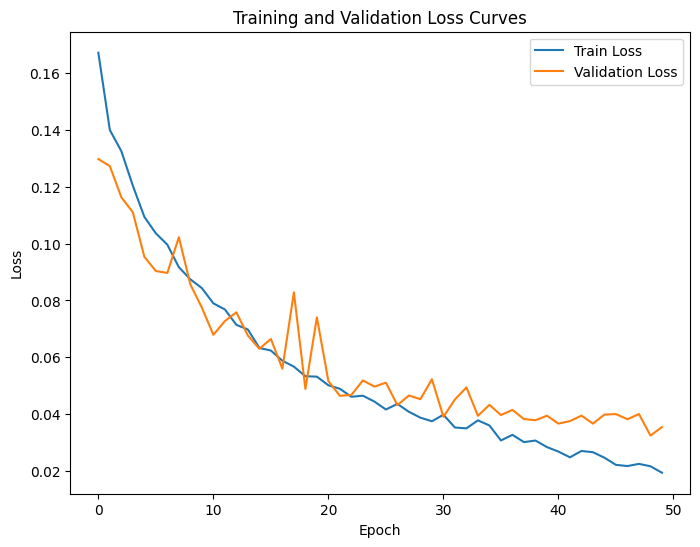

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-52-38.png
Test samples (avg ensemble):
Sample   0: Pred=1.9074, True=2.4654
Sample   1: Pred=0.1276, True=0.1334
Sample   2: Pred=2.5999, True=1.2167
Sample   3: Pred=0.7060, True=1.1593
Sample   4: Pred=0.1810, True=0.1802
Sample   5: Pred=0.0486, True=0.0600
Sample   6: Pred=7.7581, True=1.7800
Sample   7: Pred=3.9051, True=4.3986
Sample   8: Pred=0.5940, True=0.4696
Sample   9: Pred=0.0946, True=0.1055
Sample  10: Pred=0.4906, True=0.6503
Sample  11: Pred=0.4686, True=0.1610
Sample  12: Pred=0.8372, True=0.1694
Sample  13: Pred=0.3340, True=0.5143
Sample  14: Pred=1.7725, True=2.1430
Sample  15: Pred=0.2393, True=0.2603
Sample  16: Pred=0.6836, True=0.8442
Sample  17: Pred=0.1555, True=0.1382
Sample  18: Pred=1.1293, True=2.9576
Sample  19: Pred=3.5753, True=8.0533
Sample  20: Pred=0.2534, True=0.2522
Sample  21: Pred=0.0151, True=0.0144
Sample  22: Pred=0.9038, True=1.2707
Sample  23: Pred=4.5620, True=1

[INFO 03-23 16:53:11] ax.service.managed_loop: Running optimization trial 57...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 3
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

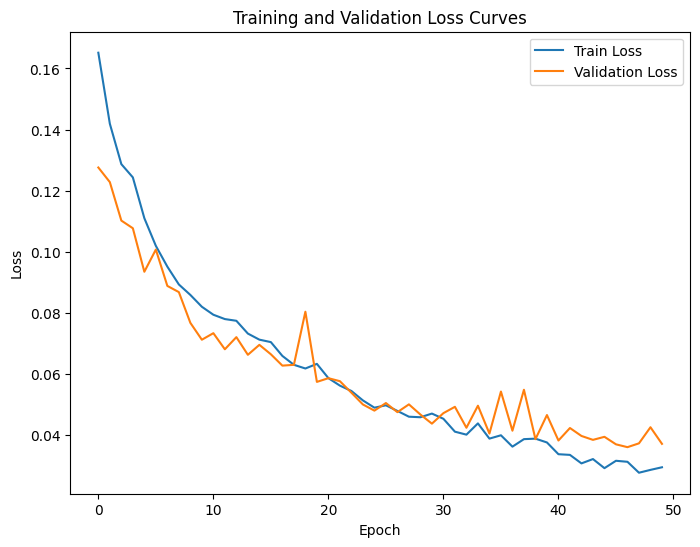

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-53-13.png
Test samples (avg ensemble):
Sample   0: Pred=1.6786, True=2.4654
Sample   1: Pred=0.0922, True=0.1334
Sample   2: Pred=1.5898, True=1.2167
Sample   3: Pred=1.4735, True=1.1593
Sample   4: Pred=0.1381, True=0.1802
Sample   5: Pred=0.0549, True=0.0600
Sample   6: Pred=16.2838, True=1.7800
Sample   7: Pred=2.6450, True=4.3986
Sample   8: Pred=0.6825, True=0.4696
Sample   9: Pred=0.0954, True=0.1055
Sample  10: Pred=0.7482, True=0.6503
Sample  11: Pred=0.3426, True=0.1610
Sample  12: Pred=0.9259, True=0.1694
Sample  13: Pred=0.1528, True=0.5143
Sample  14: Pred=2.5997, True=2.1430
Sample  15: Pred=0.1620, True=0.2603
Sample  16: Pred=1.2783, True=0.8442
Sample  17: Pred=0.1185, True=0.1382
Sample  18: Pred=0.8861, True=2.9576
Sample  19: Pred=3.8894, True=8.0533
Sample  20: Pred=0.2360, True=0.2522
Sample  21: Pred=0.0116, True=0.0144
Sample  22: Pred=0.7480, True=1.2707
Sample  23: Pred=5.1029, True=

[INFO 03-23 16:54:12] ax.service.managed_loop: Running optimization trial 58...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

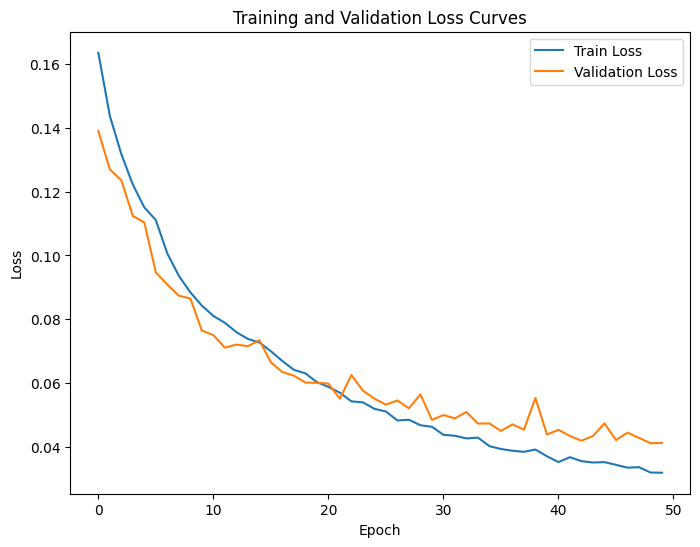

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-54-14.png
Test samples (avg ensemble):
Sample   0: Pred=1.9194, True=2.4654
Sample   1: Pred=0.1105, True=0.1334
Sample   2: Pred=1.3608, True=1.2167
Sample   3: Pred=2.3238, True=1.1593
Sample   4: Pred=0.1763, True=0.1802
Sample   5: Pred=0.0442, True=0.0600
Sample   6: Pred=18.6166, True=1.7800
Sample   7: Pred=1.6999, True=4.3986
Sample   8: Pred=0.7987, True=0.4696
Sample   9: Pred=0.0936, True=0.1055
Sample  10: Pred=0.5411, True=0.6503
Sample  11: Pred=1.0093, True=0.1610
Sample  12: Pred=0.3011, True=0.1694
Sample  13: Pred=0.2524, True=0.5143
Sample  14: Pred=2.2091, True=2.1430
Sample  15: Pred=0.3061, True=0.2603
Sample  16: Pred=1.0218, True=0.8442
Sample  17: Pred=0.1345, True=0.1382
Sample  18: Pred=0.6036, True=2.9576
Sample  19: Pred=2.9614, True=8.0533
Sample  20: Pred=0.2843, True=0.2522
Sample  21: Pred=0.0234, True=0.0144
Sample  22: Pred=0.8846, True=1.2707
Sample  23: Pred=1.7101, True=

[INFO 03-23 16:54:34] ax.service.managed_loop: Running optimization trial 59...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

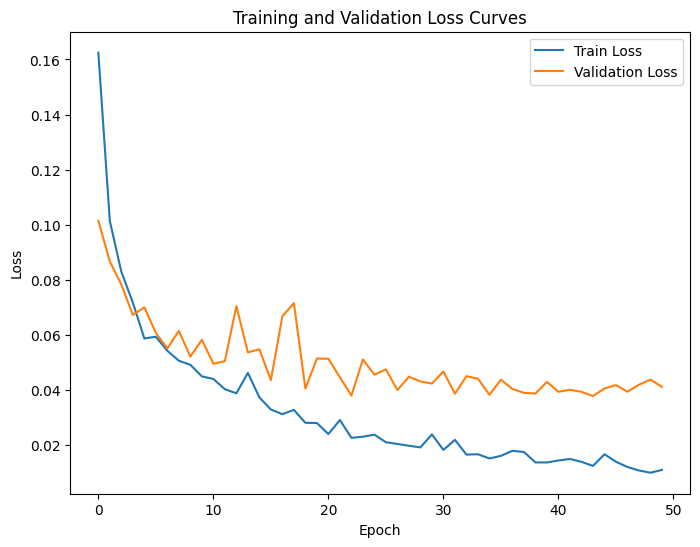

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-54-36.png
Test samples (avg ensemble):
Sample   0: Pred=1.9660, True=2.4654
Sample   1: Pred=0.1260, True=0.1334
Sample   2: Pred=10.8165, True=1.2167
Sample   3: Pred=1.1470, True=1.1593
Sample   4: Pred=0.1874, True=0.1802
Sample   5: Pred=0.0664, True=0.0600
Sample   6: Pred=5.9344, True=1.7800
Sample   7: Pred=2.5467, True=4.3986
Sample   8: Pred=0.4945, True=0.4696
Sample   9: Pred=0.0957, True=0.1055
Sample  10: Pred=0.6481, True=0.6503
Sample  11: Pred=0.5695, True=0.1610
Sample  12: Pred=0.2028, True=0.1694
Sample  13: Pred=0.2583, True=0.5143
Sample  14: Pred=2.6057, True=2.1430
Sample  15: Pred=0.1960, True=0.2603
Sample  16: Pred=0.7868, True=0.8442
Sample  17: Pred=0.1350, True=0.1382
Sample  18: Pred=1.1754, True=2.9576
Sample  19: Pred=2.3315, True=8.0533
Sample  20: Pred=0.2412, True=0.2522
Sample  21: Pred=0.0149, True=0.0144
Sample  22: Pred=0.9173, True=1.2707
Sample  23: Pred=2.6127, True=

[INFO 03-23 16:55:07] ax.service.managed_loop: Running optimization trial 60...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 3
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

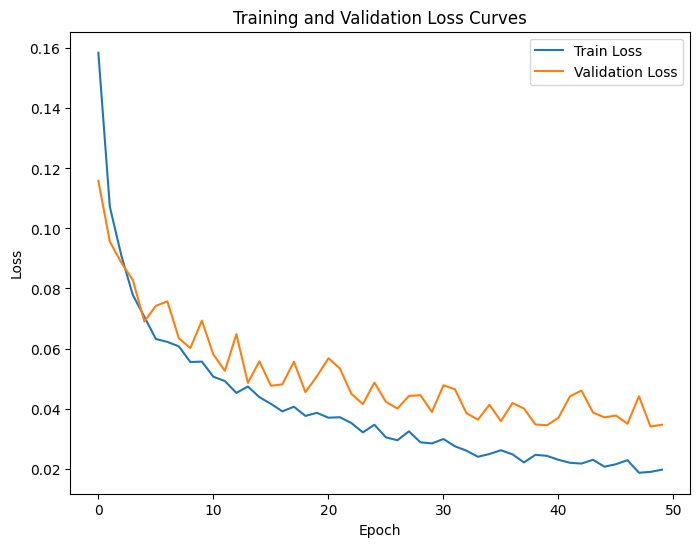

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-55-11.png
Test samples (avg ensemble):
Sample   0: Pred=1.6793, True=2.4654
Sample   1: Pred=0.1037, True=0.1334
Sample   2: Pred=2.3987, True=1.2167
Sample   3: Pred=0.8580, True=1.1593
Sample   4: Pred=0.1828, True=0.1802
Sample   5: Pred=0.0742, True=0.0600
Sample   6: Pred=5.8996, True=1.7800
Sample   7: Pred=0.4943, True=4.3986
Sample   8: Pred=0.5266, True=0.4696
Sample   9: Pred=0.1092, True=0.1055
Sample  10: Pred=0.5819, True=0.6503
Sample  11: Pred=0.5685, True=0.1610
Sample  12: Pred=0.3025, True=0.1694
Sample  13: Pred=0.2737, True=0.5143
Sample  14: Pred=2.2289, True=2.1430
Sample  15: Pred=0.1776, True=0.2603
Sample  16: Pred=0.8094, True=0.8442
Sample  17: Pred=0.1343, True=0.1382
Sample  18: Pred=0.7477, True=2.9576
Sample  19: Pred=3.0813, True=8.0533
Sample  20: Pred=0.2740, True=0.2522
Sample  21: Pred=0.0158, True=0.0144
Sample  22: Pred=1.0614, True=1.2707
Sample  23: Pred=2.2656, True=1

[INFO 03-23 16:57:10] ax.service.managed_loop: Running optimization trial 61...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

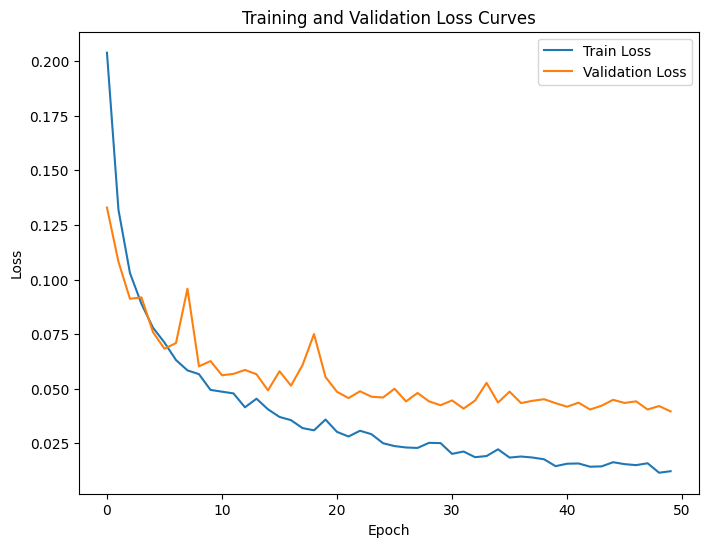

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-57-12.png
Test samples (avg ensemble):
Sample   0: Pred=1.9338, True=2.4654
Sample   1: Pred=0.1328, True=0.1334
Sample   2: Pred=7.8597, True=1.2167
Sample   3: Pred=0.7524, True=1.1593
Sample   4: Pred=0.1892, True=0.1802
Sample   5: Pred=0.0727, True=0.0600
Sample   6: Pred=6.5392, True=1.7800
Sample   7: Pred=0.7567, True=4.3986
Sample   8: Pred=0.4795, True=0.4696
Sample   9: Pred=0.1136, True=0.1055
Sample  10: Pred=0.6478, True=0.6503
Sample  11: Pred=0.7037, True=0.1610
Sample  12: Pred=0.2584, True=0.1694
Sample  13: Pred=0.3017, True=0.5143
Sample  14: Pred=1.9461, True=2.1430
Sample  15: Pred=0.2233, True=0.2603
Sample  16: Pred=0.8664, True=0.8442
Sample  17: Pred=0.1115, True=0.1382
Sample  18: Pred=0.5312, True=2.9576
Sample  19: Pred=1.3185, True=8.0533
Sample  20: Pred=0.2585, True=0.2522
Sample  21: Pred=0.0195, True=0.0144
Sample  22: Pred=0.8157, True=1.2707
Sample  23: Pred=2.8407, True=1

[INFO 03-23 16:57:31] ax.service.managed_loop: Running optimization trial 62...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

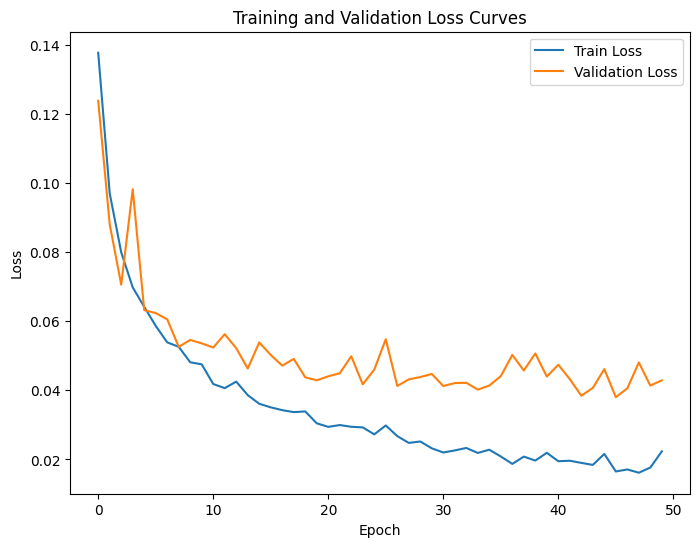

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-57-33.png
Test samples (avg ensemble):
Sample   0: Pred=3.3414, True=2.4654
Sample   1: Pred=0.1625, True=0.1334
Sample   2: Pred=3.6096, True=1.2167
Sample   3: Pred=1.2079, True=1.1593
Sample   4: Pred=0.3732, True=0.1802
Sample   5: Pred=0.0568, True=0.0600
Sample   6: Pred=5.5460, True=1.7800
Sample   7: Pred=1.9015, True=4.3986
Sample   8: Pred=0.4866, True=0.4696
Sample   9: Pred=0.0846, True=0.1055
Sample  10: Pred=0.6893, True=0.6503
Sample  11: Pred=0.8489, True=0.1610
Sample  12: Pred=0.3855, True=0.1694
Sample  13: Pred=0.2973, True=0.5143
Sample  14: Pred=2.1760, True=2.1430
Sample  15: Pred=0.2736, True=0.2603
Sample  16: Pred=0.7634, True=0.8442
Sample  17: Pred=0.1645, True=0.1382
Sample  18: Pred=0.7396, True=2.9576
Sample  19: Pred=1.6433, True=8.0533
Sample  20: Pred=0.2950, True=0.2522
Sample  21: Pred=0.0243, True=0.0144
Sample  22: Pred=0.4366, True=1.2707
Sample  23: Pred=3.2194, True=1

[INFO 03-23 16:58:12] ax.service.managed_loop: Running optimization trial 63...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

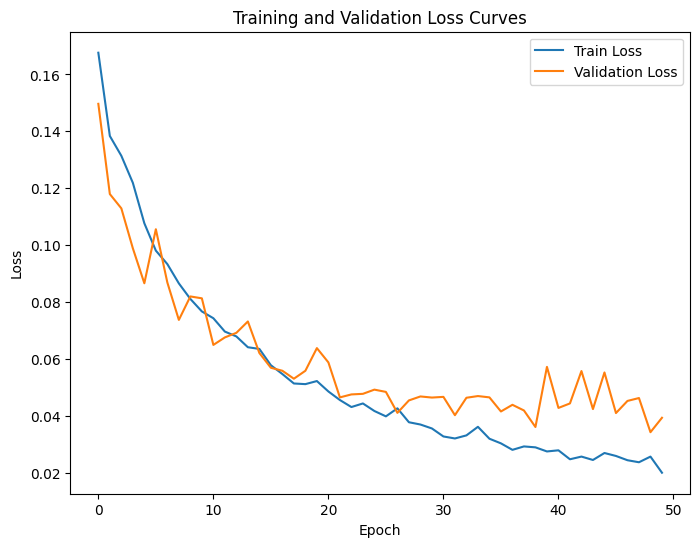

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-58-14.png
Test samples (avg ensemble):
Sample   0: Pred=1.5935, True=2.4654
Sample   1: Pred=0.0952, True=0.1334
Sample   2: Pred=3.1607, True=1.2167
Sample   3: Pred=1.5542, True=1.1593
Sample   4: Pred=0.2224, True=0.1802
Sample   5: Pred=0.0609, True=0.0600
Sample   6: Pred=13.6710, True=1.7800
Sample   7: Pred=4.0700, True=4.3986
Sample   8: Pred=0.4782, True=0.4696
Sample   9: Pred=0.0967, True=0.1055
Sample  10: Pred=0.7807, True=0.6503
Sample  11: Pred=0.3996, True=0.1610
Sample  12: Pred=0.3126, True=0.1694
Sample  13: Pred=0.2431, True=0.5143
Sample  14: Pred=2.0268, True=2.1430
Sample  15: Pred=0.2227, True=0.2603
Sample  16: Pred=0.7669, True=0.8442
Sample  17: Pred=0.1178, True=0.1382
Sample  18: Pred=1.0208, True=2.9576
Sample  19: Pred=2.8387, True=8.0533
Sample  20: Pred=0.3226, True=0.2522
Sample  21: Pred=0.0184, True=0.0144
Sample  22: Pred=1.1822, True=1.2707
Sample  23: Pred=6.5622, True=

[INFO 03-23 16:59:26] ax.service.managed_loop: Running optimization trial 64...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

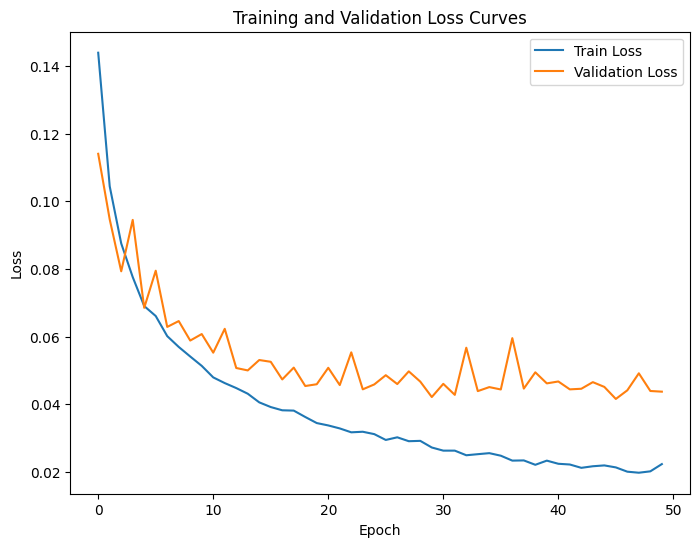

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-16-59-28.png
Test samples (avg ensemble):
Sample   0: Pred=3.2480, True=2.4654
Sample   1: Pred=0.1258, True=0.1334
Sample   2: Pred=3.1537, True=1.2167
Sample   3: Pred=1.2751, True=1.1593
Sample   4: Pred=0.1526, True=0.1802
Sample   5: Pred=0.0528, True=0.0600
Sample   6: Pred=10.4663, True=1.7800
Sample   7: Pred=1.5522, True=4.3986
Sample   8: Pred=0.5122, True=0.4696
Sample   9: Pred=0.0807, True=0.1055
Sample  10: Pred=0.5446, True=0.6503
Sample  11: Pred=1.4530, True=0.1610
Sample  12: Pred=0.2909, True=0.1694
Sample  13: Pred=0.3784, True=0.5143
Sample  14: Pred=2.2983, True=2.1430
Sample  15: Pred=0.2263, True=0.2603
Sample  16: Pred=1.0028, True=0.8442
Sample  17: Pred=0.1125, True=0.1382
Sample  18: Pred=0.4594, True=2.9576
Sample  19: Pred=2.6497, True=8.0533
Sample  20: Pred=0.2724, True=0.2522
Sample  21: Pred=0.0130, True=0.0144
Sample  22: Pred=0.6012, True=1.2707
Sample  23: Pred=2.3578, True=

[INFO 03-23 17:00:55] ax.service.managed_loop: Running optimization trial 65...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

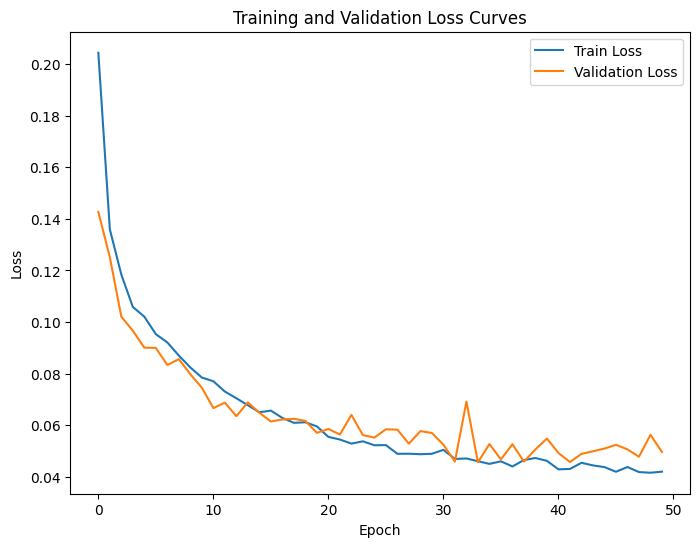

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-00-58.png
Test samples (avg ensemble):
Sample   0: Pred=0.9371, True=2.4654
Sample   1: Pred=0.0567, True=0.1334
Sample   2: Pred=0.4316, True=1.2167
Sample   3: Pred=0.5815, True=1.1593
Sample   4: Pred=0.0972, True=0.1802
Sample   5: Pred=0.0515, True=0.0600
Sample   6: Pred=7.0109, True=1.7800
Sample   7: Pred=1.4757, True=4.3986
Sample   8: Pred=0.4844, True=0.4696
Sample   9: Pred=0.0973, True=0.1055
Sample  10: Pred=0.5277, True=0.6503
Sample  11: Pred=0.7115, True=0.1610
Sample  12: Pred=0.3735, True=0.1694
Sample  13: Pred=0.2350, True=0.5143
Sample  14: Pred=2.0931, True=2.1430
Sample  15: Pred=0.2271, True=0.2603
Sample  16: Pred=0.6441, True=0.8442
Sample  17: Pred=0.0844, True=0.1382
Sample  18: Pred=0.6114, True=2.9576
Sample  19: Pred=4.5889, True=8.0533
Sample  20: Pred=0.3125, True=0.2522
Sample  21: Pred=0.0124, True=0.0144
Sample  22: Pred=1.7296, True=1.2707
Sample  23: Pred=1.8236, True=1

[INFO 03-23 17:03:04] ax.service.managed_loop: Running optimization trial 66...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

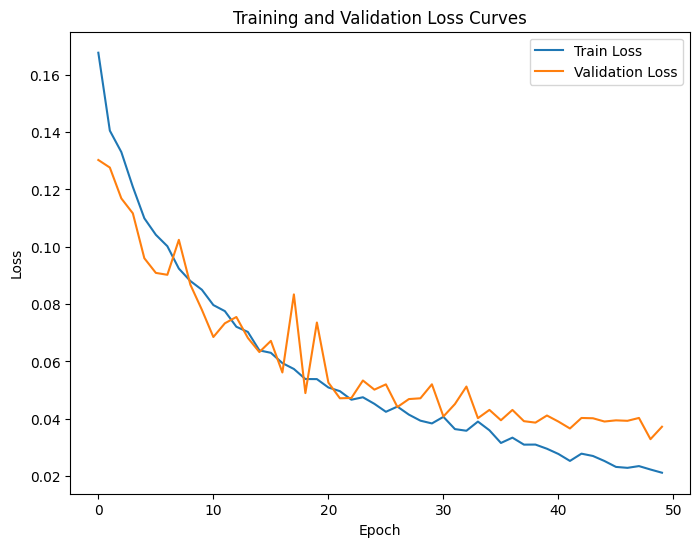

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-03-06.png
Test samples (avg ensemble):
Sample   0: Pred=2.1007, True=2.4654
Sample   1: Pred=0.1369, True=0.1334
Sample   2: Pred=1.8932, True=1.2167
Sample   3: Pred=0.7678, True=1.1593
Sample   4: Pred=0.1820, True=0.1802
Sample   5: Pred=0.0563, True=0.0600
Sample   6: Pred=10.4201, True=1.7800
Sample   7: Pred=2.7991, True=4.3986
Sample   8: Pred=0.5054, True=0.4696
Sample   9: Pred=0.0963, True=0.1055
Sample  10: Pred=0.4977, True=0.6503
Sample  11: Pred=0.4268, True=0.1610
Sample  12: Pred=0.9287, True=0.1694
Sample  13: Pred=0.3186, True=0.5143
Sample  14: Pred=1.7371, True=2.1430
Sample  15: Pred=0.2231, True=0.2603
Sample  16: Pred=0.6281, True=0.8442
Sample  17: Pred=0.1632, True=0.1382
Sample  18: Pred=1.1105, True=2.9576
Sample  19: Pred=2.5110, True=8.0533
Sample  20: Pred=0.2334, True=0.2522
Sample  21: Pred=0.0175, True=0.0144
Sample  22: Pred=0.8975, True=1.2707
Sample  23: Pred=4.3708, True=

[INFO 03-23 17:03:41] ax.service.managed_loop: Running optimization trial 67...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

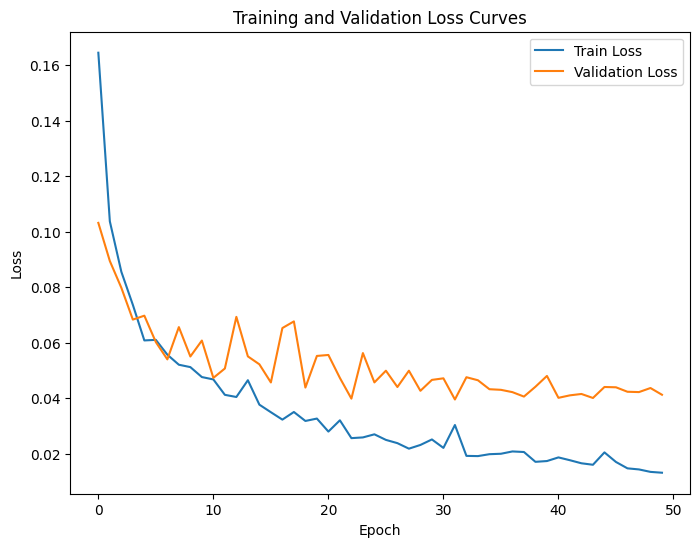

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-03-43.png
Test samples (avg ensemble):
Sample   0: Pred=1.8720, True=2.4654
Sample   1: Pred=0.1115, True=0.1334
Sample   2: Pred=12.2747, True=1.2167
Sample   3: Pred=1.1250, True=1.1593
Sample   4: Pred=0.1378, True=0.1802
Sample   5: Pred=0.0698, True=0.0600
Sample   6: Pred=5.1595, True=1.7800
Sample   7: Pred=1.6475, True=4.3986
Sample   8: Pred=0.4621, True=0.4696
Sample   9: Pred=0.0952, True=0.1055
Sample  10: Pred=0.6086, True=0.6503
Sample  11: Pred=0.4565, True=0.1610
Sample  12: Pred=0.3227, True=0.1694
Sample  13: Pred=0.2103, True=0.5143
Sample  14: Pred=2.2666, True=2.1430
Sample  15: Pred=0.2318, True=0.2603
Sample  16: Pred=0.7389, True=0.8442
Sample  17: Pred=0.1193, True=0.1382
Sample  18: Pred=0.8444, True=2.9576
Sample  19: Pred=2.4237, True=8.0533
Sample  20: Pred=0.2318, True=0.2522
Sample  21: Pred=0.0203, True=0.0144
Sample  22: Pred=1.0251, True=1.2707
Sample  23: Pred=1.8231, True=

[INFO 03-23 17:04:16] ax.service.managed_loop: Running optimization trial 68...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

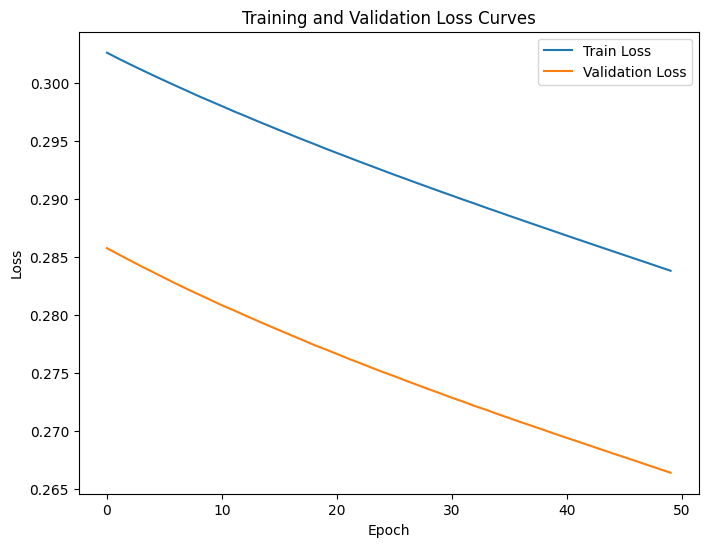

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-04-18.png
Test samples (avg ensemble):
Sample   0: Pred=0.3572, True=2.4654
Sample   1: Pred=0.4005, True=0.1334
Sample   2: Pred=0.4110, True=1.2167
Sample   3: Pred=0.4762, True=1.1593
Sample   4: Pred=0.3770, True=0.1802
Sample   5: Pred=0.4015, True=0.0600
Sample   6: Pred=0.4879, True=1.7800
Sample   7: Pred=0.4874, True=4.3986
Sample   8: Pred=0.4225, True=0.4696
Sample   9: Pred=0.4022, True=0.1055
Sample  10: Pred=0.4365, True=0.6503
Sample  11: Pred=0.5089, True=0.1610
Sample  12: Pred=0.4723, True=0.1694
Sample  13: Pred=0.3954, True=0.5143
Sample  14: Pred=0.4601, True=2.1430
Sample  15: Pred=0.4386, True=0.2603
Sample  16: Pred=0.4786, True=0.8442
Sample  17: Pred=0.4381, True=0.1382
Sample  18: Pred=0.4630, True=2.9576
Sample  19: Pred=0.3763, True=8.0533
Sample  20: Pred=0.4260, True=0.2522
Sample  21: Pred=0.3734, True=0.0144
Sample  22: Pred=0.4058, True=1.2707
Sample  23: Pred=0.3805, True=1

[INFO 03-23 17:04:27] ax.service.managed_loop: Running optimization trial 69...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

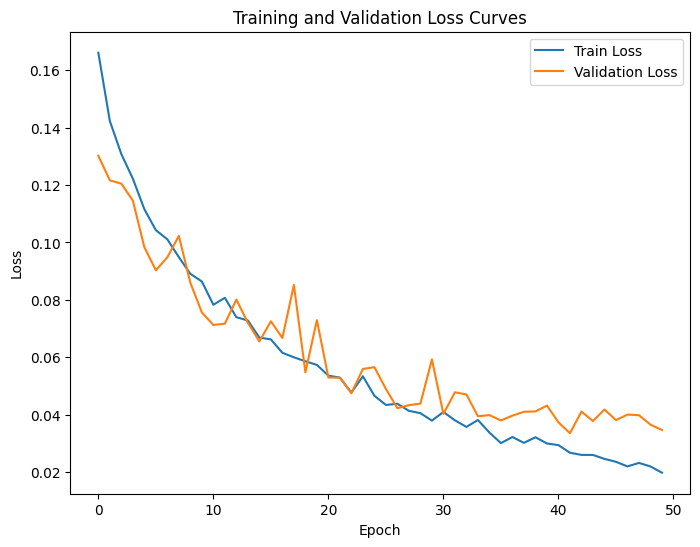

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-04-29.png
Test samples (avg ensemble):
Sample   0: Pred=1.8358, True=2.4654
Sample   1: Pred=0.1022, True=0.1334
Sample   2: Pred=2.4948, True=1.2167
Sample   3: Pred=2.2193, True=1.1593
Sample   4: Pred=0.1973, True=0.1802
Sample   5: Pred=0.0467, True=0.0600
Sample   6: Pred=10.4759, True=1.7800
Sample   7: Pred=2.1713, True=4.3986
Sample   8: Pred=0.6010, True=0.4696
Sample   9: Pred=0.0940, True=0.1055
Sample  10: Pred=0.5100, True=0.6503
Sample  11: Pred=0.4114, True=0.1610
Sample  12: Pred=1.0015, True=0.1694
Sample  13: Pred=0.2262, True=0.5143
Sample  14: Pred=1.9257, True=2.1430
Sample  15: Pred=0.2344, True=0.2603
Sample  16: Pred=0.8350, True=0.8442
Sample  17: Pred=0.1312, True=0.1382
Sample  18: Pred=1.0465, True=2.9576
Sample  19: Pred=3.8874, True=8.0533
Sample  20: Pred=0.2568, True=0.2522
Sample  21: Pred=0.0129, True=0.0144
Sample  22: Pred=1.0171, True=1.2707
Sample  23: Pred=3.9144, True=

[INFO 03-23 17:05:03] ax.service.managed_loop: Running optimization trial 70...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

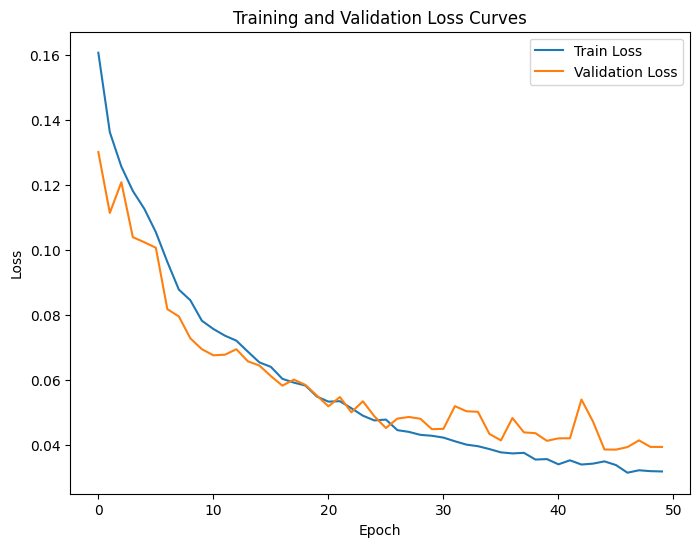

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-05-05.png
Test samples (avg ensemble):
Sample   0: Pred=1.8247, True=2.4654
Sample   1: Pred=0.1415, True=0.1334
Sample   2: Pred=1.4603, True=1.2167
Sample   3: Pred=1.3247, True=1.1593
Sample   4: Pred=0.1757, True=0.1802
Sample   5: Pred=0.0408, True=0.0600
Sample   6: Pred=14.1434, True=1.7800
Sample   7: Pred=1.2597, True=4.3986
Sample   8: Pred=0.4628, True=0.4696
Sample   9: Pred=0.1028, True=0.1055
Sample  10: Pred=0.6105, True=0.6503
Sample  11: Pred=2.0097, True=0.1610
Sample  12: Pred=0.2666, True=0.1694
Sample  13: Pred=0.1454, True=0.5143
Sample  14: Pred=3.2637, True=2.1430
Sample  15: Pred=0.3340, True=0.2603
Sample  16: Pred=0.9111, True=0.8442
Sample  17: Pred=0.1037, True=0.1382
Sample  18: Pred=0.8197, True=2.9576
Sample  19: Pred=3.4846, True=8.0533
Sample  20: Pred=0.2454, True=0.2522
Sample  21: Pred=0.0161, True=0.0144
Sample  22: Pred=1.2250, True=1.2707
Sample  23: Pred=2.1093, True=

[INFO 03-23 17:06:25] ax.service.managed_loop: Running optimization trial 71...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

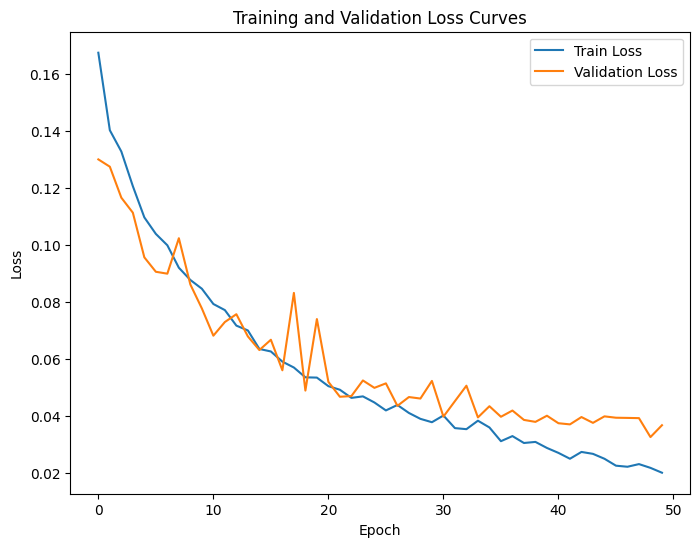

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-06-27.png
Test samples (avg ensemble):
Sample   0: Pred=2.0087, True=2.4654
Sample   1: Pred=0.1325, True=0.1334
Sample   2: Pred=2.7196, True=1.2167
Sample   3: Pred=0.7220, True=1.1593
Sample   4: Pred=0.1733, True=0.1802
Sample   5: Pred=0.0527, True=0.0600
Sample   6: Pred=8.9137, True=1.7800
Sample   7: Pred=3.2429, True=4.3986
Sample   8: Pred=0.5429, True=0.4696
Sample   9: Pred=0.0907, True=0.1055
Sample  10: Pred=0.4766, True=0.6503
Sample  11: Pred=0.4765, True=0.1610
Sample  12: Pred=0.9038, True=0.1694
Sample  13: Pred=0.3591, True=0.5143
Sample  14: Pred=1.6675, True=2.1430
Sample  15: Pred=0.2416, True=0.2603
Sample  16: Pred=0.6496, True=0.8442
Sample  17: Pred=0.1583, True=0.1382
Sample  18: Pred=1.0485, True=2.9576
Sample  19: Pred=3.0469, True=8.0533
Sample  20: Pred=0.2320, True=0.2522
Sample  21: Pred=0.0163, True=0.0144
Sample  22: Pred=0.9028, True=1.2707
Sample  23: Pred=4.6453, True=1

[INFO 03-23 17:07:00] ax.service.managed_loop: Running optimization trial 72...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

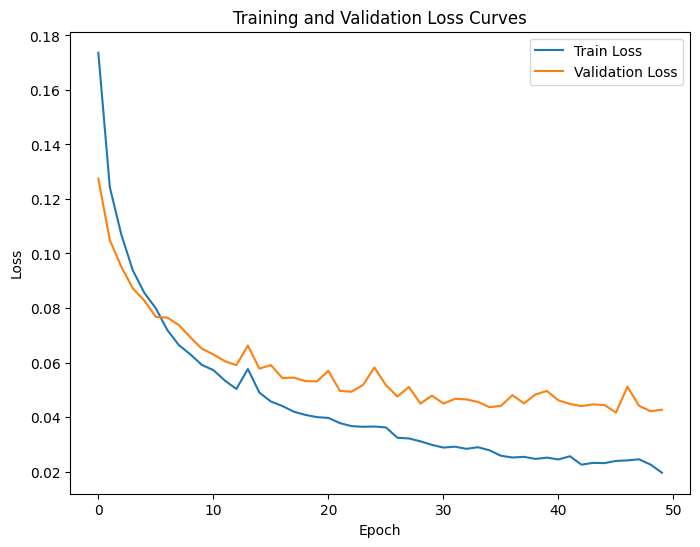

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-07-02.png
Test samples (avg ensemble):
Sample   0: Pred=1.5229, True=2.4654
Sample   1: Pred=0.1149, True=0.1334
Sample   2: Pred=2.0078, True=1.2167
Sample   3: Pred=1.7934, True=1.1593
Sample   4: Pred=0.1688, True=0.1802
Sample   5: Pred=0.0439, True=0.0600
Sample   6: Pred=15.5259, True=1.7800
Sample   7: Pred=1.4139, True=4.3986
Sample   8: Pred=0.5616, True=0.4696
Sample   9: Pred=0.0917, True=0.1055
Sample  10: Pred=0.4797, True=0.6503
Sample  11: Pred=0.9047, True=0.1610
Sample  12: Pred=0.2346, True=0.1694
Sample  13: Pred=0.3098, True=0.5143
Sample  14: Pred=2.1961, True=2.1430
Sample  15: Pred=0.2718, True=0.2603
Sample  16: Pred=0.8232, True=0.8442
Sample  17: Pred=0.1258, True=0.1382
Sample  18: Pred=0.6882, True=2.9576
Sample  19: Pred=1.3328, True=8.0533
Sample  20: Pred=0.2265, True=0.2522
Sample  21: Pred=0.0153, True=0.0144
Sample  22: Pred=1.2848, True=1.2707
Sample  23: Pred=1.5416, True=

[INFO 03-23 17:07:10] ax.service.managed_loop: Running optimization trial 73...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

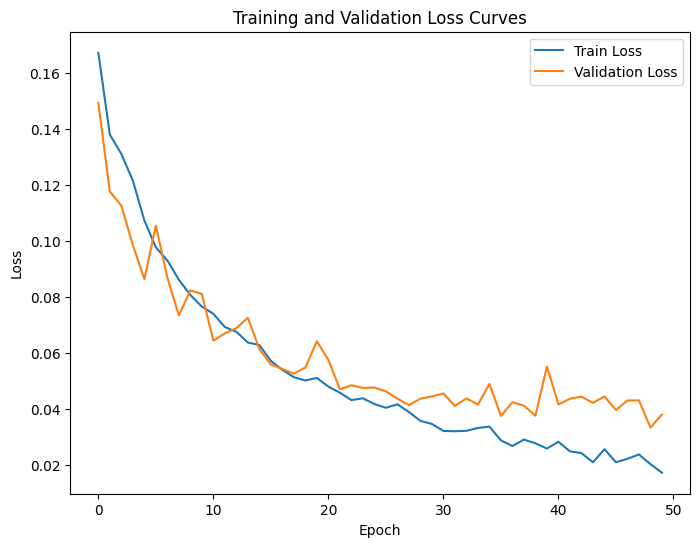

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-07-13.png
Test samples (avg ensemble):
Sample   0: Pred=1.9488, True=2.4654
Sample   1: Pred=0.1379, True=0.1334
Sample   2: Pred=6.9414, True=1.2167
Sample   3: Pred=1.7160, True=1.1593
Sample   4: Pred=0.2479, True=0.1802
Sample   5: Pred=0.0793, True=0.0600
Sample   6: Pred=8.9654, True=1.7800
Sample   7: Pred=1.0144, True=4.3986
Sample   8: Pred=0.5562, True=0.4696
Sample   9: Pred=0.0960, True=0.1055
Sample  10: Pred=0.6419, True=0.6503
Sample  11: Pred=0.4127, True=0.1610
Sample  12: Pred=0.3449, True=0.1694
Sample  13: Pred=0.4706, True=0.5143
Sample  14: Pred=1.9556, True=2.1430
Sample  15: Pred=0.3483, True=0.2603
Sample  16: Pred=0.6533, True=0.8442
Sample  17: Pred=0.1628, True=0.1382
Sample  18: Pred=1.1093, True=2.9576
Sample  19: Pred=3.0842, True=8.0533
Sample  20: Pred=0.2622, True=0.2522
Sample  21: Pred=0.0194, True=0.0144
Sample  22: Pred=1.2440, True=1.2707
Sample  23: Pred=7.3023, True=1

[INFO 03-23 17:08:20] ax.service.managed_loop: Running optimization trial 74...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

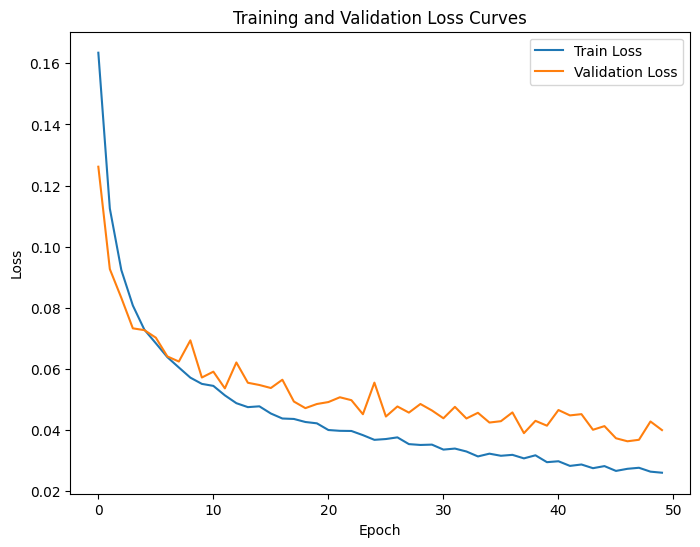

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-08-23.png
Test samples (avg ensemble):
Sample   0: Pred=3.6873, True=2.4654
Sample   1: Pred=0.0881, True=0.1334
Sample   2: Pred=1.5028, True=1.2167
Sample   3: Pred=1.2030, True=1.1593
Sample   4: Pred=0.1488, True=0.1802
Sample   5: Pred=0.0515, True=0.0600
Sample   6: Pred=10.3019, True=1.7800
Sample   7: Pred=1.5928, True=4.3986
Sample   8: Pred=0.5955, True=0.4696
Sample   9: Pred=0.0880, True=0.1055
Sample  10: Pred=0.5842, True=0.6503
Sample  11: Pred=0.7811, True=0.1610
Sample  12: Pred=0.3809, True=0.1694
Sample  13: Pred=0.2215, True=0.5143
Sample  14: Pred=2.0336, True=2.1430
Sample  15: Pred=0.2755, True=0.2603
Sample  16: Pred=0.7806, True=0.8442
Sample  17: Pred=0.1257, True=0.1382
Sample  18: Pred=0.8780, True=2.9576
Sample  19: Pred=3.6934, True=8.0533
Sample  20: Pred=0.2086, True=0.2522
Sample  21: Pred=0.0102, True=0.0144
Sample  22: Pred=1.3288, True=1.2707
Sample  23: Pred=1.6028, True=

[INFO 03-23 17:09:40] ax.service.managed_loop: Running optimization trial 75...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

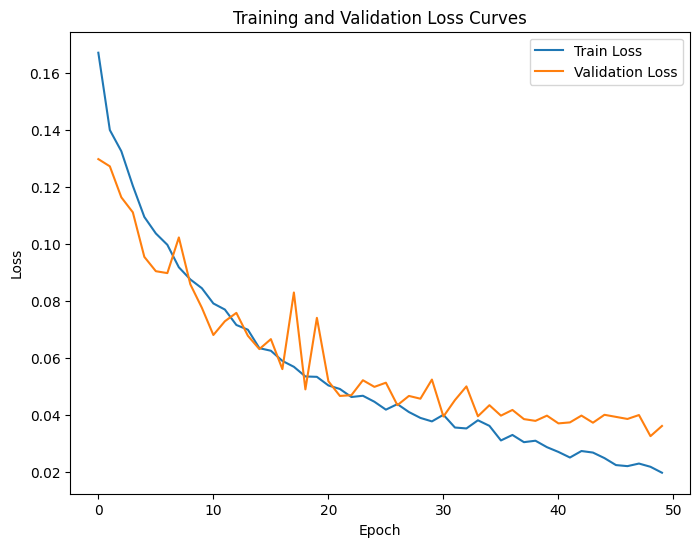

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-09-42.png
Test samples (avg ensemble):
Sample   0: Pred=2.0155, True=2.4654
Sample   1: Pred=0.1332, True=0.1334
Sample   2: Pred=2.8095, True=1.2167
Sample   3: Pred=0.7124, True=1.1593
Sample   4: Pred=0.1805, True=0.1802
Sample   5: Pred=0.0511, True=0.0600
Sample   6: Pred=8.2850, True=1.7800
Sample   7: Pred=3.4934, True=4.3986
Sample   8: Pred=0.5551, True=0.4696
Sample   9: Pred=0.0901, True=0.1055
Sample  10: Pred=0.4729, True=0.6503
Sample  11: Pred=0.4761, True=0.1610
Sample  12: Pred=0.8942, True=0.1694
Sample  13: Pred=0.3416, True=0.5143
Sample  14: Pred=1.6819, True=2.1430
Sample  15: Pred=0.2435, True=0.2603
Sample  16: Pred=0.6595, True=0.8442
Sample  17: Pred=0.1608, True=0.1382
Sample  18: Pred=1.0797, True=2.9576
Sample  19: Pred=3.1693, True=8.0533
Sample  20: Pred=0.2395, True=0.2522
Sample  21: Pred=0.0151, True=0.0144
Sample  22: Pred=0.8680, True=1.2707
Sample  23: Pred=4.5328, True=1

[INFO 03-23 17:10:19] ax.service.managed_loop: Running optimization trial 76...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

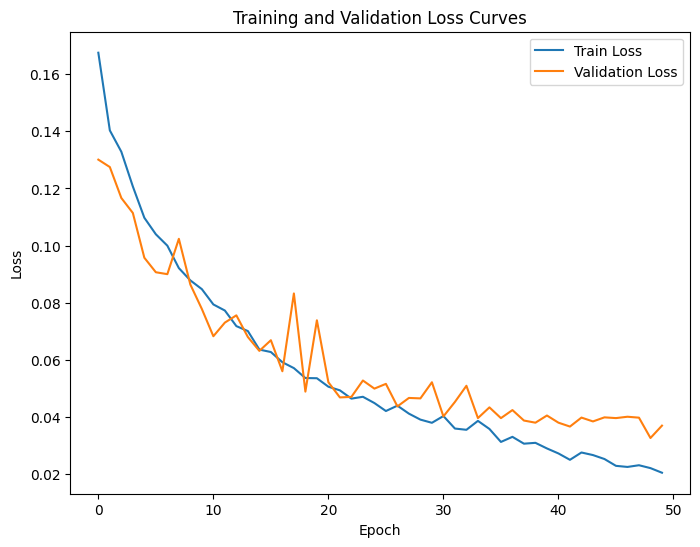

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-10-21.png
Test samples (avg ensemble):
Sample   0: Pred=2.0122, True=2.4654
Sample   1: Pred=0.1301, True=0.1334
Sample   2: Pred=2.4210, True=1.2167
Sample   3: Pred=0.7550, True=1.1593
Sample   4: Pred=0.1717, True=0.1802
Sample   5: Pred=0.0522, True=0.0600
Sample   6: Pred=9.8622, True=1.7800
Sample   7: Pred=2.9850, True=4.3986
Sample   8: Pred=0.5332, True=0.4696
Sample   9: Pred=0.0936, True=0.1055
Sample  10: Pred=0.4854, True=0.6503
Sample  11: Pred=0.4479, True=0.1610
Sample  12: Pred=0.9344, True=0.1694
Sample  13: Pred=0.3596, True=0.5143
Sample  14: Pred=1.6872, True=2.1430
Sample  15: Pred=0.2354, True=0.2603
Sample  16: Pred=0.6336, True=0.8442
Sample  17: Pred=0.1562, True=0.1382
Sample  18: Pred=1.0996, True=2.9576
Sample  19: Pred=2.8661, True=8.0533
Sample  20: Pred=0.2323, True=0.2522
Sample  21: Pred=0.0171, True=0.0144
Sample  22: Pred=0.9301, True=1.2707
Sample  23: Pred=4.6415, True=1

[INFO 03-23 17:10:58] ax.service.managed_loop: Running optimization trial 77...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

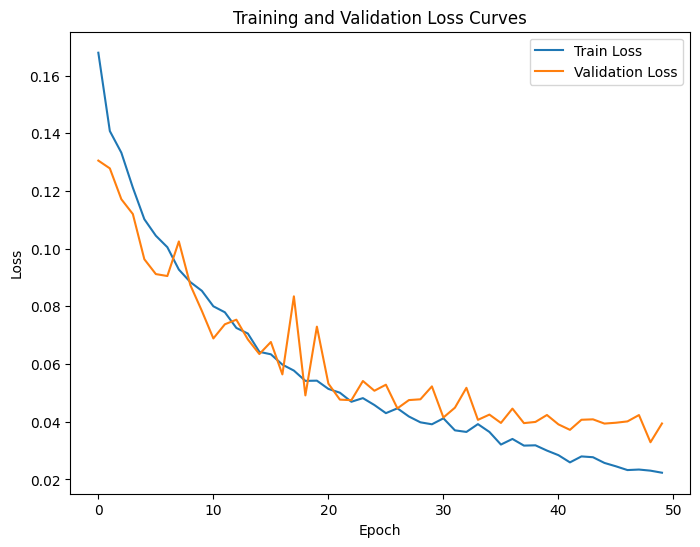

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-11-01.png
Test samples (avg ensemble):
Sample   0: Pred=2.0966, True=2.4654
Sample   1: Pred=0.1398, True=0.1334
Sample   2: Pred=1.6161, True=1.2167
Sample   3: Pred=0.7605, True=1.1593
Sample   4: Pred=0.1801, True=0.1802
Sample   5: Pred=0.0582, True=0.0600
Sample   6: Pred=11.2047, True=1.7800
Sample   7: Pred=2.6635, True=4.3986
Sample   8: Pred=0.4992, True=0.4696
Sample   9: Pred=0.1031, True=0.1055
Sample  10: Pred=0.4949, True=0.6503
Sample  11: Pred=0.4159, True=0.1610
Sample  12: Pred=0.8287, True=0.1694
Sample  13: Pred=0.2709, True=0.5143
Sample  14: Pred=1.7046, True=2.1430
Sample  15: Pred=0.2387, True=0.2603
Sample  16: Pred=0.6421, True=0.8442
Sample  17: Pred=0.1698, True=0.1382
Sample  18: Pred=1.0858, True=2.9576
Sample  19: Pred=2.4930, True=8.0533
Sample  20: Pred=0.2337, True=0.2522
Sample  21: Pred=0.0171, True=0.0144
Sample  22: Pred=0.7545, True=1.2707
Sample  23: Pred=3.6748, True=

[INFO 03-23 17:11:37] ax.service.managed_loop: Running optimization trial 78...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

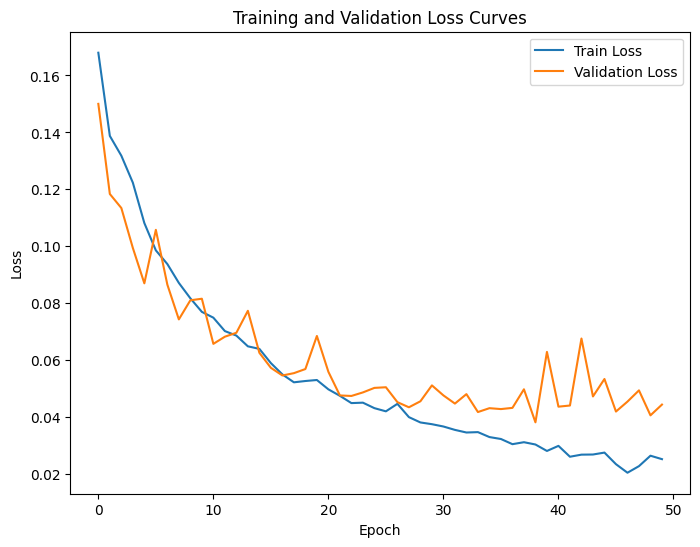

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-11-40.png
Test samples (avg ensemble):
Sample   0: Pred=1.9320, True=2.4654
Sample   1: Pred=0.1320, True=0.1334
Sample   2: Pred=3.4476, True=1.2167
Sample   3: Pred=0.8802, True=1.1593
Sample   4: Pred=0.2834, True=0.1802
Sample   5: Pred=0.0629, True=0.0600
Sample   6: Pred=9.4790, True=1.7800
Sample   7: Pred=1.4883, True=4.3986
Sample   8: Pred=0.5490, True=0.4696
Sample   9: Pred=0.0906, True=0.1055
Sample  10: Pred=0.5848, True=0.6503
Sample  11: Pred=0.2824, True=0.1610
Sample  12: Pred=0.3241, True=0.1694
Sample  13: Pred=0.7284, True=0.5143
Sample  14: Pred=1.9852, True=2.1430
Sample  15: Pred=0.2576, True=0.2603
Sample  16: Pred=0.6453, True=0.8442
Sample  17: Pred=0.1527, True=0.1382
Sample  18: Pred=0.7975, True=2.9576
Sample  19: Pred=1.8913, True=8.0533
Sample  20: Pred=0.2892, True=0.2522
Sample  21: Pred=0.0190, True=0.0144
Sample  22: Pred=0.8460, True=1.2707
Sample  23: Pred=4.1659, True=1

[INFO 03-23 17:12:47] ax.service.managed_loop: Running optimization trial 79...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

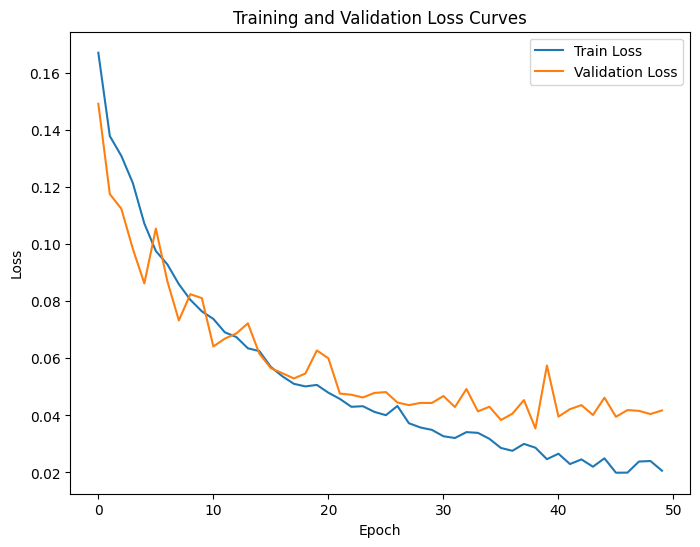

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-12-49.png
Test samples (avg ensemble):
Sample   0: Pred=1.8201, True=2.4654
Sample   1: Pred=0.1188, True=0.1334
Sample   2: Pred=2.8693, True=1.2167
Sample   3: Pred=1.6050, True=1.1593
Sample   4: Pred=0.2562, True=0.1802
Sample   5: Pred=0.0556, True=0.0600
Sample   6: Pred=13.3657, True=1.7800
Sample   7: Pred=1.1699, True=4.3986
Sample   8: Pred=0.5513, True=0.4696
Sample   9: Pred=0.0894, True=0.1055
Sample  10: Pred=0.7271, True=0.6503
Sample  11: Pred=0.3437, True=0.1610
Sample  12: Pred=0.2183, True=0.1694
Sample  13: Pred=0.4964, True=0.5143
Sample  14: Pred=2.5051, True=2.1430
Sample  15: Pred=0.2347, True=0.2603
Sample  16: Pred=0.4761, True=0.8442
Sample  17: Pred=0.1230, True=0.1382
Sample  18: Pred=1.0496, True=2.9576
Sample  19: Pred=2.5771, True=8.0533
Sample  20: Pred=0.3006, True=0.2522
Sample  21: Pred=0.0190, True=0.0144
Sample  22: Pred=1.3386, True=1.2707
Sample  23: Pred=4.4341, True=

[INFO 03-23 17:13:58] ax.service.managed_loop: Running optimization trial 80...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

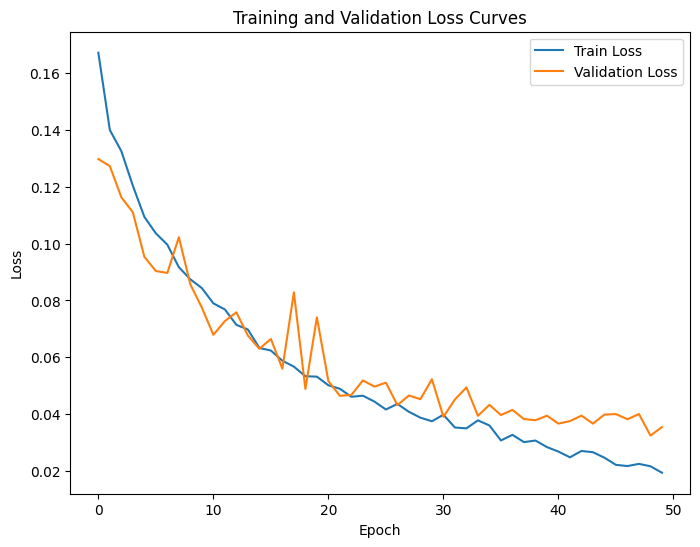

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-14-00.png
Test samples (avg ensemble):
Sample   0: Pred=1.9074, True=2.4654
Sample   1: Pred=0.1276, True=0.1334
Sample   2: Pred=2.5999, True=1.2167
Sample   3: Pred=0.7060, True=1.1593
Sample   4: Pred=0.1810, True=0.1802
Sample   5: Pred=0.0486, True=0.0600
Sample   6: Pred=7.7581, True=1.7800
Sample   7: Pred=3.9051, True=4.3986
Sample   8: Pred=0.5940, True=0.4696
Sample   9: Pred=0.0946, True=0.1055
Sample  10: Pred=0.4906, True=0.6503
Sample  11: Pred=0.4686, True=0.1610
Sample  12: Pred=0.8372, True=0.1694
Sample  13: Pred=0.3340, True=0.5143
Sample  14: Pred=1.7725, True=2.1430
Sample  15: Pred=0.2393, True=0.2603
Sample  16: Pred=0.6836, True=0.8442
Sample  17: Pred=0.1555, True=0.1382
Sample  18: Pred=1.1293, True=2.9576
Sample  19: Pred=3.5753, True=8.0533
Sample  20: Pred=0.2534, True=0.2522
Sample  21: Pred=0.0151, True=0.0144
Sample  22: Pred=0.9038, True=1.2707
Sample  23: Pred=4.5620, True=1

[INFO 03-23 17:14:35] ax.service.managed_loop: Running optimization trial 81...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

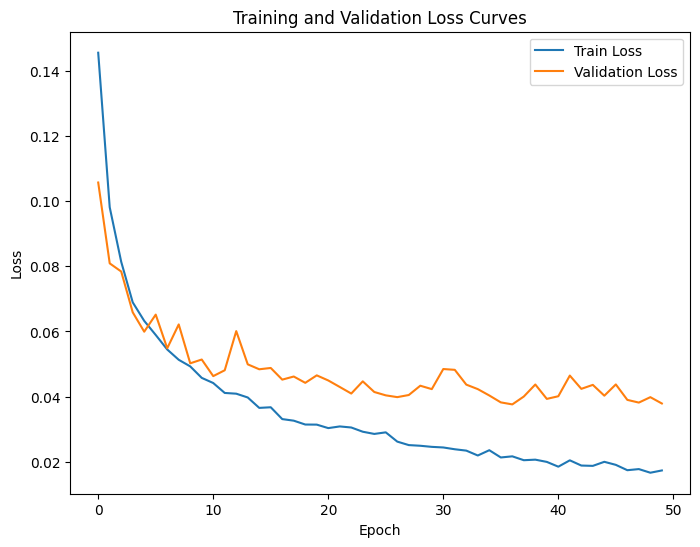

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-14-37.png
Test samples (avg ensemble):
Sample   0: Pred=2.4049, True=2.4654
Sample   1: Pred=0.0928, True=0.1334
Sample   2: Pred=6.0141, True=1.2167
Sample   3: Pred=0.9649, True=1.1593
Sample   4: Pred=0.1925, True=0.1802
Sample   5: Pred=0.0411, True=0.0600
Sample   6: Pred=7.2249, True=1.7800
Sample   7: Pred=2.1633, True=4.3986
Sample   8: Pred=0.4432, True=0.4696
Sample   9: Pred=0.0963, True=0.1055
Sample  10: Pred=0.6343, True=0.6503
Sample  11: Pred=1.5100, True=0.1610
Sample  12: Pred=0.3686, True=0.1694
Sample  13: Pred=0.3727, True=0.5143
Sample  14: Pred=2.3479, True=2.1430
Sample  15: Pred=0.2713, True=0.2603
Sample  16: Pred=0.9655, True=0.8442
Sample  17: Pred=0.1473, True=0.1382
Sample  18: Pred=0.7184, True=2.9576
Sample  19: Pred=1.6434, True=8.0533
Sample  20: Pred=0.2347, True=0.2522
Sample  21: Pred=0.0144, True=0.0144
Sample  22: Pred=0.7571, True=1.2707
Sample  23: Pred=1.9921, True=1

[INFO 03-23 17:15:59] ax.service.managed_loop: Running optimization trial 82...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

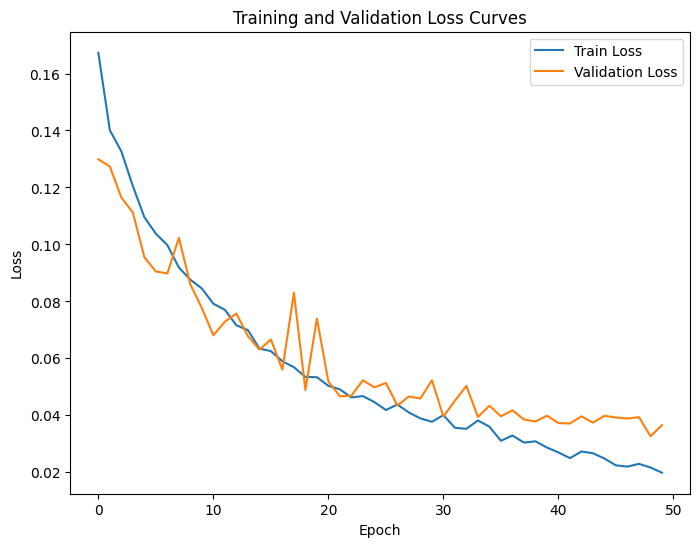

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-16-01.png
Test samples (avg ensemble):
Sample   0: Pred=2.0330, True=2.4654
Sample   1: Pred=0.1332, True=0.1334
Sample   2: Pred=2.8235, True=1.2167
Sample   3: Pred=0.7104, True=1.1593
Sample   4: Pred=0.1751, True=0.1802
Sample   5: Pred=0.0522, True=0.0600
Sample   6: Pred=8.7543, True=1.7800
Sample   7: Pred=3.3400, True=4.3986
Sample   8: Pred=0.5447, True=0.4696
Sample   9: Pred=0.0891, True=0.1055
Sample  10: Pred=0.4770, True=0.6503
Sample  11: Pred=0.4865, True=0.1610
Sample  12: Pred=0.9010, True=0.1694
Sample  13: Pred=0.3533, True=0.5143
Sample  14: Pred=1.6713, True=2.1430
Sample  15: Pred=0.2422, True=0.2603
Sample  16: Pred=0.6555, True=0.8442
Sample  17: Pred=0.1599, True=0.1382
Sample  18: Pred=1.0471, True=2.9576
Sample  19: Pred=3.0572, True=8.0533
Sample  20: Pred=0.2345, True=0.2522
Sample  21: Pred=0.0156, True=0.0144
Sample  22: Pred=0.8805, True=1.2707
Sample  23: Pred=4.6118, True=1

[INFO 03-23 17:16:39] ax.service.managed_loop: Running optimization trial 83...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

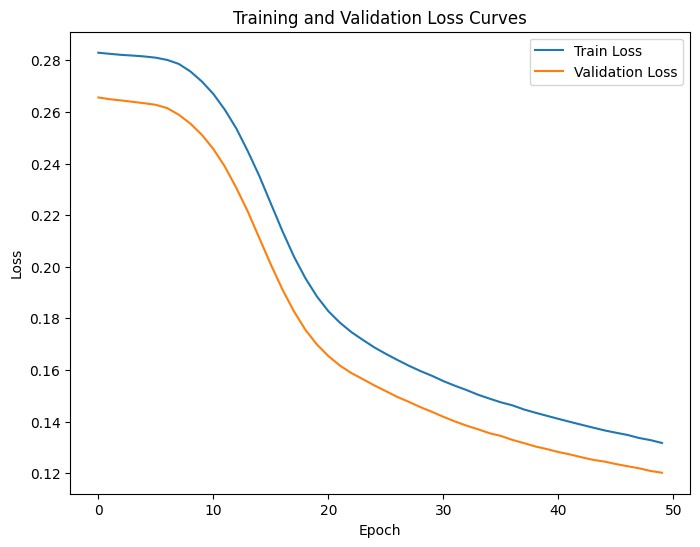

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-16-41.png
Test samples (avg ensemble):
Sample   0: Pred=0.6239, True=2.4654
Sample   1: Pred=0.1047, True=0.1334
Sample   2: Pred=0.5648, True=1.2167
Sample   3: Pred=0.9114, True=1.1593
Sample   4: Pred=0.0796, True=0.1802
Sample   5: Pred=0.3333, True=0.0600
Sample   6: Pred=1.3895, True=1.7800
Sample   7: Pred=1.5389, True=4.3986
Sample   8: Pred=0.4320, True=0.4696
Sample   9: Pred=0.0335, True=0.1055
Sample  10: Pred=1.0394, True=0.6503
Sample  11: Pred=0.3087, True=0.1610
Sample  12: Pred=0.3612, True=0.1694
Sample  13: Pred=0.4389, True=0.5143
Sample  14: Pred=1.4605, True=2.1430
Sample  15: Pred=0.1664, True=0.2603
Sample  16: Pred=1.0330, True=0.8442
Sample  17: Pred=0.1188, True=0.1382
Sample  18: Pred=1.3743, True=2.9576
Sample  19: Pred=1.8979, True=8.0533
Sample  20: Pred=0.4107, True=0.2522
Sample  21: Pred=0.0234, True=0.0144
Sample  22: Pred=1.2617, True=1.2707
Sample  23: Pred=0.7757, True=1

[INFO 03-23 17:16:52] ax.service.managed_loop: Running optimization trial 84...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

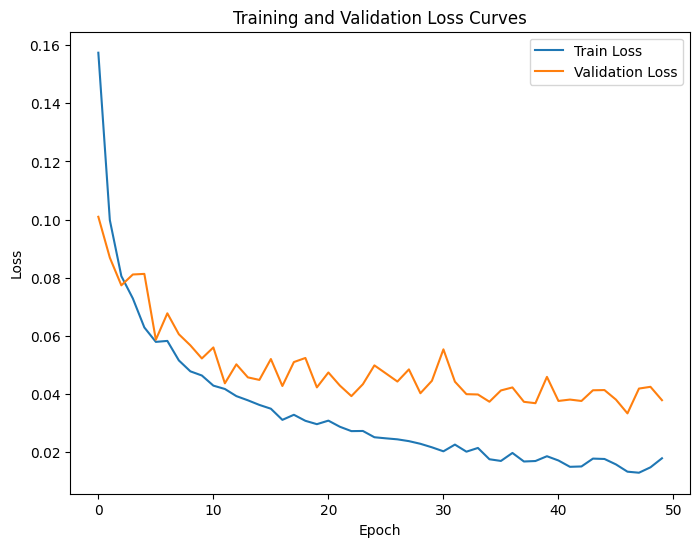

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-16-54.png
Test samples (avg ensemble):
Sample   0: Pred=1.9693, True=2.4654
Sample   1: Pred=0.1102, True=0.1334
Sample   2: Pred=2.3751, True=1.2167
Sample   3: Pred=0.6680, True=1.1593
Sample   4: Pred=0.1452, True=0.1802
Sample   5: Pred=0.0565, True=0.0600
Sample   6: Pred=10.9002, True=1.7800
Sample   7: Pred=4.0701, True=4.3986
Sample   8: Pred=0.5693, True=0.4696
Sample   9: Pred=0.0925, True=0.1055
Sample  10: Pred=0.6424, True=0.6503
Sample  11: Pred=0.5447, True=0.1610
Sample  12: Pred=0.2353, True=0.1694
Sample  13: Pred=0.2883, True=0.5143
Sample  14: Pred=2.4745, True=2.1430
Sample  15: Pred=0.1557, True=0.2603
Sample  16: Pred=0.7477, True=0.8442
Sample  17: Pred=0.1453, True=0.1382
Sample  18: Pred=0.7567, True=2.9576
Sample  19: Pred=2.2379, True=8.0533
Sample  20: Pred=0.2644, True=0.2522
Sample  21: Pred=0.0156, True=0.0144
Sample  22: Pred=1.0991, True=1.2707
Sample  23: Pred=3.5774, True=

[INFO 03-23 17:18:52] ax.service.managed_loop: Running optimization trial 85...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

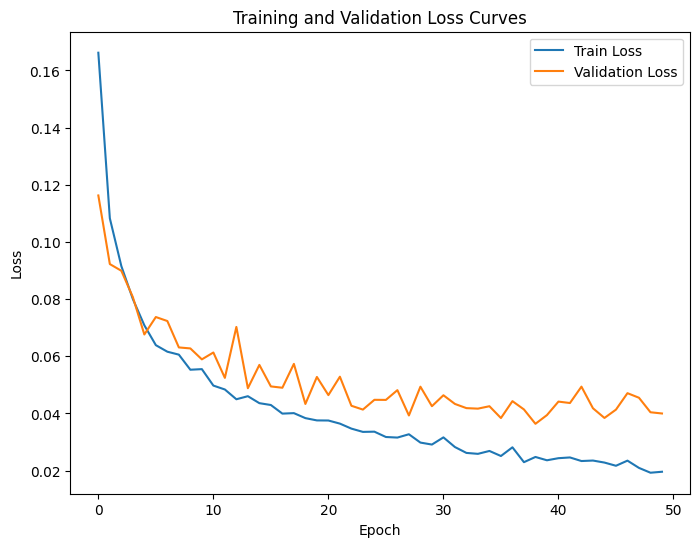

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-18-55.png
Test samples (avg ensemble):
Sample   0: Pred=2.6304, True=2.4654
Sample   1: Pred=0.1099, True=0.1334
Sample   2: Pred=3.1794, True=1.2167
Sample   3: Pred=1.7426, True=1.1593
Sample   4: Pred=0.2025, True=0.1802
Sample   5: Pred=0.0496, True=0.0600
Sample   6: Pred=16.0609, True=1.7800
Sample   7: Pred=0.4601, True=4.3986
Sample   8: Pred=0.4798, True=0.4696
Sample   9: Pred=0.1327, True=0.1055
Sample  10: Pred=0.7697, True=0.6503
Sample  11: Pred=1.0773, True=0.1610
Sample  12: Pred=0.3723, True=0.1694
Sample  13: Pred=0.2921, True=0.5143
Sample  14: Pred=2.4051, True=2.1430
Sample  15: Pred=0.1887, True=0.2603
Sample  16: Pred=0.6073, True=0.8442
Sample  17: Pred=0.1063, True=0.1382
Sample  18: Pred=0.8764, True=2.9576
Sample  19: Pred=2.9543, True=8.0533
Sample  20: Pred=0.2725, True=0.2522
Sample  21: Pred=0.0167, True=0.0144
Sample  22: Pred=1.0031, True=1.2707
Sample  23: Pred=3.3099, True=

[INFO 03-23 17:20:48] ax.service.managed_loop: Running optimization trial 86...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

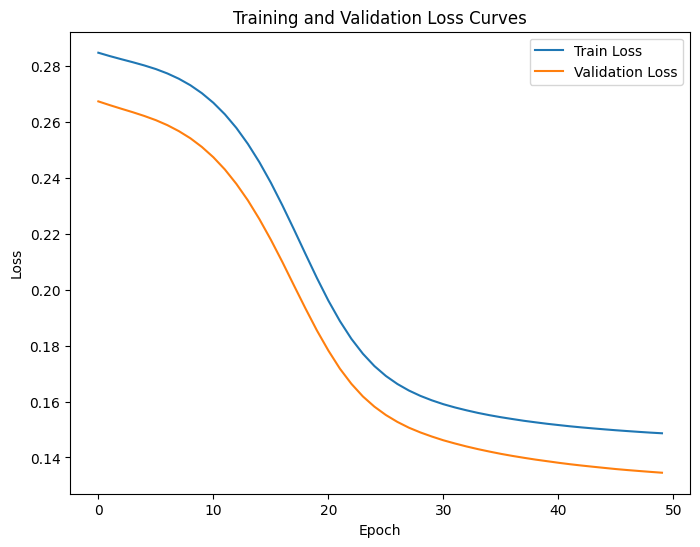

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-20-50.png
Test samples (avg ensemble):
Sample   0: Pred=0.4214, True=2.4654
Sample   1: Pred=0.0874, True=0.1334
Sample   2: Pred=0.6731, True=1.2167
Sample   3: Pred=0.7330, True=1.1593
Sample   4: Pred=0.0739, True=0.1802
Sample   5: Pred=0.2770, True=0.0600
Sample   6: Pred=1.6224, True=1.7800
Sample   7: Pred=2.1219, True=4.3986
Sample   8: Pred=0.4003, True=0.4696
Sample   9: Pred=0.0679, True=0.1055
Sample  10: Pred=1.8726, True=0.6503
Sample  11: Pred=0.2805, True=0.1610
Sample  12: Pred=0.3045, True=0.1694
Sample  13: Pred=0.4382, True=0.5143
Sample  14: Pred=1.2192, True=2.1430
Sample  15: Pred=0.1396, True=0.2603
Sample  16: Pred=1.3136, True=0.8442
Sample  17: Pred=0.1011, True=0.1382
Sample  18: Pred=1.3681, True=2.9576
Sample  19: Pred=2.0582, True=8.0533
Sample  20: Pred=0.7048, True=0.2522
Sample  21: Pred=0.0508, True=0.0144
Sample  22: Pred=1.0708, True=1.2707
Sample  23: Pred=0.8699, True=1

[INFO 03-23 17:22:48] ax.service.managed_loop: Running optimization trial 87...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

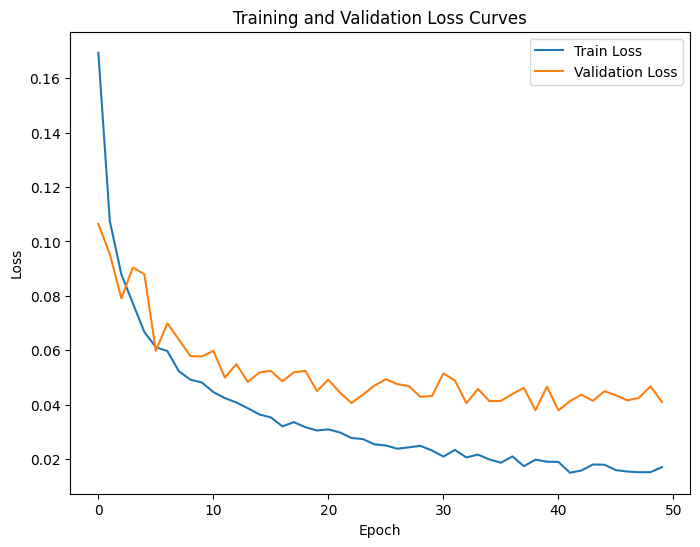

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-22-49.png
Test samples (avg ensemble):
Sample   0: Pred=1.9668, True=2.4654
Sample   1: Pred=0.1199, True=0.1334
Sample   2: Pred=2.3058, True=1.2167
Sample   3: Pred=0.6579, True=1.1593
Sample   4: Pred=0.1508, True=0.1802
Sample   5: Pred=0.0593, True=0.0600
Sample   6: Pred=12.5809, True=1.7800
Sample   7: Pred=2.1176, True=4.3986
Sample   8: Pred=0.6824, True=0.4696
Sample   9: Pred=0.0765, True=0.1055
Sample  10: Pred=0.6359, True=0.6503
Sample  11: Pred=0.6034, True=0.1610
Sample  12: Pred=0.3259, True=0.1694
Sample  13: Pred=0.3100, True=0.5143
Sample  14: Pred=2.4904, True=2.1430
Sample  15: Pred=0.1663, True=0.2603
Sample  16: Pred=0.7761, True=0.8442
Sample  17: Pred=0.1560, True=0.1382
Sample  18: Pred=0.7374, True=2.9576
Sample  19: Pred=2.8524, True=8.0533
Sample  20: Pred=0.2497, True=0.2522
Sample  21: Pred=0.0135, True=0.0144
Sample  22: Pred=1.2462, True=1.2707
Sample  23: Pred=4.9823, True=

[INFO 03-23 17:24:56] ax.service.managed_loop: Running optimization trial 88...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

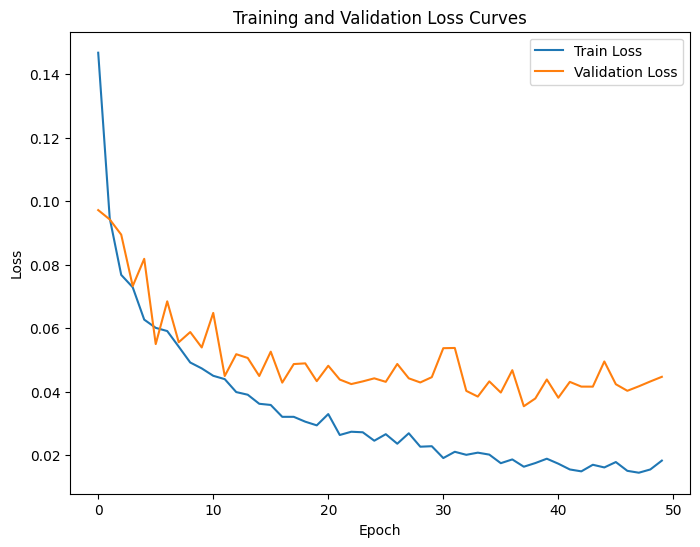

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-24-58.png
Test samples (avg ensemble):
Sample   0: Pred=2.0861, True=2.4654
Sample   1: Pred=0.1068, True=0.1334
Sample   2: Pred=9.1528, True=1.2167
Sample   3: Pred=0.5563, True=1.1593
Sample   4: Pred=0.1463, True=0.1802
Sample   5: Pred=0.0534, True=0.0600
Sample   6: Pred=13.5766, True=1.7800
Sample   7: Pred=1.7825, True=4.3986
Sample   8: Pred=0.6494, True=0.4696
Sample   9: Pred=0.0821, True=0.1055
Sample  10: Pred=0.6133, True=0.6503
Sample  11: Pred=0.3775, True=0.1610
Sample  12: Pred=0.4369, True=0.1694
Sample  13: Pred=0.2402, True=0.5143
Sample  14: Pred=2.4446, True=2.1430
Sample  15: Pred=0.2036, True=0.2603
Sample  16: Pred=0.9909, True=0.8442
Sample  17: Pred=0.1347, True=0.1382
Sample  18: Pred=1.0379, True=2.9576
Sample  19: Pred=1.4631, True=8.0533
Sample  20: Pred=0.2572, True=0.2522
Sample  21: Pred=0.0165, True=0.0144
Sample  22: Pred=0.9071, True=1.2707
Sample  23: Pred=2.6419, True=

[INFO 03-23 17:27:06] ax.service.managed_loop: Running optimization trial 89...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

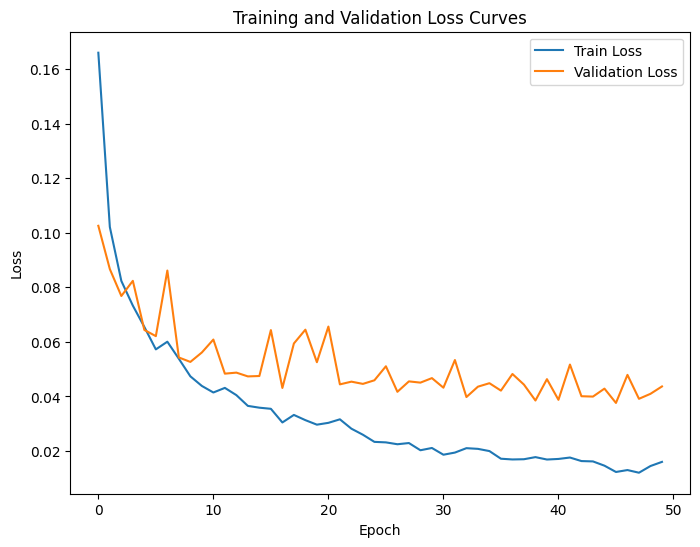

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-27-09.png
Test samples (avg ensemble):
Sample   0: Pred=2.4256, True=2.4654
Sample   1: Pred=0.1142, True=0.1334
Sample   2: Pred=2.4311, True=1.2167
Sample   3: Pred=0.6096, True=1.1593
Sample   4: Pred=0.1940, True=0.1802
Sample   5: Pred=0.0579, True=0.0600
Sample   6: Pred=9.1037, True=1.7800
Sample   7: Pred=4.9404, True=4.3986
Sample   8: Pred=0.5656, True=0.4696
Sample   9: Pred=0.1147, True=0.1055
Sample  10: Pred=0.6845, True=0.6503
Sample  11: Pred=0.5695, True=0.1610
Sample  12: Pred=0.4760, True=0.1694
Sample  13: Pred=0.2726, True=0.5143
Sample  14: Pred=2.1020, True=2.1430
Sample  15: Pred=0.1923, True=0.2603
Sample  16: Pred=0.9887, True=0.8442
Sample  17: Pred=0.1495, True=0.1382
Sample  18: Pred=0.6964, True=2.9576
Sample  19: Pred=3.1619, True=8.0533
Sample  20: Pred=0.2544, True=0.2522
Sample  21: Pred=0.0179, True=0.0144
Sample  22: Pred=1.2433, True=1.2707
Sample  23: Pred=9.2704, True=1

[INFO 03-23 17:28:10] ax.service.managed_loop: Running optimization trial 90...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

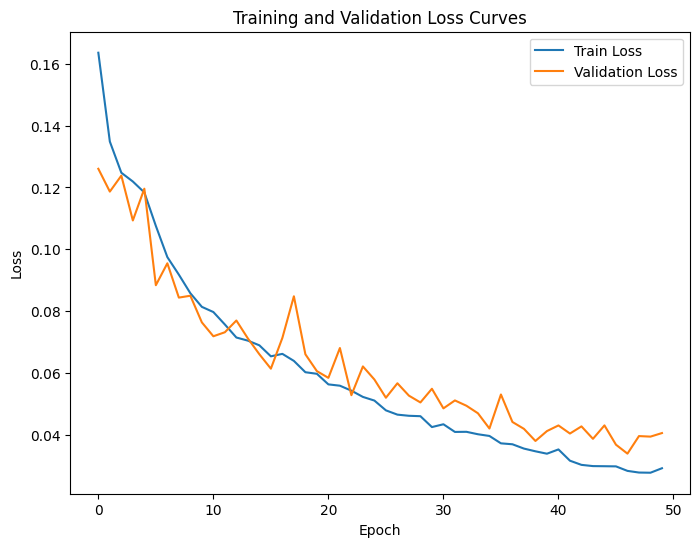

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-28-12.png
Test samples (avg ensemble):
Sample   0: Pred=1.9105, True=2.4654
Sample   1: Pred=0.1123, True=0.1334
Sample   2: Pred=0.8913, True=1.2167
Sample   3: Pred=1.5122, True=1.1593
Sample   4: Pred=0.2870, True=0.1802
Sample   5: Pred=0.0799, True=0.0600
Sample   6: Pred=5.4415, True=1.7800
Sample   7: Pred=0.5727, True=4.3986
Sample   8: Pred=0.4766, True=0.4696
Sample   9: Pred=0.1435, True=0.1055
Sample  10: Pred=0.5054, True=0.6503
Sample  11: Pred=1.7035, True=0.1610
Sample  12: Pred=0.4463, True=0.1694
Sample  13: Pred=0.5134, True=0.5143
Sample  14: Pred=2.3684, True=2.1430
Sample  15: Pred=0.1961, True=0.2603
Sample  16: Pred=0.4395, True=0.8442
Sample  17: Pred=0.1143, True=0.1382
Sample  18: Pred=0.5338, True=2.9576
Sample  19: Pred=2.4924, True=8.0533
Sample  20: Pred=0.2448, True=0.2522
Sample  21: Pred=0.0140, True=0.0144
Sample  22: Pred=0.7010, True=1.2707
Sample  23: Pred=1.2933, True=1

[INFO 03-23 17:29:43] ax.service.managed_loop: Running optimization trial 91...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

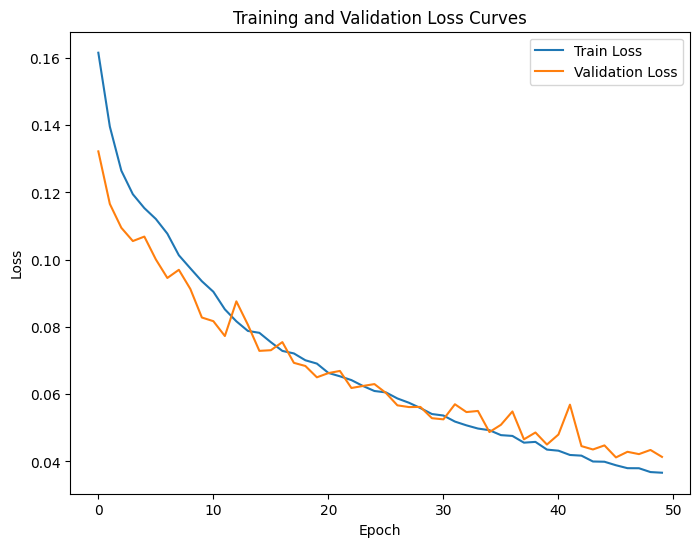

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-29-45.png
Test samples (avg ensemble):
Sample   0: Pred=1.5204, True=2.4654
Sample   1: Pred=0.1189, True=0.1334
Sample   2: Pred=0.7234, True=1.2167
Sample   3: Pred=0.7025, True=1.1593
Sample   4: Pred=0.1672, True=0.1802
Sample   5: Pred=0.0374, True=0.0600
Sample   6: Pred=11.7086, True=1.7800
Sample   7: Pred=1.2781, True=4.3986
Sample   8: Pred=0.5682, True=0.4696
Sample   9: Pred=0.1103, True=0.1055
Sample  10: Pred=0.4792, True=0.6503
Sample  11: Pred=0.7184, True=0.1610
Sample  12: Pred=0.5680, True=0.1694
Sample  13: Pred=0.1749, True=0.5143
Sample  14: Pred=2.4708, True=2.1430
Sample  15: Pred=0.2898, True=0.2603
Sample  16: Pred=0.6324, True=0.8442
Sample  17: Pred=0.1001, True=0.1382
Sample  18: Pred=0.9811, True=2.9576
Sample  19: Pred=3.1042, True=8.0533
Sample  20: Pred=0.2875, True=0.2522
Sample  21: Pred=0.0188, True=0.0144
Sample  22: Pred=0.7886, True=1.2707
Sample  23: Pred=1.7184, True=

[INFO 03-23 17:30:47] ax.service.managed_loop: Running optimization trial 92...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

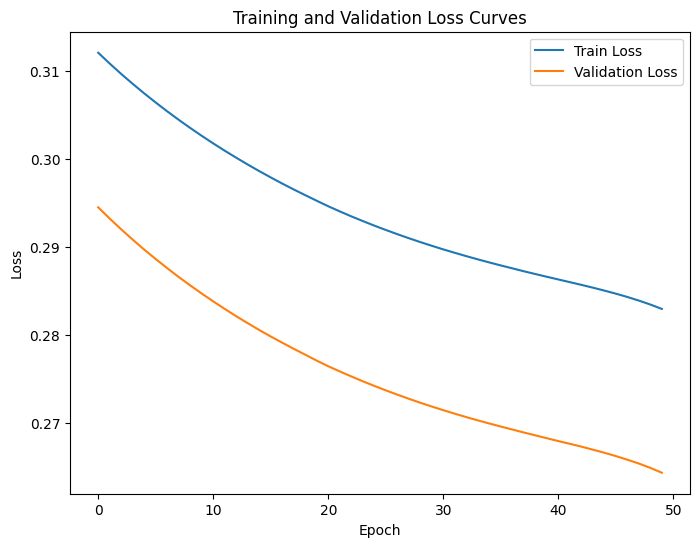

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-30-49.png
Test samples (avg ensemble):
Sample   0: Pred=0.4229, True=2.4654
Sample   1: Pred=0.4149, True=0.1334
Sample   2: Pred=0.4275, True=1.2167
Sample   3: Pred=0.4268, True=1.1593
Sample   4: Pred=0.4046, True=0.1802
Sample   5: Pred=0.4202, True=0.0600
Sample   6: Pred=0.4319, True=1.7800
Sample   7: Pred=0.4279, True=4.3986
Sample   8: Pred=0.4169, True=0.4696
Sample   9: Pred=0.4037, True=0.1055
Sample  10: Pred=0.4294, True=0.6503
Sample  11: Pred=0.4214, True=0.1610
Sample  12: Pred=0.4253, True=0.1694
Sample  13: Pred=0.4222, True=0.5143
Sample  14: Pred=0.4221, True=2.1430
Sample  15: Pred=0.4202, True=0.2603
Sample  16: Pred=0.4258, True=0.8442
Sample  17: Pred=0.4159, True=0.1382
Sample  18: Pred=0.4323, True=2.9576
Sample  19: Pred=0.4312, True=8.0533
Sample  20: Pred=0.4222, True=0.2522
Sample  21: Pred=0.3993, True=0.0144
Sample  22: Pred=0.4293, True=1.2707
Sample  23: Pred=0.4288, True=1

[INFO 03-23 17:32:44] ax.service.managed_loop: Running optimization trial 93...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

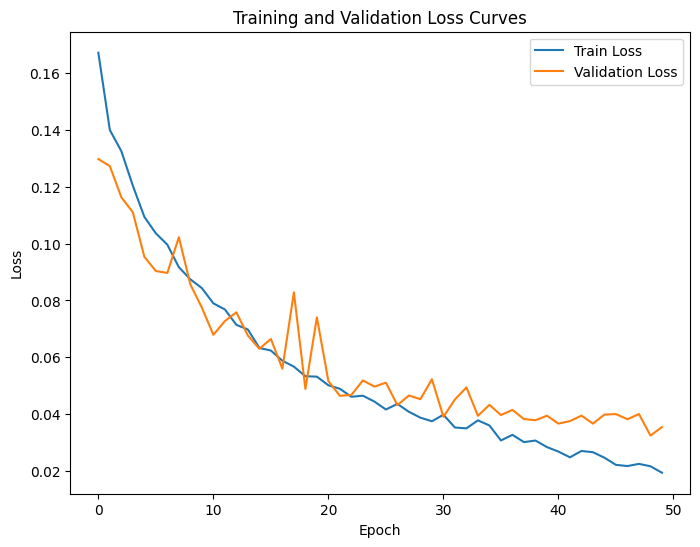

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-32-46.png
Test samples (avg ensemble):
Sample   0: Pred=1.9074, True=2.4654
Sample   1: Pred=0.1276, True=0.1334
Sample   2: Pred=2.5999, True=1.2167
Sample   3: Pred=0.7060, True=1.1593
Sample   4: Pred=0.1810, True=0.1802
Sample   5: Pred=0.0486, True=0.0600
Sample   6: Pred=7.7581, True=1.7800
Sample   7: Pred=3.9051, True=4.3986
Sample   8: Pred=0.5940, True=0.4696
Sample   9: Pred=0.0946, True=0.1055
Sample  10: Pred=0.4906, True=0.6503
Sample  11: Pred=0.4686, True=0.1610
Sample  12: Pred=0.8372, True=0.1694
Sample  13: Pred=0.3340, True=0.5143
Sample  14: Pred=1.7725, True=2.1430
Sample  15: Pred=0.2393, True=0.2603
Sample  16: Pred=0.6836, True=0.8442
Sample  17: Pred=0.1555, True=0.1382
Sample  18: Pred=1.1293, True=2.9576
Sample  19: Pred=3.5753, True=8.0533
Sample  20: Pred=0.2534, True=0.2522
Sample  21: Pred=0.0151, True=0.0144
Sample  22: Pred=0.9038, True=1.2707
Sample  23: Pred=4.5620, True=1

[INFO 03-23 17:33:19] ax.service.managed_loop: Running optimization trial 94...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

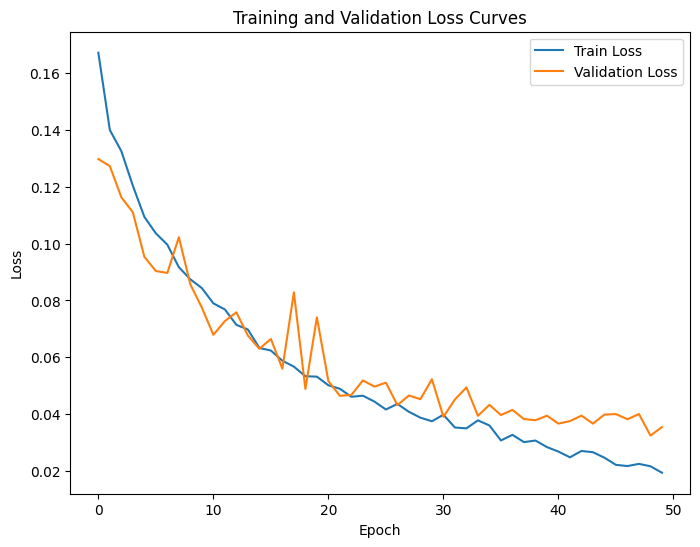

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-33-20.png
Test samples (avg ensemble):
Sample   0: Pred=1.9074, True=2.4654
Sample   1: Pred=0.1276, True=0.1334
Sample   2: Pred=2.5999, True=1.2167
Sample   3: Pred=0.7060, True=1.1593
Sample   4: Pred=0.1810, True=0.1802
Sample   5: Pred=0.0486, True=0.0600
Sample   6: Pred=7.7581, True=1.7800
Sample   7: Pred=3.9051, True=4.3986
Sample   8: Pred=0.5940, True=0.4696
Sample   9: Pred=0.0946, True=0.1055
Sample  10: Pred=0.4906, True=0.6503
Sample  11: Pred=0.4686, True=0.1610
Sample  12: Pred=0.8372, True=0.1694
Sample  13: Pred=0.3340, True=0.5143
Sample  14: Pred=1.7725, True=2.1430
Sample  15: Pred=0.2393, True=0.2603
Sample  16: Pred=0.6836, True=0.8442
Sample  17: Pred=0.1555, True=0.1382
Sample  18: Pred=1.1293, True=2.9576
Sample  19: Pred=3.5753, True=8.0533
Sample  20: Pred=0.2534, True=0.2522
Sample  21: Pred=0.0151, True=0.0144
Sample  22: Pred=0.9038, True=1.2707
Sample  23: Pred=4.5620, True=1

[INFO 03-23 17:33:52] ax.service.managed_loop: Running optimization trial 95...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anac

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

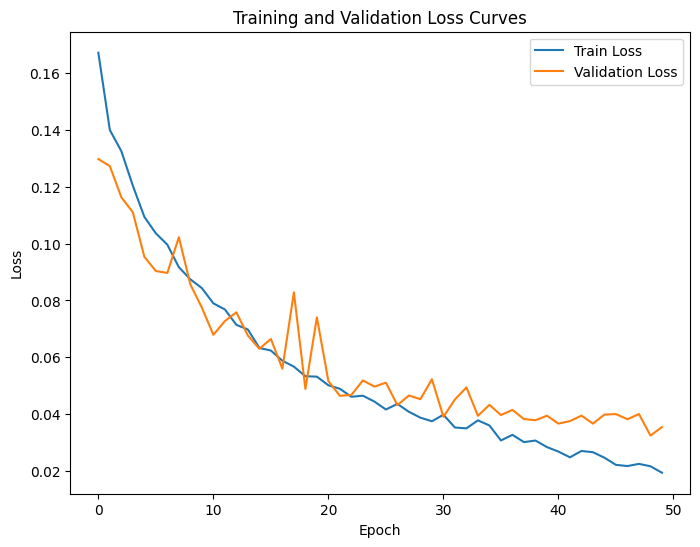

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-33-54.png
Test samples (avg ensemble):
Sample   0: Pred=1.9074, True=2.4654
Sample   1: Pred=0.1276, True=0.1334
Sample   2: Pred=2.5999, True=1.2167
Sample   3: Pred=0.7060, True=1.1593
Sample   4: Pred=0.1810, True=0.1802
Sample   5: Pred=0.0486, True=0.0600
Sample   6: Pred=7.7581, True=1.7800
Sample   7: Pred=3.9051, True=4.3986
Sample   8: Pred=0.5940, True=0.4696
Sample   9: Pred=0.0946, True=0.1055
Sample  10: Pred=0.4906, True=0.6503
Sample  11: Pred=0.4686, True=0.1610
Sample  12: Pred=0.8372, True=0.1694
Sample  13: Pred=0.3340, True=0.5143
Sample  14: Pred=1.7725, True=2.1430
Sample  15: Pred=0.2393, True=0.2603
Sample  16: Pred=0.6836, True=0.8442
Sample  17: Pred=0.1555, True=0.1382
Sample  18: Pred=1.1293, True=2.9576
Sample  19: Pred=3.5753, True=8.0533
Sample  20: Pred=0.2534, True=0.2522
Sample  21: Pred=0.0151, True=0.0144
Sample  22: Pred=0.9038, True=1.2707
Sample  23: Pred=4.5620, True=1

[INFO 03-23 17:34:28] ax.service.managed_loop: Running optimization trial 96...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

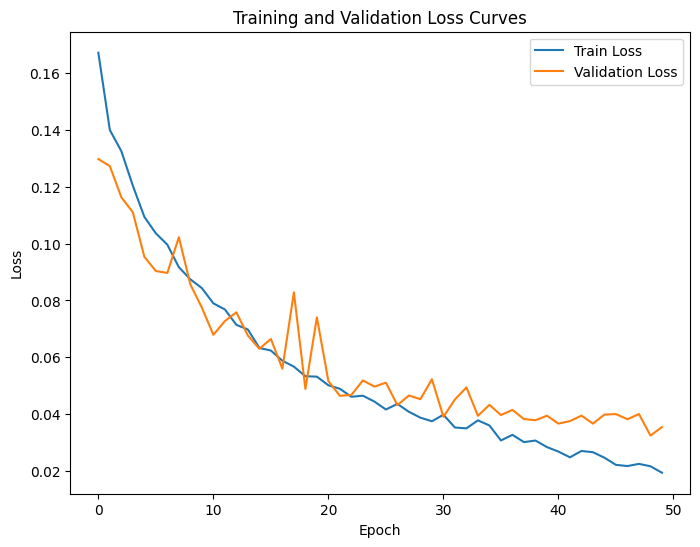

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-34-29.png
Test samples (avg ensemble):
Sample   0: Pred=1.9074, True=2.4654
Sample   1: Pred=0.1276, True=0.1334
Sample   2: Pred=2.5999, True=1.2167
Sample   3: Pred=0.7060, True=1.1593
Sample   4: Pred=0.1810, True=0.1802
Sample   5: Pred=0.0486, True=0.0600
Sample   6: Pred=7.7581, True=1.7800
Sample   7: Pred=3.9051, True=4.3986
Sample   8: Pred=0.5940, True=0.4696
Sample   9: Pred=0.0946, True=0.1055
Sample  10: Pred=0.4906, True=0.6503
Sample  11: Pred=0.4686, True=0.1610
Sample  12: Pred=0.8372, True=0.1694
Sample  13: Pred=0.3340, True=0.5143
Sample  14: Pred=1.7725, True=2.1430
Sample  15: Pred=0.2393, True=0.2603
Sample  16: Pred=0.6836, True=0.8442
Sample  17: Pred=0.1555, True=0.1382
Sample  18: Pred=1.1293, True=2.9576
Sample  19: Pred=3.5753, True=8.0533
Sample  20: Pred=0.2534, True=0.2522
Sample  21: Pred=0.0151, True=0.0144
Sample  22: Pred=0.9038, True=1.2707
Sample  23: Pred=4.5620, True=1

[INFO 03-23 17:35:00] ax.service.managed_loop: Running optimization trial 97...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 1
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

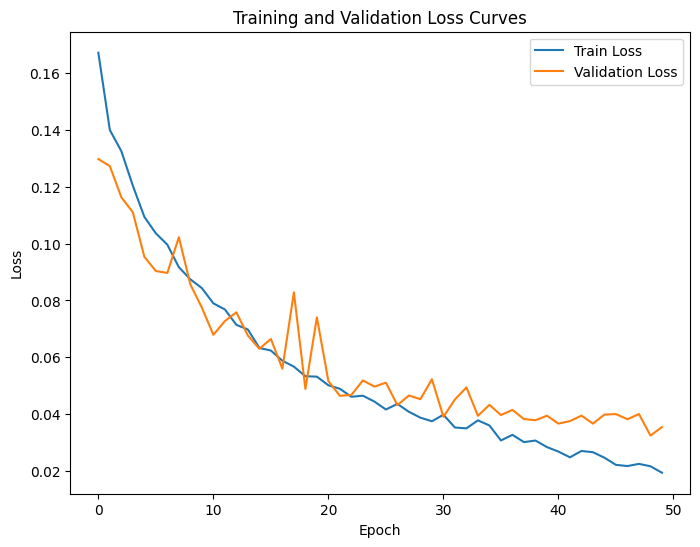

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-35-02.png
Test samples (avg ensemble):
Sample   0: Pred=1.9074, True=2.4654
Sample   1: Pred=0.1276, True=0.1334
Sample   2: Pred=2.5999, True=1.2167
Sample   3: Pred=0.7060, True=1.1593
Sample   4: Pred=0.1810, True=0.1802
Sample   5: Pred=0.0486, True=0.0600
Sample   6: Pred=7.7581, True=1.7800
Sample   7: Pred=3.9051, True=4.3986
Sample   8: Pred=0.5940, True=0.4696
Sample   9: Pred=0.0946, True=0.1055
Sample  10: Pred=0.4906, True=0.6503
Sample  11: Pred=0.4686, True=0.1610
Sample  12: Pred=0.8372, True=0.1694
Sample  13: Pred=0.3340, True=0.5143
Sample  14: Pred=1.7725, True=2.1430
Sample  15: Pred=0.2393, True=0.2603
Sample  16: Pred=0.6836, True=0.8442
Sample  17: Pred=0.1555, True=0.1382
Sample  18: Pred=1.1293, True=2.9576
Sample  19: Pred=3.5753, True=8.0533
Sample  20: Pred=0.2534, True=0.2522
Sample  21: Pred=0.0151, True=0.0144
Sample  22: Pred=0.9038, True=1.2707
Sample  23: Pred=4.5620, True=1

[INFO 03-23 17:35:38] ax.service.managed_loop: Running optimization trial 98...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

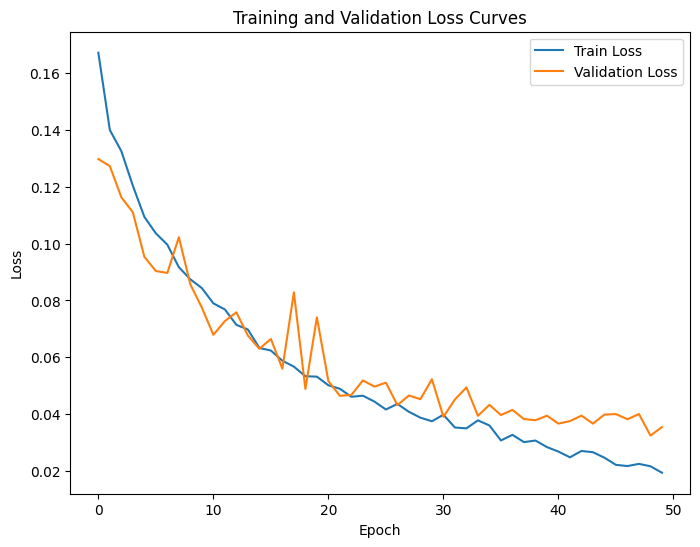

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-35-40.png
Test samples (avg ensemble):
Sample   0: Pred=1.9074, True=2.4654
Sample   1: Pred=0.1276, True=0.1334
Sample   2: Pred=2.5999, True=1.2167
Sample   3: Pred=0.7060, True=1.1593
Sample   4: Pred=0.1810, True=0.1802
Sample   5: Pred=0.0486, True=0.0600
Sample   6: Pred=7.7581, True=1.7800
Sample   7: Pred=3.9051, True=4.3986
Sample   8: Pred=0.5940, True=0.4696
Sample   9: Pred=0.0946, True=0.1055
Sample  10: Pred=0.4906, True=0.6503
Sample  11: Pred=0.4686, True=0.1610
Sample  12: Pred=0.8372, True=0.1694
Sample  13: Pred=0.3340, True=0.5143
Sample  14: Pred=1.7725, True=2.1430
Sample  15: Pred=0.2393, True=0.2603
Sample  16: Pred=0.6836, True=0.8442
Sample  17: Pred=0.1555, True=0.1382
Sample  18: Pred=1.1293, True=2.9576
Sample  19: Pred=3.5753, True=8.0533
Sample  20: Pred=0.2534, True=0.2522
Sample  21: Pred=0.0151, True=0.0144
Sample  22: Pred=0.9038, True=1.2707
Sample  23: Pred=4.5620, True=1

[INFO 03-23 17:36:15] ax.service.managed_loop: Running optimization trial 99...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

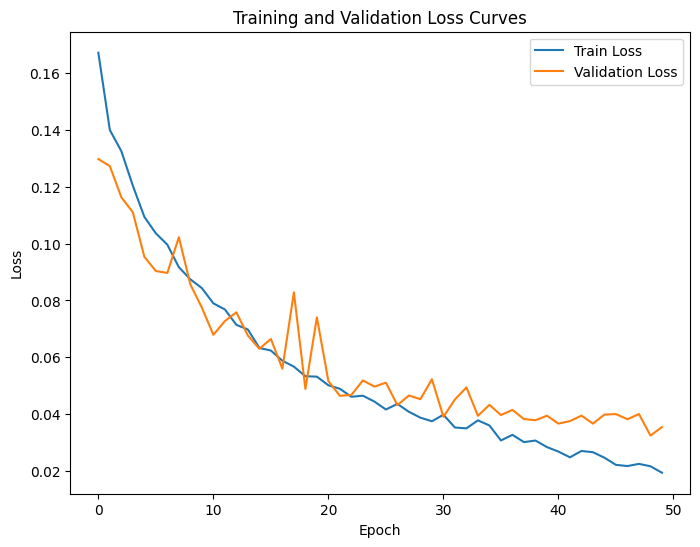

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-36-17.png
Test samples (avg ensemble):
Sample   0: Pred=1.9074, True=2.4654
Sample   1: Pred=0.1276, True=0.1334
Sample   2: Pred=2.5999, True=1.2167
Sample   3: Pred=0.7060, True=1.1593
Sample   4: Pred=0.1810, True=0.1802
Sample   5: Pred=0.0486, True=0.0600
Sample   6: Pred=7.7581, True=1.7800
Sample   7: Pred=3.9051, True=4.3986
Sample   8: Pred=0.5940, True=0.4696
Sample   9: Pred=0.0946, True=0.1055
Sample  10: Pred=0.4906, True=0.6503
Sample  11: Pred=0.4686, True=0.1610
Sample  12: Pred=0.8372, True=0.1694
Sample  13: Pred=0.3340, True=0.5143
Sample  14: Pred=1.7725, True=2.1430
Sample  15: Pred=0.2393, True=0.2603
Sample  16: Pred=0.6836, True=0.8442
Sample  17: Pred=0.1555, True=0.1382
Sample  18: Pred=1.1293, True=2.9576
Sample  19: Pred=3.5753, True=8.0533
Sample  20: Pred=0.2534, True=0.2522
Sample  21: Pred=0.0151, True=0.0144
Sample  22: Pred=0.9038, True=1.2707
Sample  23: Pred=4.5620, True=1

[INFO 03-23 17:36:48] ax.service.managed_loop: Running optimization trial 100...
/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/botorch/optim/optimize_mixed.py:702: OptimizationWarning: Failed to initialize using continuous relaxation. Using `sample_feasible_points` for initialization. Original error message: 2
  best_X, best_acq_val = generate_starting_points(
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/anaconda3/envs/engibench/lib/python3.11/dataclasses.py:1501: RuntimeWarning: If using a 2-dim `batch_initial_conditions` botorch will default to old behavior of ignoring `num_restarts` and just use the given `batch_initial_conditions` by setting `raw_samples` to None.
  return obj.__class__(**changes)
/opt/ana

Using device: mps
         C1        C2        C3        C4        C5        C6        L1  \
0  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
1  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
2  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
4  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

         L2        L3   T1         g         r          e  
0  0.000001  0.000001  0.1  0.440126  0.914354  -3.903844  
1  0.000001  0.000001  0.2  0.410832  1.152453  -9.022484  
2  0.000001  0.000001  0.3  0.353193  1.521469 -14.144002  
3  0.000001  0.000001  0.4  0.256083  2.190335 -19.268402  
4  0.000001  0.000001  0.5  0.147918  3.205281 -24.395419  
Applied log-transform to column 'r'
Continuous param columns: ['T1', 'g']
Categorical param columns: ['C1_1e-06', 'C1_2e-05', 'C2_1e-06', 'C2_2e-05', 'C3_1e-06', 'C3_2e-05

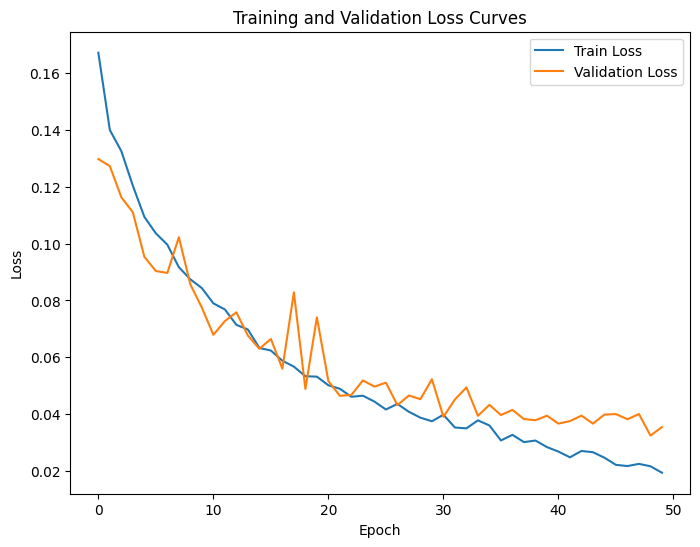

Loss curves saved to: my_models/loss_power_electronics_v0_1.csv__2025-03-23-17-36-50.png
Test samples (avg ensemble):
Sample   0: Pred=1.9074, True=2.4654
Sample   1: Pred=0.1276, True=0.1334
Sample   2: Pred=2.5999, True=1.2167
Sample   3: Pred=0.7060, True=1.1593
Sample   4: Pred=0.1810, True=0.1802
Sample   5: Pred=0.0486, True=0.0600
Sample   6: Pred=7.7581, True=1.7800
Sample   7: Pred=3.9051, True=4.3986
Sample   8: Pred=0.5940, True=0.4696
Sample   9: Pred=0.0946, True=0.1055
Sample  10: Pred=0.4906, True=0.6503
Sample  11: Pred=0.4686, True=0.1610
Sample  12: Pred=0.8372, True=0.1694
Sample  13: Pred=0.3340, True=0.5143
Sample  14: Pred=1.7725, True=2.1430
Sample  15: Pred=0.2393, True=0.2603
Sample  16: Pred=0.6836, True=0.8442
Sample  17: Pred=0.1555, True=0.1382
Sample  18: Pred=1.1293, True=2.9576
Sample  19: Pred=3.5753, True=8.0533
Sample  20: Pred=0.2534, True=0.2522
Sample  21: Pred=0.0151, True=0.0144
Sample  22: Pred=0.9038, True=1.2707
Sample  23: Pred=4.5620, True=1

Best Parameters: {'learning_rate': 0.001, 'hidden_layers': 5, 'hidden_size': 256, 'batch_size': 32, 'l2_lambda': 1e-06, 'activation': 'tanh'}
Best Validation Loss: ({'objective': 0.03242513105066286}, {'objective': {'objective': 1.0595448489427812e-07}})


In [1]:
from ax import optimize
from engiopt.shape2shape_leastV_vae_hybsm import Args, main

def train_and_evaluate_model(hyperparams: dict) -> float:
    """
    Creates a new Args instance (using defaults that match your command-line call),
    updates it with hyperparameters from Ax (including l2 penalization),
    runs training, and returns the best validation loss.
    """
    args = Args(
        data_dir="../EngiOpt/data",
        data_input="power_electronics_v0_1.csv",
        init_col="",
        opt_col="",
        target_col="r",
        log_target=True,
        params_cols=["C1", "C2", "C3", "C4", "C5", "C6", "L1", "L2", "L3", "T1", "g"],
        strip_column_spaces=True,
        flatten_columns=[],  # no flattening for PE dataset
        lambda_lv=1e-2,
        learning_rate=1e-3,   # default; will be overwritten
        structured=False,     # plain MLP mode
        hidden_layers=2,      # default; will be overwritten
        hidden_size=128,      # default; will be overwritten
        activation= "tanh",    # default; will be overwritten
        latent_dim=8,
        n_epochs=50,
        batch_size=64,        # default; will be overwritten
        patience=40,
        l2_lambda=1e-3,       # default; will be overwritten
        scale_target=True,
        track=True,
        wandb_project="shape2shape_leastV_vae_hybsm_pe_BO_4",
        seed=[18],
        save_model=True,
        model_output_dir="my_models",
        test_model=True
    )
    # Update hyperparameters from Ax.
    args.learning_rate = hyperparams["learning_rate"]
    args.hidden_layers = int(hyperparams["hidden_layers"])
    args.hidden_size = int(hyperparams["hidden_size"])
    args.batch_size = int(hyperparams["batch_size"])
    args.l2_lambda = hyperparams["l2_lambda"]  # NEW: update the L2 penalty weight.
    args.activation = hyperparams["activation"]

    
    # Run training; main(args) must return best_val_loss.
    best_val_loss = main(args)
    return best_val_loss

# Now run the Ax high-level optimize function with the additional hyperparameter.
best_parameters, best_values, experiment, model = optimize(
    parameters=[
        {
            "name": "learning_rate",
            "type": "range",
            "bounds": [1e-5, 1e-3],
            "log_scale": True,
        },
        {
            "name": "hidden_layers",
            "type": "choice",
            "values": [2, 3, 4, 5],
        },
        {
            "name": "hidden_size",
            "type": "choice",
            "values": [16, 32, 64, 128, 256],
        },
        {
            "name": "batch_size",
            "type": "choice",
            "values": [8, 16, 32, 64, 128],
        },
        {
            "name": "l2_lambda",           # NEW: L2 penalty hyperparameter.
            "type": "range",
            "bounds": [1e-6, 1e-3],
            "log_scale": True,
        },
        {
            "name": "activation",
            "type": "choice",
            "value_type": "str",
            "values": ["relu", "tanh"],
        },
    ],
    evaluation_function=train_and_evaluate_model,
    minimize=True,
    total_trials=100,
)

print("Best Parameters:", best_parameters)
print("Best Validation Loss:", best_values)


In [1]:
# better cause circuit as categorical values so dimless i think not needed
!python ./engiopt/shape2shape_leastV_vae_hybsm.py \
    --data_dir "../EngiOpt/data" \
    --data_input "power_electronics_v0_1.csv" \
    --init_col "" \
    --opt_col "" \
    --target_col "r" \
    --log_target \
    --params_cols '["C1","C2","C3","C4","C5","C6","L1","L2","L3","T1", "g"]' \
    --l2_lambda 1e-6\
    --strip_column_spaces \
    --flatten_columns "[]" \
    --lambda_lv 1e-2 \
    --learning_rate 1e-3 \
    --lr_decay 0.95 \
    --activation "tanh" \
    --no-structured \
    --hidden_layers 5 \
    --hidden_size 256 \
    --latent_dim 8 \
    --n_epochs 150 \
    --batch_size 16 \
    --patience 30 \
    --scale_target \
    --track \
    --wandb_project "shape2shape_leastV_vae_hybsm_pe_ensemble_6ANN_2"\
    --seed 3 7 18 45 80 132 2050 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

wandb: Currently logged in as: smassoudi (smassoudi-eth-z-rich) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.5
wandb: Run data is saved locally in /Users/smassoudi/Library/CloudStorage/OneDrive-ETHZurich/Code_Collaborative/EngiOpt/wandb/run-20250323_180410-pbs6w0yj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run power_electronics_v0_1.csv__2025-03-23-18-04-10
wandb: ⭐️ View project at https://wandb.ai/smassoudi-eth-z-rich/shape2shape_leastV_vae_hybsm_pe_ensemble_6ANN_2
wandb: 🚀 View run at https://wandb.ai/smassoudi-eth-z-rich/shape2shape_leastV_vae_hybsm_pe_ensemble_6ANN_2/runs/pbs6w0yj
Using device: mps
         C1        C2        C3        C4  ...   T1         g         r          e
0  0.000001  0.000001  0.000001  0.000001  ...  0.1  0.440126  0.914354  -3.903844
1  0.000001  0.000001 

In [4]:
# better cause circuit as categorical values so dimless i think not needed
!python ./engiopt/shape2shape_leastV_vae_hybsm.py \
    --data_dir "../EngiOpt/data" \
    --data_input "power_electronics_v0_1.csv" \
    --init_col "" \
    --opt_col "" \
    --target_col "r" \
    --log_target \
    --params_cols '["C1","C2","C3","C4","C5","C6","L1","L2","L3","T1", "g"]' \
    --l2_lambda 1e-6\
    --strip_column_spaces \
    --flatten_columns "[]" \
    --lambda_lv 1e-2 \
    --learning_rate 1e-3 \
    --lr_decay 0.99 \
    --activation "tanh" \
    --no-structured \
    --hidden_layers 5 \
    --hidden_size 256 \
    --latent_dim 8 \
    --n_epochs 100 \
    --batch_size 16 \
    --patience 80 \
    --scale_target \
    --track \
    --wandb_project "shape2shape_leastV_vae_hybsm_pe_test1"\
    --seed 17 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

wandb: Currently logged in as: smassoudi (smassoudi-eth-z-rich) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.5
wandb: Run data is saved locally in /Users/smassoudi/Library/CloudStorage/OneDrive-ETHZurich/Code_Collaborative/EngiOpt/wandb/run-20250323_184340-osygaxhn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run power_electronics_v0_1.csv__2025-03-23-18-43-40
wandb: ⭐️ View project at https://wandb.ai/smassoudi-eth-z-rich/shape2shape_leastV_vae_hybsm_pe_test1
wandb: 🚀 View run at https://wandb.ai/smassoudi-eth-z-rich/shape2shape_leastV_vae_hybsm_pe_test1/runs/osygaxhn
Using device: mps
         C1        C2        C3        C4  ...   T1         g         r          e
0  0.000001  0.000001  0.000001  0.000001  ...  0.1  0.440126  0.914354  -3.903844
1  0.000001  0.000001  0.000001  0.000001 

In [30]:
import sys
import os

# Add the path to the directory containing your AutoGluon script
sys.path.append(os.path.abspath("../EngiOpt/engiopt"))

# Now you can import and use the script as if it's in the same directory
#from autogluon_multimodal import main


# CHECKED:

# data_dir
# data_input
# input_cols
# target_col
# flatten_columns
# hidden_layers
# activation
# optimizer
# learning_rate
# n_epochs
# batch_size
# patience
# scale_target
# wandb_project
# seed
# save_model
# track
# model_output_dir
# wandb_project



!python ./engiopt/shape2shape_leastV_vae.py \
    --data_dir "../EngiOpt/data" \
    --data_input "airfoil_data.csv" \
    --init_col "optimal_design" \
    --opt_col "optimal_design" \
    --target_col "cl_val" \
    --params_cols '["mach","reynolds","alpha"]' \
    --flatten_columns '["initial_design","optimal_design"]' \
    --lambda_lv 1e-2 \
    --learning_rate 1e-4 \
    --gamma 1.0 \
    --structured \
    --hidden_layers 3 \
    --hidden_size 32 \
    --latent_dim 8 \
    --n_epochs 50 \
    --batch_size 32 \
    --patience 40 \
    --scale_target \
    --no-track \
    --seed 18 \
    --save_model \
    --model_output_dir "my_models" \
    --test_model

Using device: mps
                                      initial_design  ...  area_con
0  [[0.9999864252928555, 0.9893170986509016, 0.97...  ...  0.832122
1  [[1.000000037209308, 0.9895321097704624, 0.979...  ...  0.887370
2  [[0.9999947929941965, 0.9893335711523464, 0.97...  ...  0.966670
3  [[0.9999964309108346, 0.9893222342558019, 0.97...  ...  0.938907
4  [[1.0000056013070746, 0.9893170615343417, 0.97...  ...  0.900123

[5 rows x 12 columns]
After flattening, df.columns: ['mach', 'reynolds', 'cl_target', 'area_target', 'alpha', 'area_initial', 'cd_val', 'cl_val', 'cl_con', 'area_con', 'initial_design_0', 'initial_design_1', 'initial_design_2', 'initial_design_3', 'initial_design_4', 'initial_design_5', 'initial_design_6', 'initial_design_7', 'initial_design_8', 'initial_design_9', 'initial_design_10', 'initial_design_11', 'initial_design_12', 'initial_design_13', 'initial_design_14', 'initial_design_15', 'initial_design_16', 'initial_design_17', 'initial_design_18', 'initial_design_